In [1059]:
import json
import os
import time

import mambapy
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import torch
from mambapy.mamba import Mamba, MambaConfig
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm, trange

from utils.experiments import ParamGrid

In [1060]:
config = mambapy.mamba.MambaConfig(d_model=16, n_layers=2)
mamba = Mamba(config)
mamba

Mamba(
  (layers): ModuleList(
    (0-1): 2 x ResidualBlock(
      (mixer): MambaBlock(
        (in_proj): Linear(in_features=16, out_features=64, bias=False)
        (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,), padding=(3,), groups=32)
        (x_proj): Linear(in_features=32, out_features=33, bias=False)
        (dt_proj): Linear(in_features=1, out_features=32, bias=True)
        (out_proj): Linear(in_features=32, out_features=16, bias=False)
      )
      (norm): RMSNorm()
    )
  )
)

In [1061]:
rb = mambapy.mamba.ResidualBlock(config)
rb

ResidualBlock(
  (mixer): MambaBlock(
    (in_proj): Linear(in_features=16, out_features=64, bias=False)
    (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,), padding=(3,), groups=32)
    (x_proj): Linear(in_features=32, out_features=33, bias=False)
    (dt_proj): Linear(in_features=1, out_features=32, bias=True)
    (out_proj): Linear(in_features=32, out_features=16, bias=False)
  )
  (norm): RMSNorm()
)

In [1062]:
test_x = torch.as_tensor(np.random.random((10, 8, 16)), dtype=torch.float32)
rb(test_x).shape

torch.Size([10, 8, 16])

In [1063]:
mamba(test_x).shape

torch.Size([10, 8, 16])

In [1064]:
test_data = pd.read_csv('neuro/data/v2/2024-11-27_22:48:30/data.csv', index_col=0)
test_data.head()

timestamps     k_inf         heat          U235          U238
0         0.0  1.180758     0.000287  4.028022e+23  7.551203e+24
1      7200.0  1.187723  1756.950792  4.027941e+23  7.551198e+24
2     14400.0  1.179527  1817.922557  4.027859e+23  7.551192e+24
3     21600.0  1.178661  1851.699855  4.027778e+23  7.551186e+24
4     28800.0  1.189333  1872.277007  4.027696e+23  7.551180e+24

In [1065]:
test_data.describe()

timestamps       k_inf         heat          U235          U238
count  6.460000e+02  646.000000   646.000000  6.460000e+02  6.460000e+02
mean   4.593176e+06    1.166222  2049.049604  3.976906e+23  7.547478e+24
std    4.437163e+06    0.011353    88.420029  4.896443e+21  3.612785e+21
min    0.000000e+00    1.133407     0.000287  3.864088e+23  7.539063e+24
25%    1.161000e+06    1.158665  2044.261362  3.939527e+23  7.544760e+24
50%    2.322000e+06    1.167204  2060.039153  4.001849e+23  7.549331e+24
75%    7.938000e+06    1.174233  2077.044214  4.014905e+23  7.550269e+24
max    1.490400e+07    1.199556  2082.724978  4.028022e+23  7.551203e+24

In [1066]:
def normalize(df: pd.DataFrame):
    tsp = list(df.timestamps.values[1:] - df.timestamps.values[:-1])
    tsp.append(tsp[-1])
    df['timestamps'] = tsp
    df['timestamps'] /=3600*12
    df['k_inf'] -= 1
    # print(savgol_filter(df['k_inf'], 7, 4).shape, df['k_inf'].shape)
    # kinf0 = df['k_inf'].values[2:]
    # kinf1 = df['k_inf'].values[1:-1]
    # kinf2 = df['k_inf'].values[:-2]
    # kinf = list((kinf0+kinf1+kinf2)/3)
    # kinf.append(kinf2[0])
    # kinf.append(kinf0[-1])
    df['k_inf'] = savgol_filter(df['k_inf'], 25, 2)
    
    # u5 = df['U235'].values[1:]- df['U235'].values[:-1]
    # u5= list(u5)
    # u5.append(u5[-1])
    # u8 = df['U238'].values[1:]- df['U238'].values[:-1]
    # u8= list(u8)
    # u8.append(u8[-1])
    # df['heat'] /= 2100
    # df['U235'] = u5
    # df['U238'] = u8
    return df

In [1067]:
test_data_normed = test_data.copy()
test_data_normed = normalize(test_data_normed)
test_data_normed.describe()

timestamps       k_inf         heat          U235          U238
count  646.000000  646.000000   646.000000  6.460000e+02  6.460000e+02
mean     0.535604    0.166208  2049.049604  3.976906e+23  7.547478e+24
std      0.414245    0.008444    88.420029  4.896443e+21  3.612785e+21
min      0.166667    0.145979     0.000287  3.864088e+23  7.539063e+24
25%      0.166667    0.159565  2044.261362  3.939527e+23  7.544760e+24
50%      0.166667    0.168323  2060.039153  4.001849e+23  7.549331e+24
75%      1.000000    0.172344  2077.044214  4.014905e+23  7.550269e+24
max      1.000000    0.184554  2082.724978  4.028022e+23  7.551203e+24

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

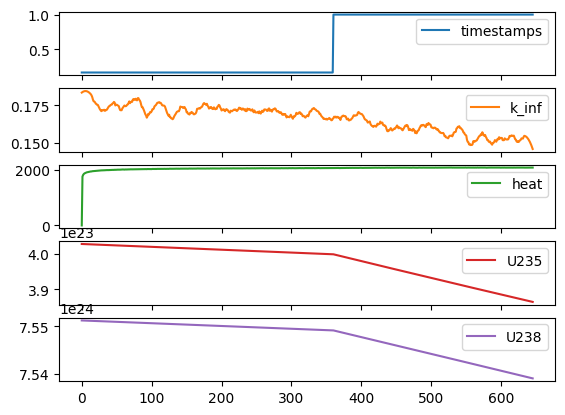

In [1068]:
test_data_normed.plot(subplots=True)

<Axes: >

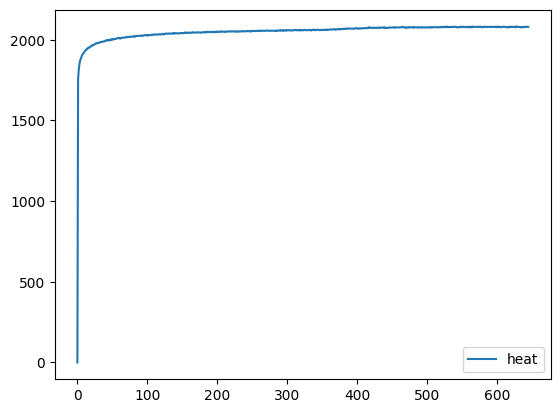

In [1040]:
test_data[['heat']].plot()

In [1041]:
neuro_data_path = 'neuro/data/v2'

NotADirectoryError: [Errno 20] Not a directory: 'neuro/data/v2/scales.json/data.csv'

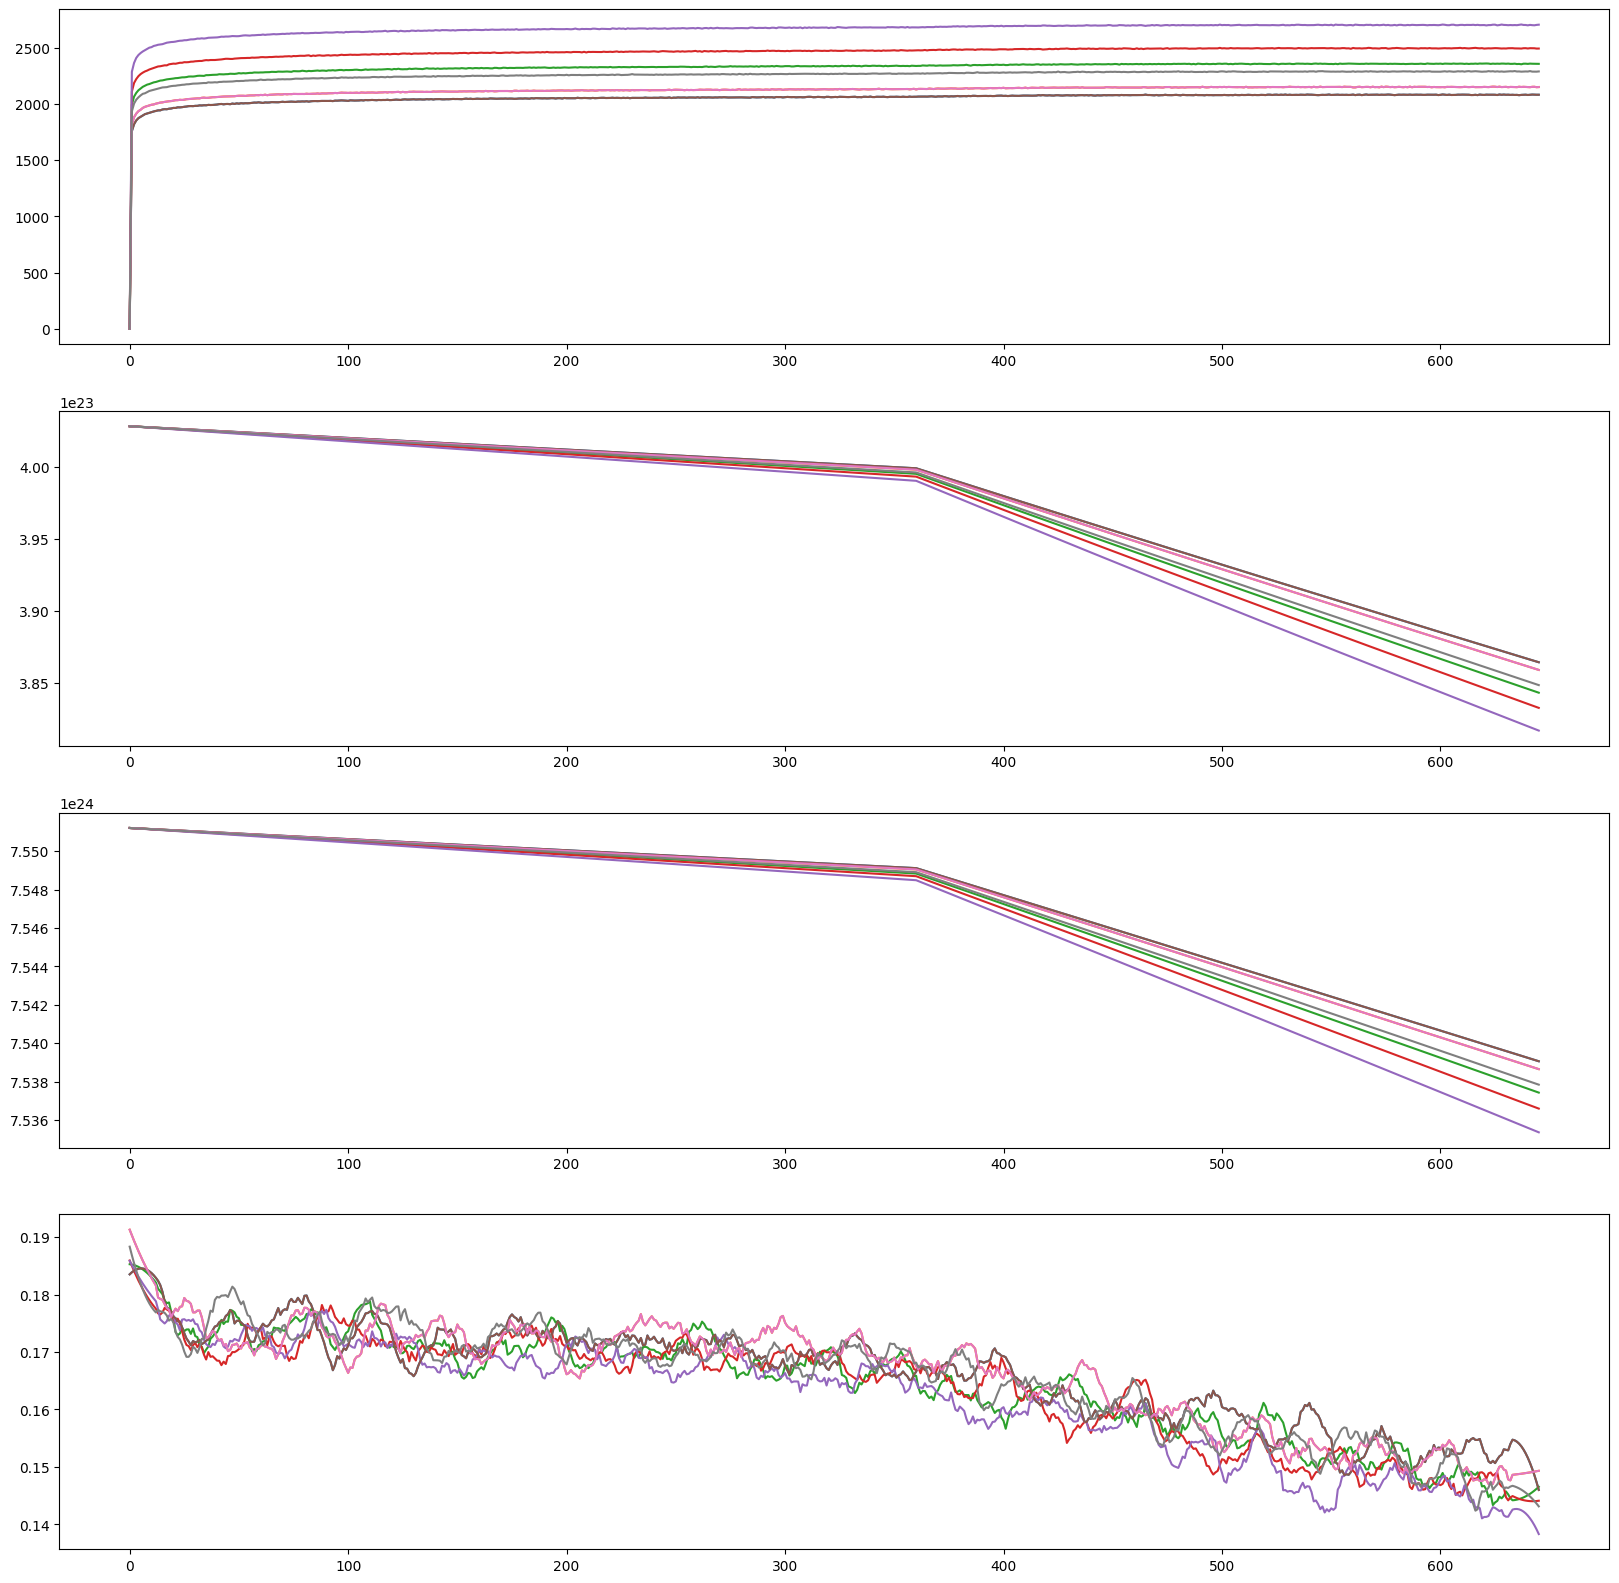

In [1042]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
for i in range(len(os.listdir(neuro_data_path))):
    df_path = os.listdir(neuro_data_path)[i]
    df = pd.read_csv(os.path.join(neuro_data_path, df_path, 'data.csv'), index_col=0)
    df = normalize(df)
    ax[0].plot(df['heat'])
    ax[1].plot(df['U235'])
    # ax[1].set_ylim([0.9,0.91])
    ax[2].plot(df['U238'])
    ax[3].plot(df['k_inf'])


In [1043]:
dataset, contexts = [], []
for i in tqdm(range(len(os.listdir(neuro_data_path)))):
    try:
        df_path = os.listdir(neuro_data_path)[i]
        df = pd.read_csv(os.path.join(neuro_data_path, df_path, 'data.csv'), index_col=0)
        df = normalize(df)
        cts = json.load(open(os.path.join(neuro_data_path, df_path, 'context.json')))
        dataset.append(df.values)
        contexts.append(cts)
    except Exception as e:
        print(e)
dataset = np.array(dataset)
dataset.shape, len(contexts)

100%|██████████| 9/9 [00:00<00:00, 425.98it/s]

[Errno 20] Not a directory: 'neuro/data/v2/scales.json/data.csv'


((8, 646, 5), 8)

In [1044]:
scales = {
    'timestamps': {'min': 0, 'max':1},
    'k_inf': {
        'min': 0,
        'max': 1
    },

}
for col, _min, _max in zip(df.columns, dataset.min(axis=(0, 1)), dataset.max(axis=(0, 1))):
    if col in scales:
        continue
    scales[col] = {
        'min': _min,
        'max': _max
    }
json.dump(scales, open(os.path.join(neuro_data_path, 'scales.json'), 'w'))
scales

{'timestamps': {'min': 0, 'max': 1},
 'k_inf': {'min': 0, 'max': 1},
 'heat': {'min': np.float64(0.0002865152055716),
  'max': np.float64(2704.420749232821)},
 'U235': {'min': np.float64(3.8166230576109536e+23),
  'max': np.float64(4.0280220516634e+23)},
 'U238': {'min': np.float64(7.535364024316676e+24),
  'max': np.float64(7.551203391682147e+24)}}

In [1045]:
dataset.min(axis=(0, 1)), dataset.max(axis=(0, 1))

(array([1.66666667e-01, 1.38297961e-01, 2.86515206e-04, 3.81662306e+23,
        7.53536402e+24]),
 array([1.00000000e+00, 1.91295828e-01, 2.70442075e+03, 4.02802205e+23,
        7.55120339e+24]))

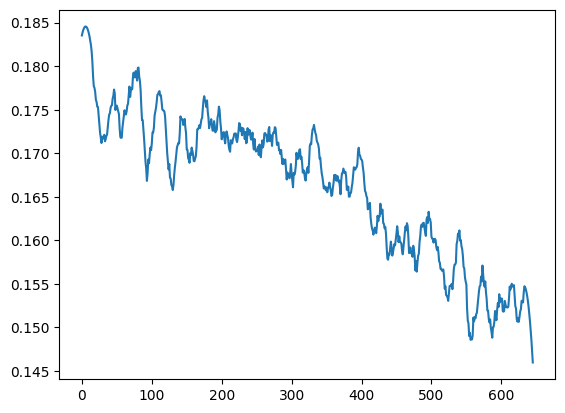

In [1046]:
mins, maxs = [], []
for key, value in scales.items():
    mins.append(value['min'])
    maxs.append(value['max'])
mins = np.array(mins)
maxs = np.array(maxs)

scaled = ((dataset - mins) / (maxs - mins))
plt.plot(scaled[0, :, 1])

In [1047]:
dataset.max(axis=(0, 1)), dataset.min(axis=(0, 1))

(array([1.00000000e+00, 1.91295828e-01, 2.70442075e+03, 4.02802205e+23,
        7.55120339e+24]),
 array([1.66666667e-01, 1.38297961e-01, 2.86515206e-04, 3.81662306e+23,
        7.53536402e+24]))

In [1048]:
mins, maxs

(array([0.00000000e+00, 0.00000000e+00, 2.86515206e-04, 3.81662306e+23,
        7.53536402e+24]),
 array([1.00000000e+00, 1.00000000e+00, 2.70442075e+03, 4.02802205e+23,
        7.55120339e+24]))

In [1049]:
scaled[0]

array([[0.16666667, 0.18352583, 0.        , 1.        , 1.        ],
       [0.16666667, 0.18387835, 0.64965878, 0.9996158 , 0.99963681],
       [0.16666667, 0.18415744, 0.67220401, 0.99922895, 0.99928059],
       ...,
       [1.        , 0.14854678, 0.76932204, 0.22888918, 0.23797955],
       [1.        , 0.14731854, 0.76918065, 0.22670854, 0.23574576],
       [1.        , 0.14597941, 0.76920951, 0.22452681, 0.23350156]])

In [1050]:
class MambaDataset(torch.utils.data.Dataset):

    def __init__(self, data: np.array, context: dict, window_size=16):
        self.data = data
        self.context = context
        self.window_size = window_size

    def __len__(self):
        return self.data.shape[0] - self.window_size + 1

    def __getitem__(self, idx):
        assert idx < len(self), f'idx {idx} out of range'
        _from = max(0, idx - self.window_size)
        window = self.data[_from:idx, :]
        if window.shape[0] < self.window_size:
            zeros = np.zeros((self.window_size - window.shape[0], self.data.shape[1]))
            window = np.vstack((zeros, window))
        pred = self.data[idx:idx + self.window_size, :]
        return window.T, pred.T

In [1051]:
test_dataset = MambaDataset(scaled[0], contexts[0], window_size=8)
test_dataset.data.min(axis=(0))

array([0.16666667, 0.14597941, 0.        , 0.22452681, 0.23350156])

In [1052]:
contexts

[{'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 429.76987501108374,
  'fuel_density': 8.3,
  'cladding_volume': 573.0265000147781,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 429.76987501108374,
  'fuel_density': 8.3,
  'cladding_volume': 573.0265000147781,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 429.76987501108374,
  'fuel_density': 8.3,
  'cladding_volume': 573.0265000147781,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 429.76987501108374,
  'fuel_density': 8.3,
  'cladding_volume': 573.0265000147781,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 429.76987501108374,
  'fuel_density': 8.3,
  'cladding_volume': 573.0265000147781,
  'claddi

In [1053]:
test_context_tensor = torch.as_tensor(np.random.random((4, 8)), dtype=torch.float32).mean(dim=0)
print(test_context_tensor.shape)
# test_ll = torch.nn.Linear(8, 5)
# test_context_tensor = test_ll(test_context_tensor)
test_mamba_tensor = torch.as_tensor(np.random.random((10, 5, 8)), dtype=torch.float32)
(test_context_tensor * test_mamba_tensor).shape

torch.Size([8])


torch.Size([10, 5, 8])

In [1054]:
class MyMamba(Mamba):
    train_time = 0

    def __init__(self, config: mambapy.mamba.MambaConfig = None):
        if config is None:
            config = mambapy.mamba.MambaConfig(d_model=8, n_layers=5)
        super().__init__(config)
        self.context_emdedding = torch.nn.Conv1d(1, config.d_model, 1)
        self.context_norm = torch.nn.LayerNorm(config.d_model)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def _reformat_context(self, context):
        _context = (
            context['enr'],
            context['water_volume'],
            context['fuel_volume'],
            context['cladding_volume'],
        )
        _context = torch.as_tensor(np.array(_context)[np.newaxis, :], dtype=torch.float32)
        return _context

    def set_context(self, context: dict):
        self.context = self._reformat_context(context).to(self.device)
        self.cx = self.context_emdedding(self.context).T
        self.cx = self.context_norm(self.cx).mean(dim=0)

    def forward(self, x, context=None):
        if context is None:
            cx = self.cx
        else:
            cx = self.context_emdedding(context).T
            cx = self.context_norm(cx).mean(dim=0)
        x = torch.as_tensor(x, dtype=torch.float32)
        for layer in self.layers:
            x = x + cx
            x = layer(x)
        return x
    
    def _calc_loss(self, true, pred):
        loss_fn = torch.nn.MSELoss(reduction='none')
        loss = (loss_fn(pred, true).mean(dim=1)*(2-true[:,0,:])).mean()
        return loss
        

    def fit(self, data_dicts: list, epochs: int, batch_size: int = 10, savedir='neuro/models'):
        os.makedirs(savedir, exist_ok=True)
        start_train_time = time.perf_counter()
        
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        hist = []
        
        pbar = trange(epochs, desc='Training started...', leave=False)
        for epoch in pbar:
            start = time.perf_counter()
            epoch_loss = []

            pbar.set_description(f'Epoch {epoch}/{epochs}:')
            pbar.refresh()
            optimizer.zero_grad()
            for data_dict in data_dicts:
                context = data_dict['context']
                ds = MambaDataset(data_dict['data'], context, window_size=self.config.d_model)
                self.set_context(data_dict['context'])
                dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)
                for x, y in dl:
                    x = torch.as_tensor(x, dtype=torch.float32).to(self.device)
                    y = torch.as_tensor(y, dtype=torch.float32).to(self.device)
                    outputs = self(x, self.context)
                    # Compute the loss and its gradients
                    loss = self._calc_loss(y, outputs)
                    loss.backward()
                    # Adjust learning weights
                    optimizer.step()
                    epoch_loss.append(loss.item())
                    if not hasattr(self, 'best_loss') or loss.item() < self.best_loss:
                        self.best_loss = loss.item()
                        torch.save(self.state_dict(), os.path.join(savedir, 'best.pt'))

            epoch_loss = sum(epoch_loss) / len(epoch_loss)
            pbar.set_postfix_str(f'Loss: {epoch_loss:.4f}. Took {(time.perf_counter() - start) / 60:.2f} minutes')
            hist.append(epoch_loss)

        print(f'Training finished. Best Loss: {self.best_loss}')

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
        ax.plot(hist)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Loss Curve\nBest Loss: {self.best_loss:.4f}')
        ax.grid()
        delattr(self, 'best_loss')
        plt.savefig(os.path.join(savedir, 'loss.png'))
        torch.save(self.state_dict(), os.path.join(savedir, 'last.pt'))
        self.train_time = time.perf_counter() - start_train_time
        return hist

    def test(self, data, context, savedir='neuro/models'):
        test_dataset = MambaDataset(data, context, window_size=self.config.d_model)
        test_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
        self.set_context(context)

        true, pred = [], []
        for x, y in test_data_loader:
            x = torch.as_tensor(x, dtype=torch.float32).to(mmb.device)
            y = torch.as_tensor(y, dtype=torch.float32).to(mmb.device)
            true.append(y.cpu().numpy()[0, :, 0])
            pred.append(mmb(x).cpu().detach().numpy()[0, :, 0])
        true = np.array(true)
        pred = np.array(pred)

        fig, ax = plt.subplots(nrows=true.shape[-1], ncols=1, figsize=(20, 20))
        for i in range(len(ax)):
            ax[i].plot(true[:, i], label='true')
            ax[i].plot(pred[:, i], label='pred')
            ax[i].legend()
            ax[i].grid()
        plt.savefig(os.path.join(savedir, 'testing.jpeg'))
        dif = (true[:, 3:] - pred[:, 3:]).mean() / true[:, 3:].mean()
        with open(os.path.join(savedir, 'testing_results.json'), 'w') as f:
            json.dump({
                'training_time': int(self.train_time),
                'testing_results': {
                    "dif": float(dif)
                }
            }, f)
        print(f'Testing finished. Error: {dif*100:.4}%')

In [1055]:
prepared_data = [{'data': scaled[i], 'context': contexts[i]} for i in range(1, len(contexts))]

In [1056]:
mpg = ParamGrid({
    'd_model': [6,8,14,20],
    'n_layers': [12, 24, 48, 64, 96],
})

dict_keys(['d_model', 'n_layers']) <itertools.product object at 0x78739b062540>


Training finished. Best Loss: 0.005379578564316034
Testing finished. Error: -0.05428%


Training finished. Best Loss: 0.009348132647573948
Testing finished. Error: 3.734%


Training finished. Best Loss: 0.027353540062904358
Testing finished. Error: -6.274%


Training finished. Best Loss: 0.014069026336073875
Testing finished. Error: -2.699%


Training finished. Best Loss: 0.5588213801383972
Testing finished. Error: -40.98%


Training finished. Best Loss: 0.0032606166787445545
Testing finished. Error: 1.063%


Training finished. Best Loss: 0.0071932291612029076
Testing finished. Error: -0.06005%


Training finished. Best Loss: 0.010803762823343277
Testing finished. Error: -10.49%


Training finished. Best Loss: 0.021311257034540176
Testing finished. Error: -5.89%


Training finished. Best Loss: 0.01786118559539318
Testing finished. Error: 9.165%


/tmp/ipykernel_885181/2087508557.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))


Training finished. Best Loss: 0.003386127995327115
Testing finished. Error: 2.738%


Training finished. Best Loss: 0.015499851666390896
Testing finished. Error: 6.314%


Training finished. Best Loss: 0.006032071076333523
Testing finished. Error: 2.376%


Training finished. Best Loss: 0.013469346798956394
Testing finished. Error: 0.9276%


Training finished. Best Loss: 0.1087808832526207
Testing finished. Error: -44.85%


Training finished. Best Loss: 0.004857203923165798
Testing finished. Error: 1.581%


Training finished. Best Loss: 0.0055340188555419445
Testing finished. Error: 4.784%


Training finished. Best Loss: 0.004664663225412369
Testing finished. Error: 1.25%


Training finished. Best Loss: 0.026365680620074272
Testing finished. Error: -15.29%


Training finished. Best Loss: 0.019830185920000076
Testing finished. Error: -5.789%


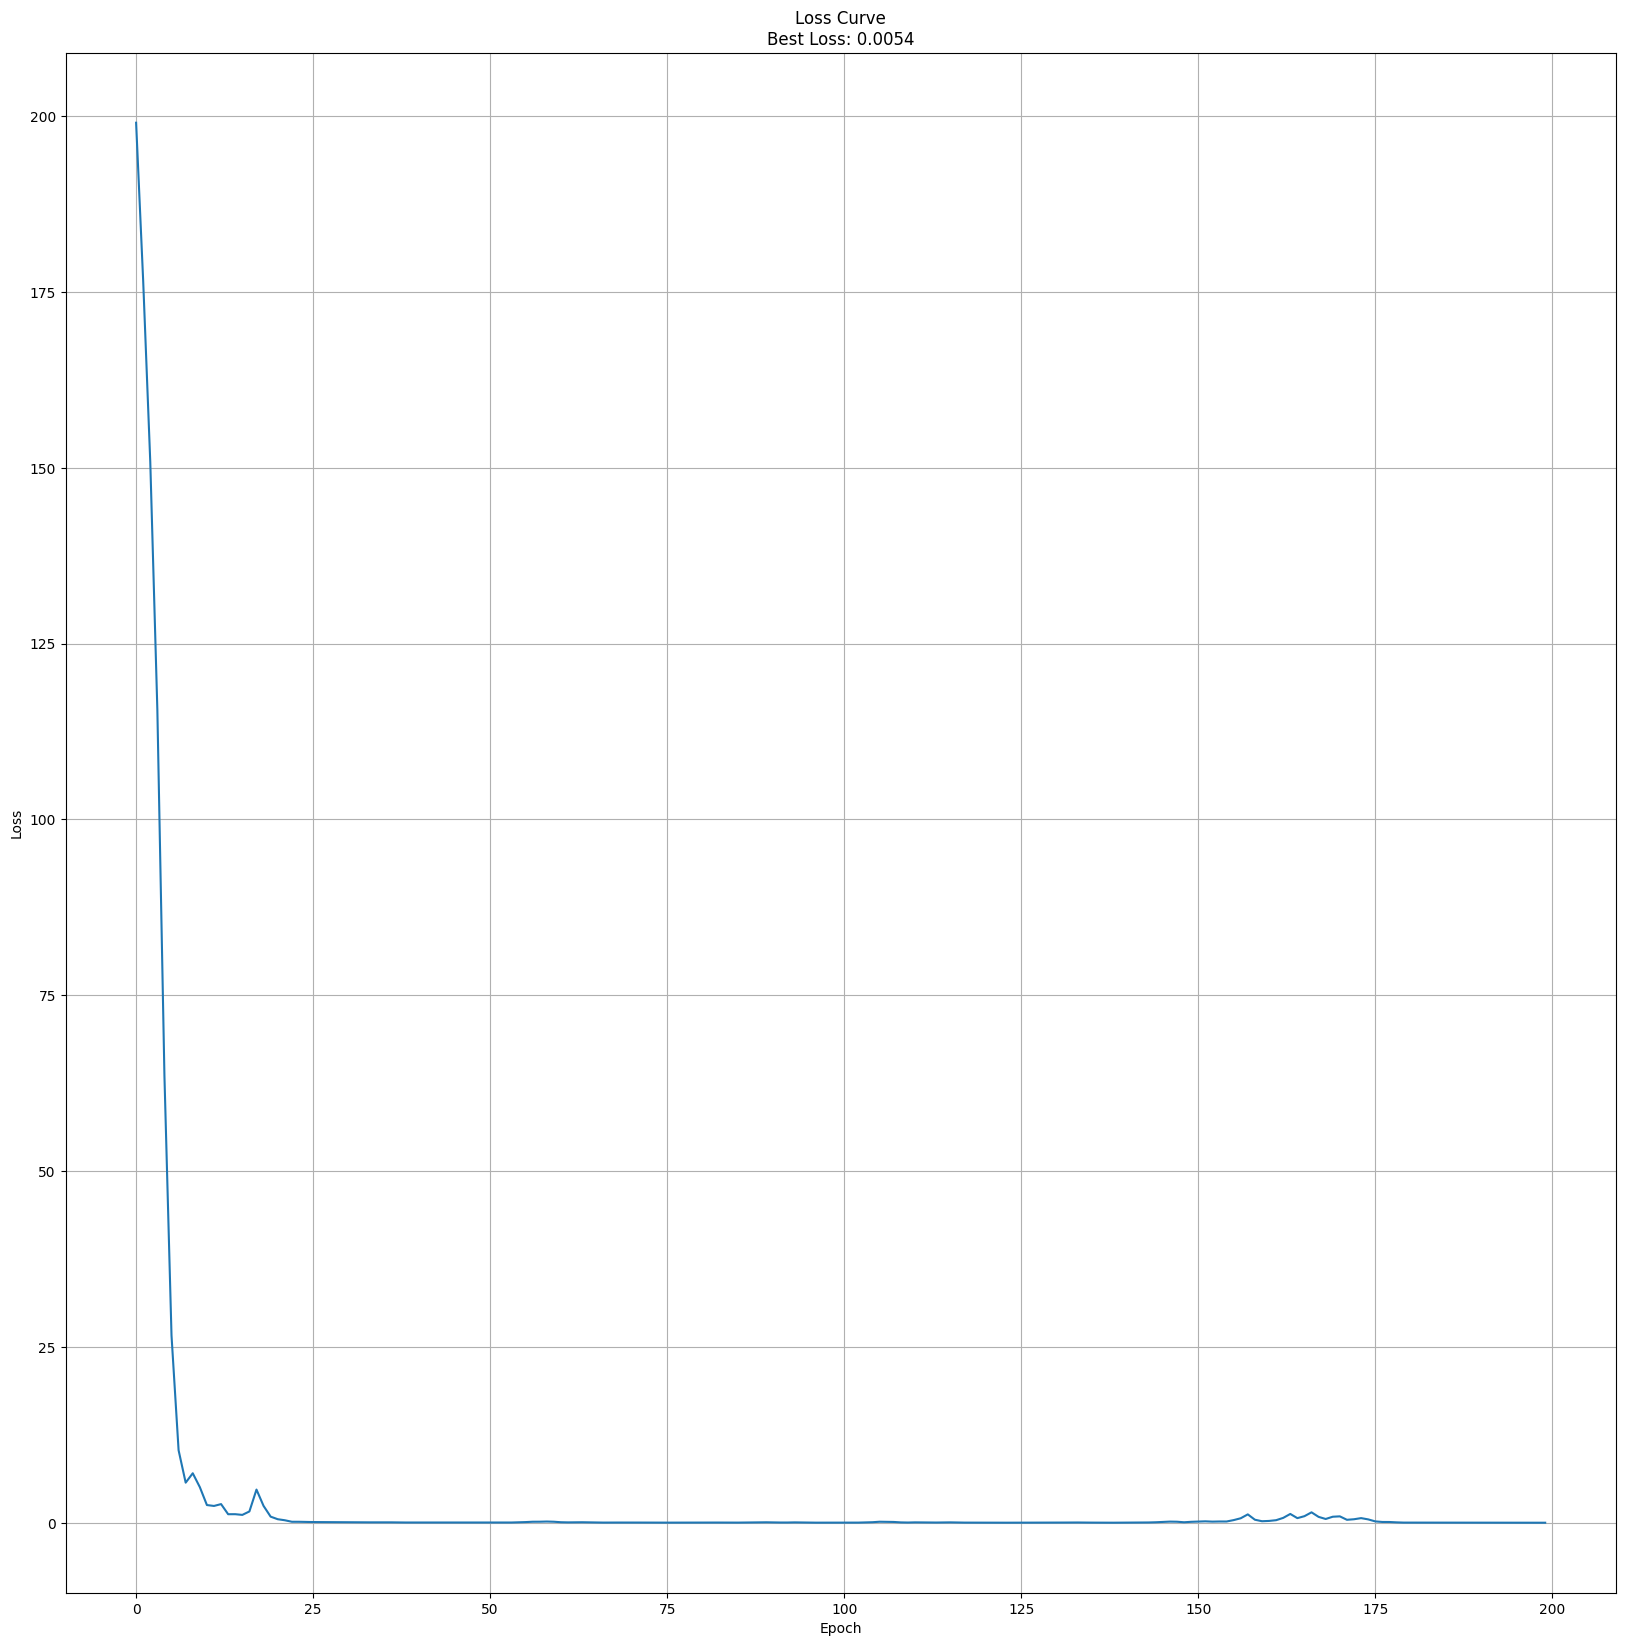

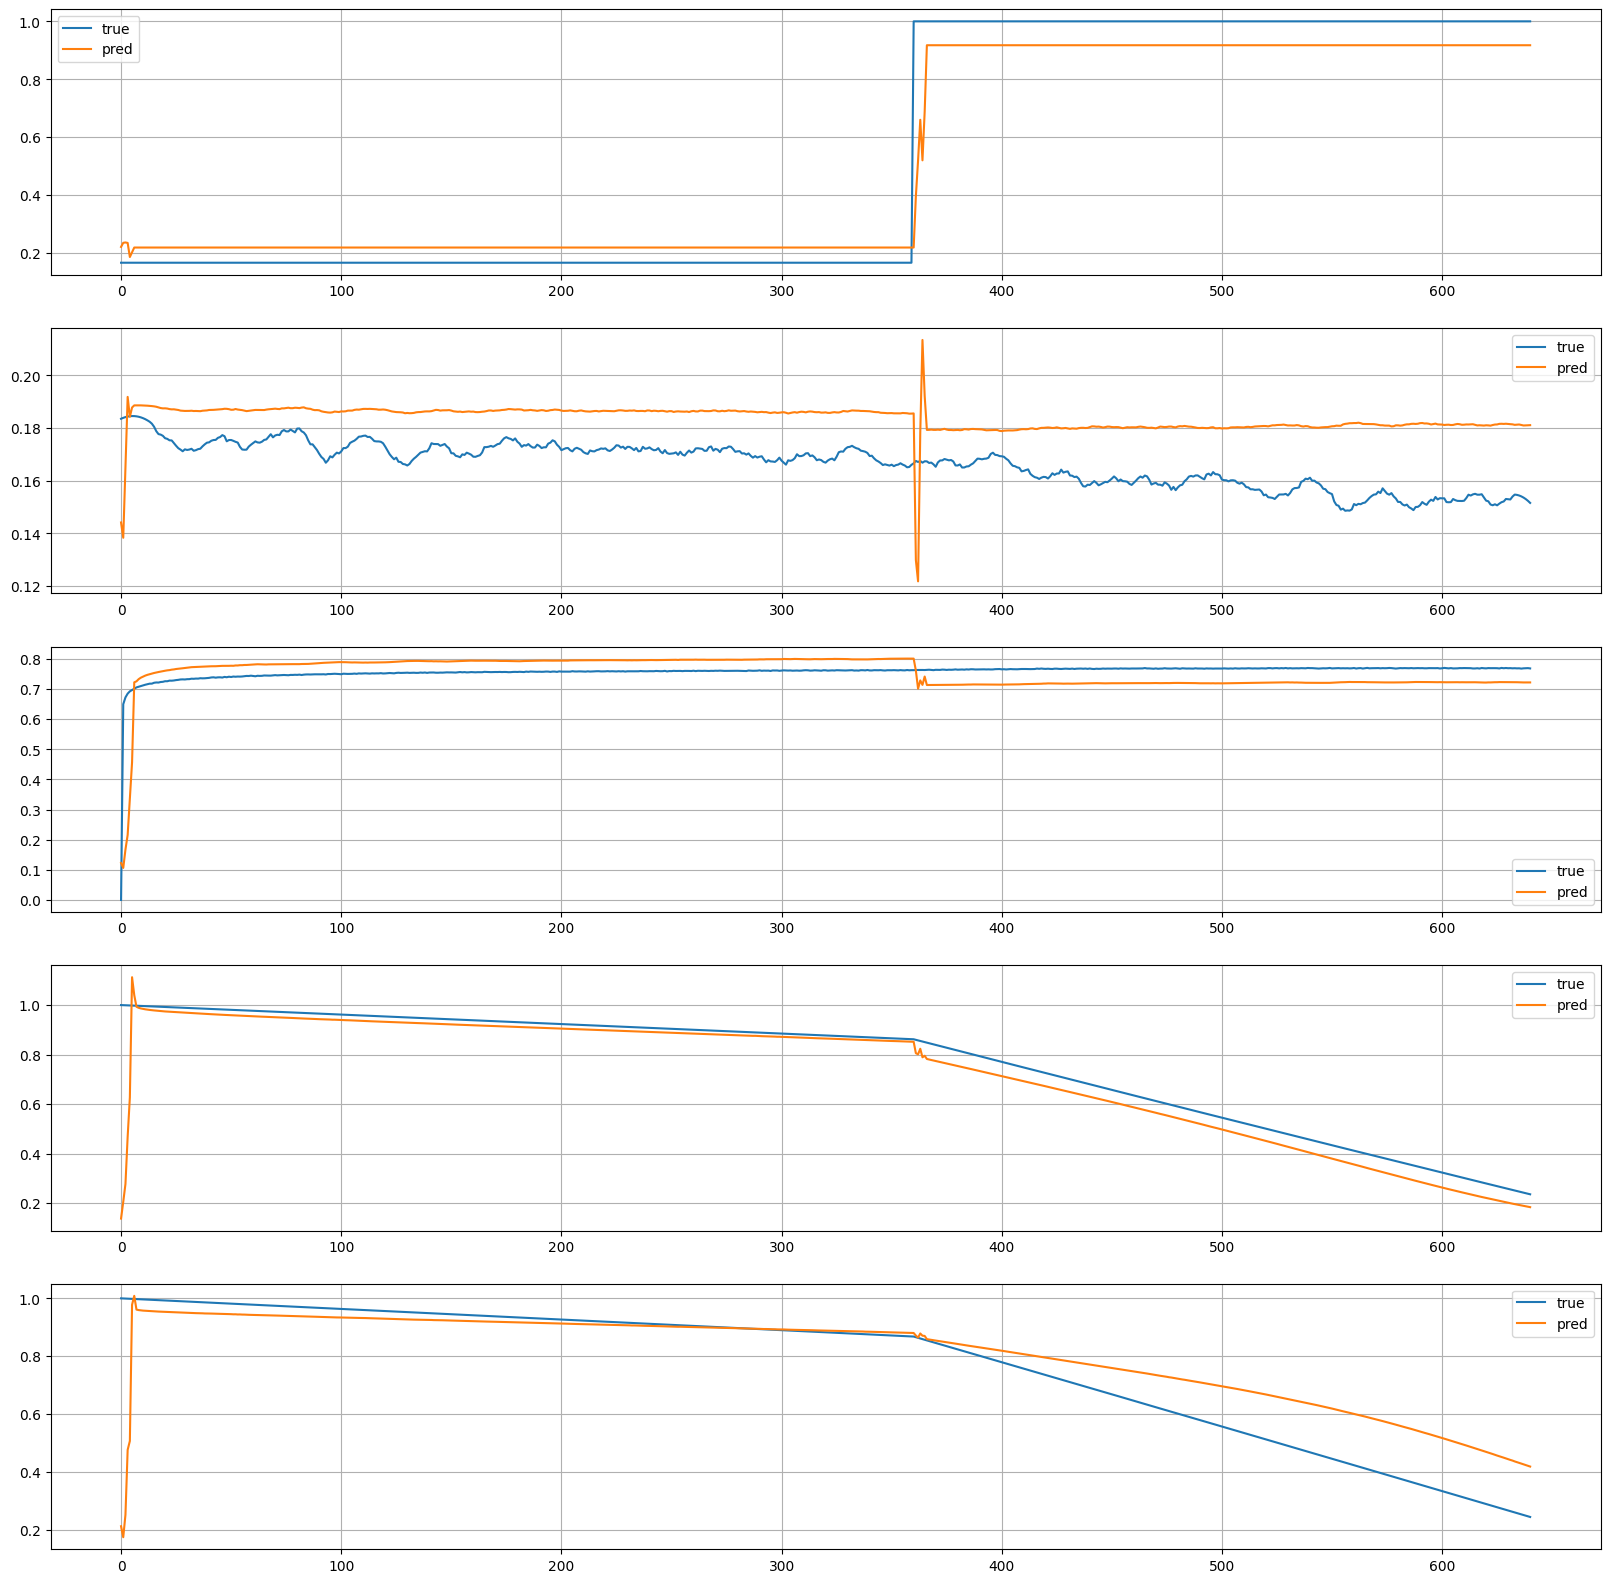

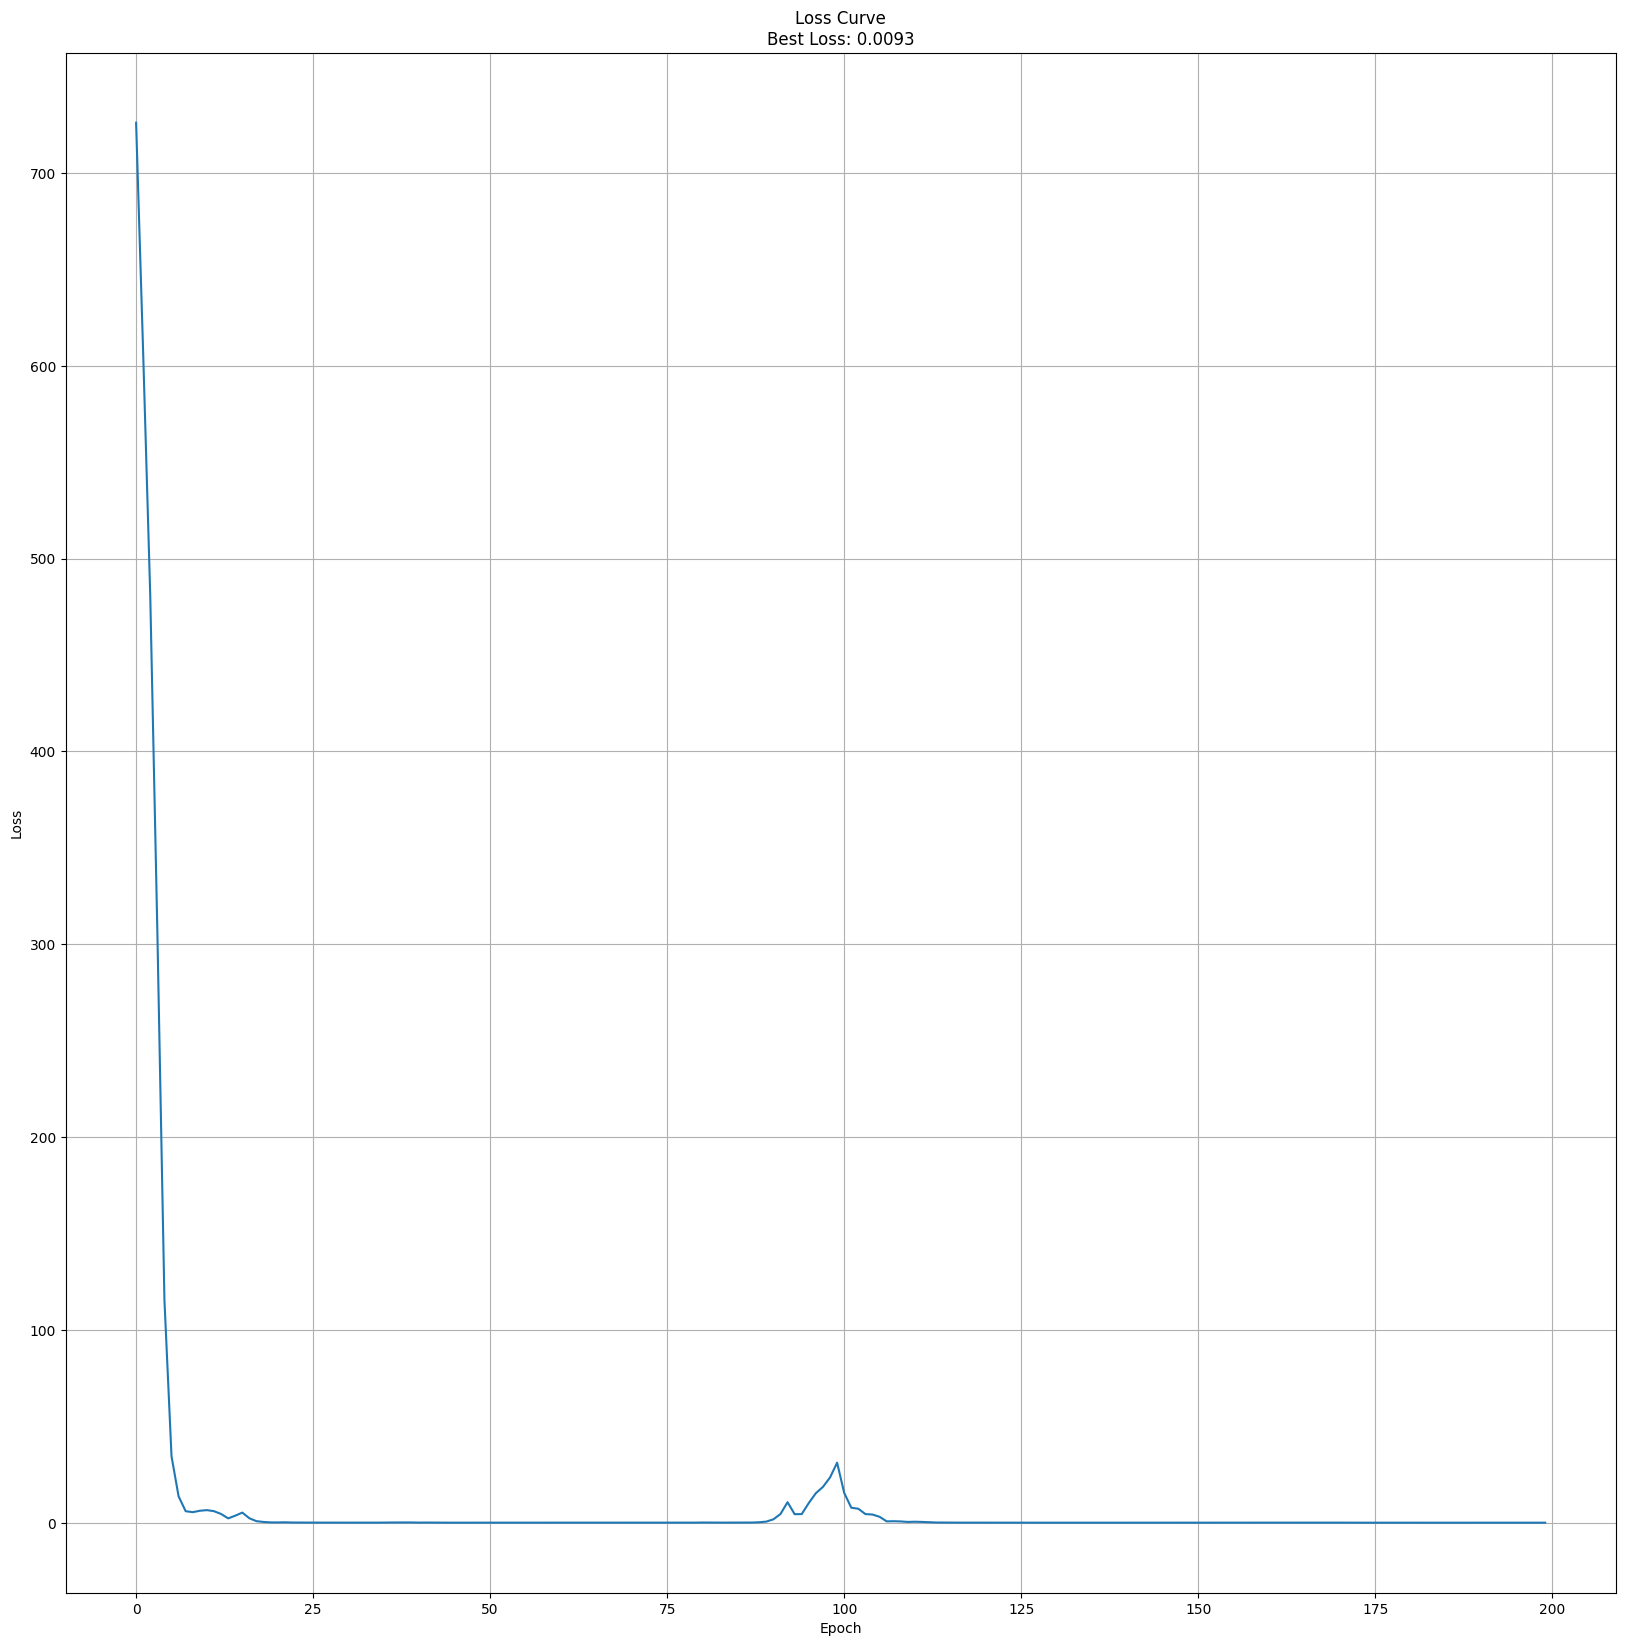

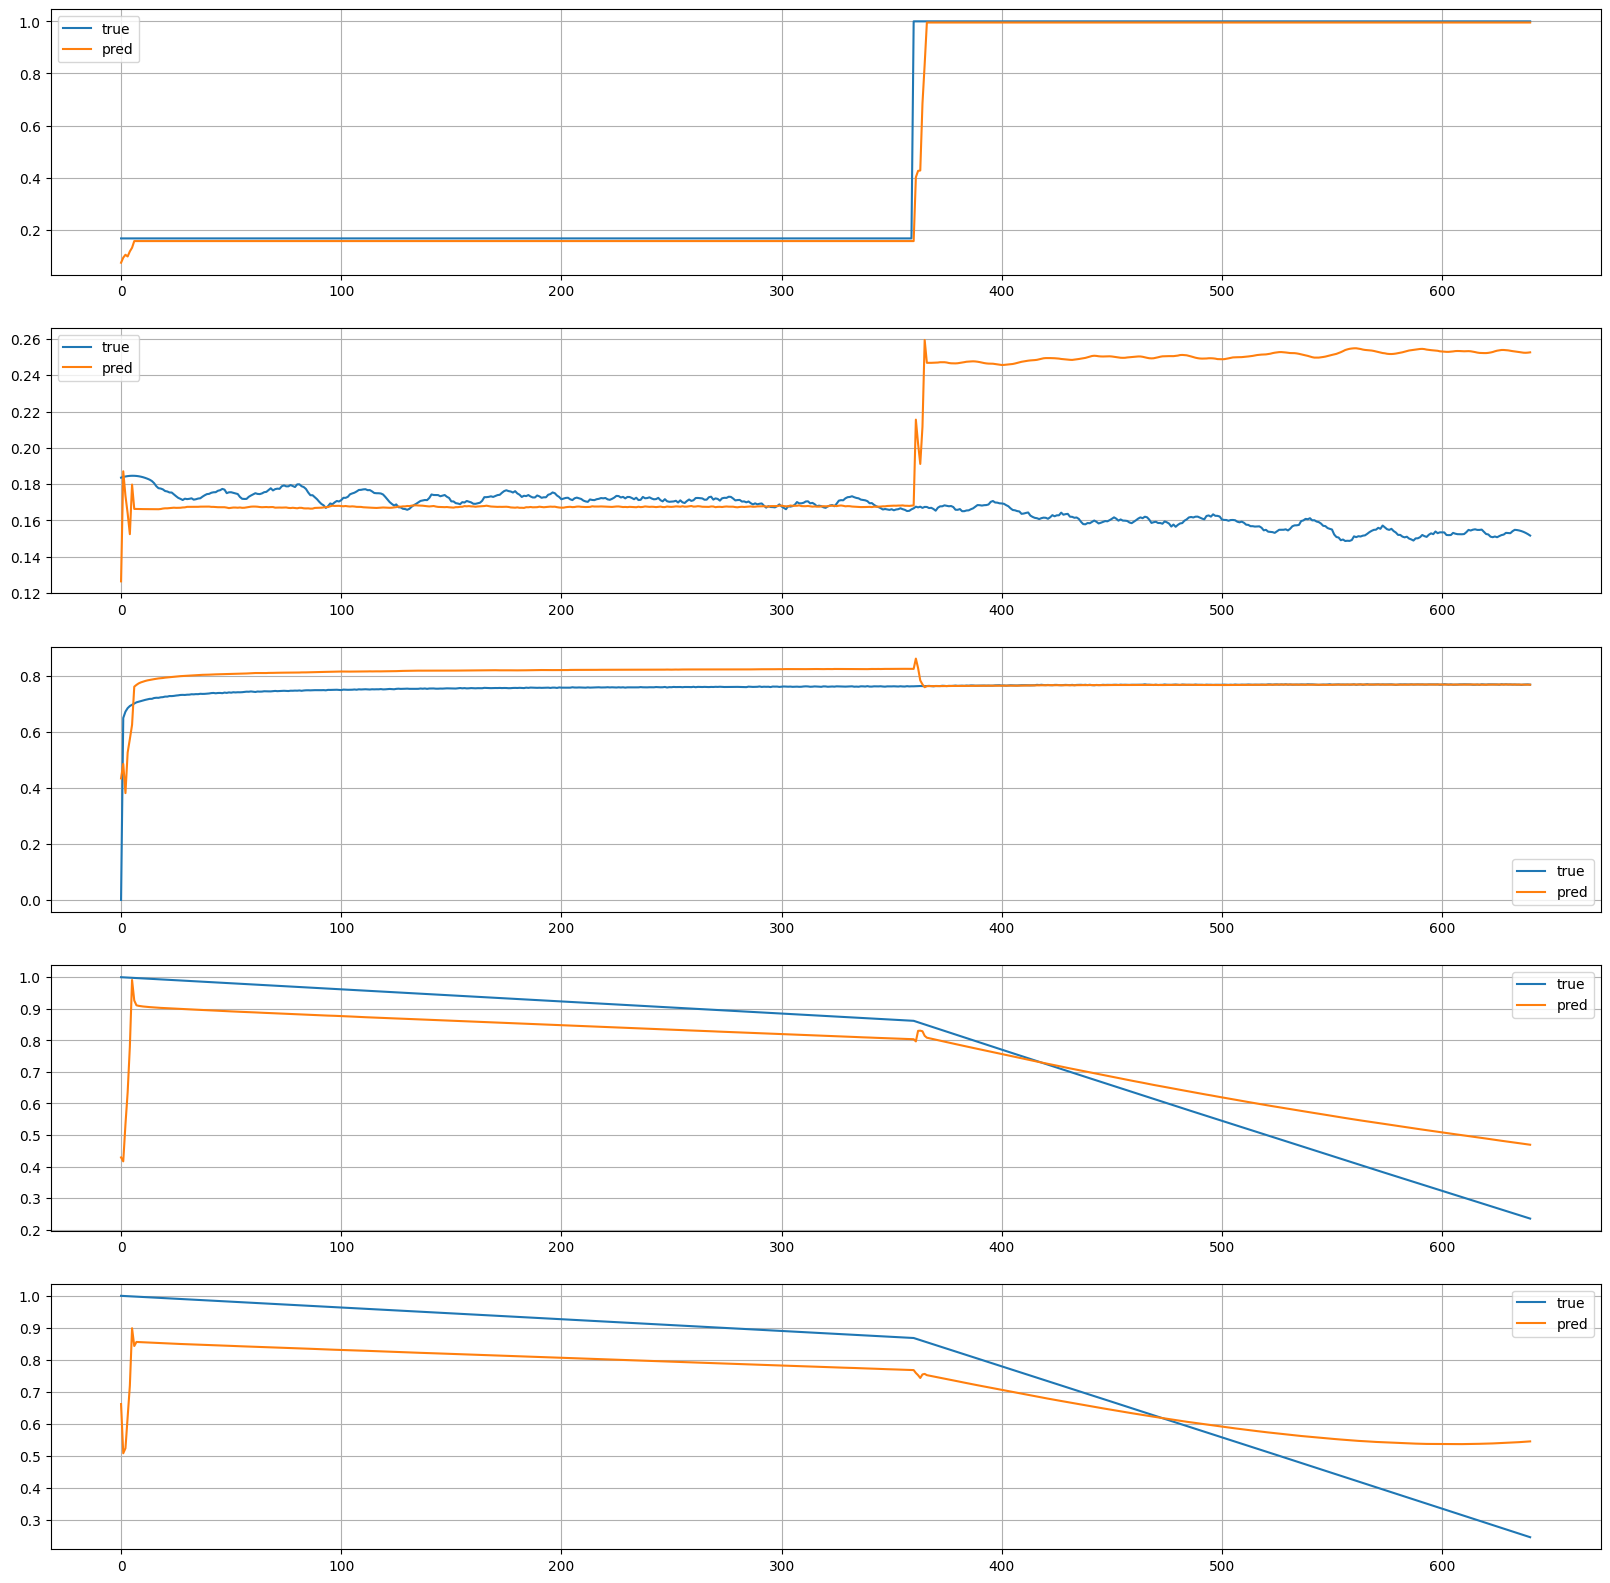

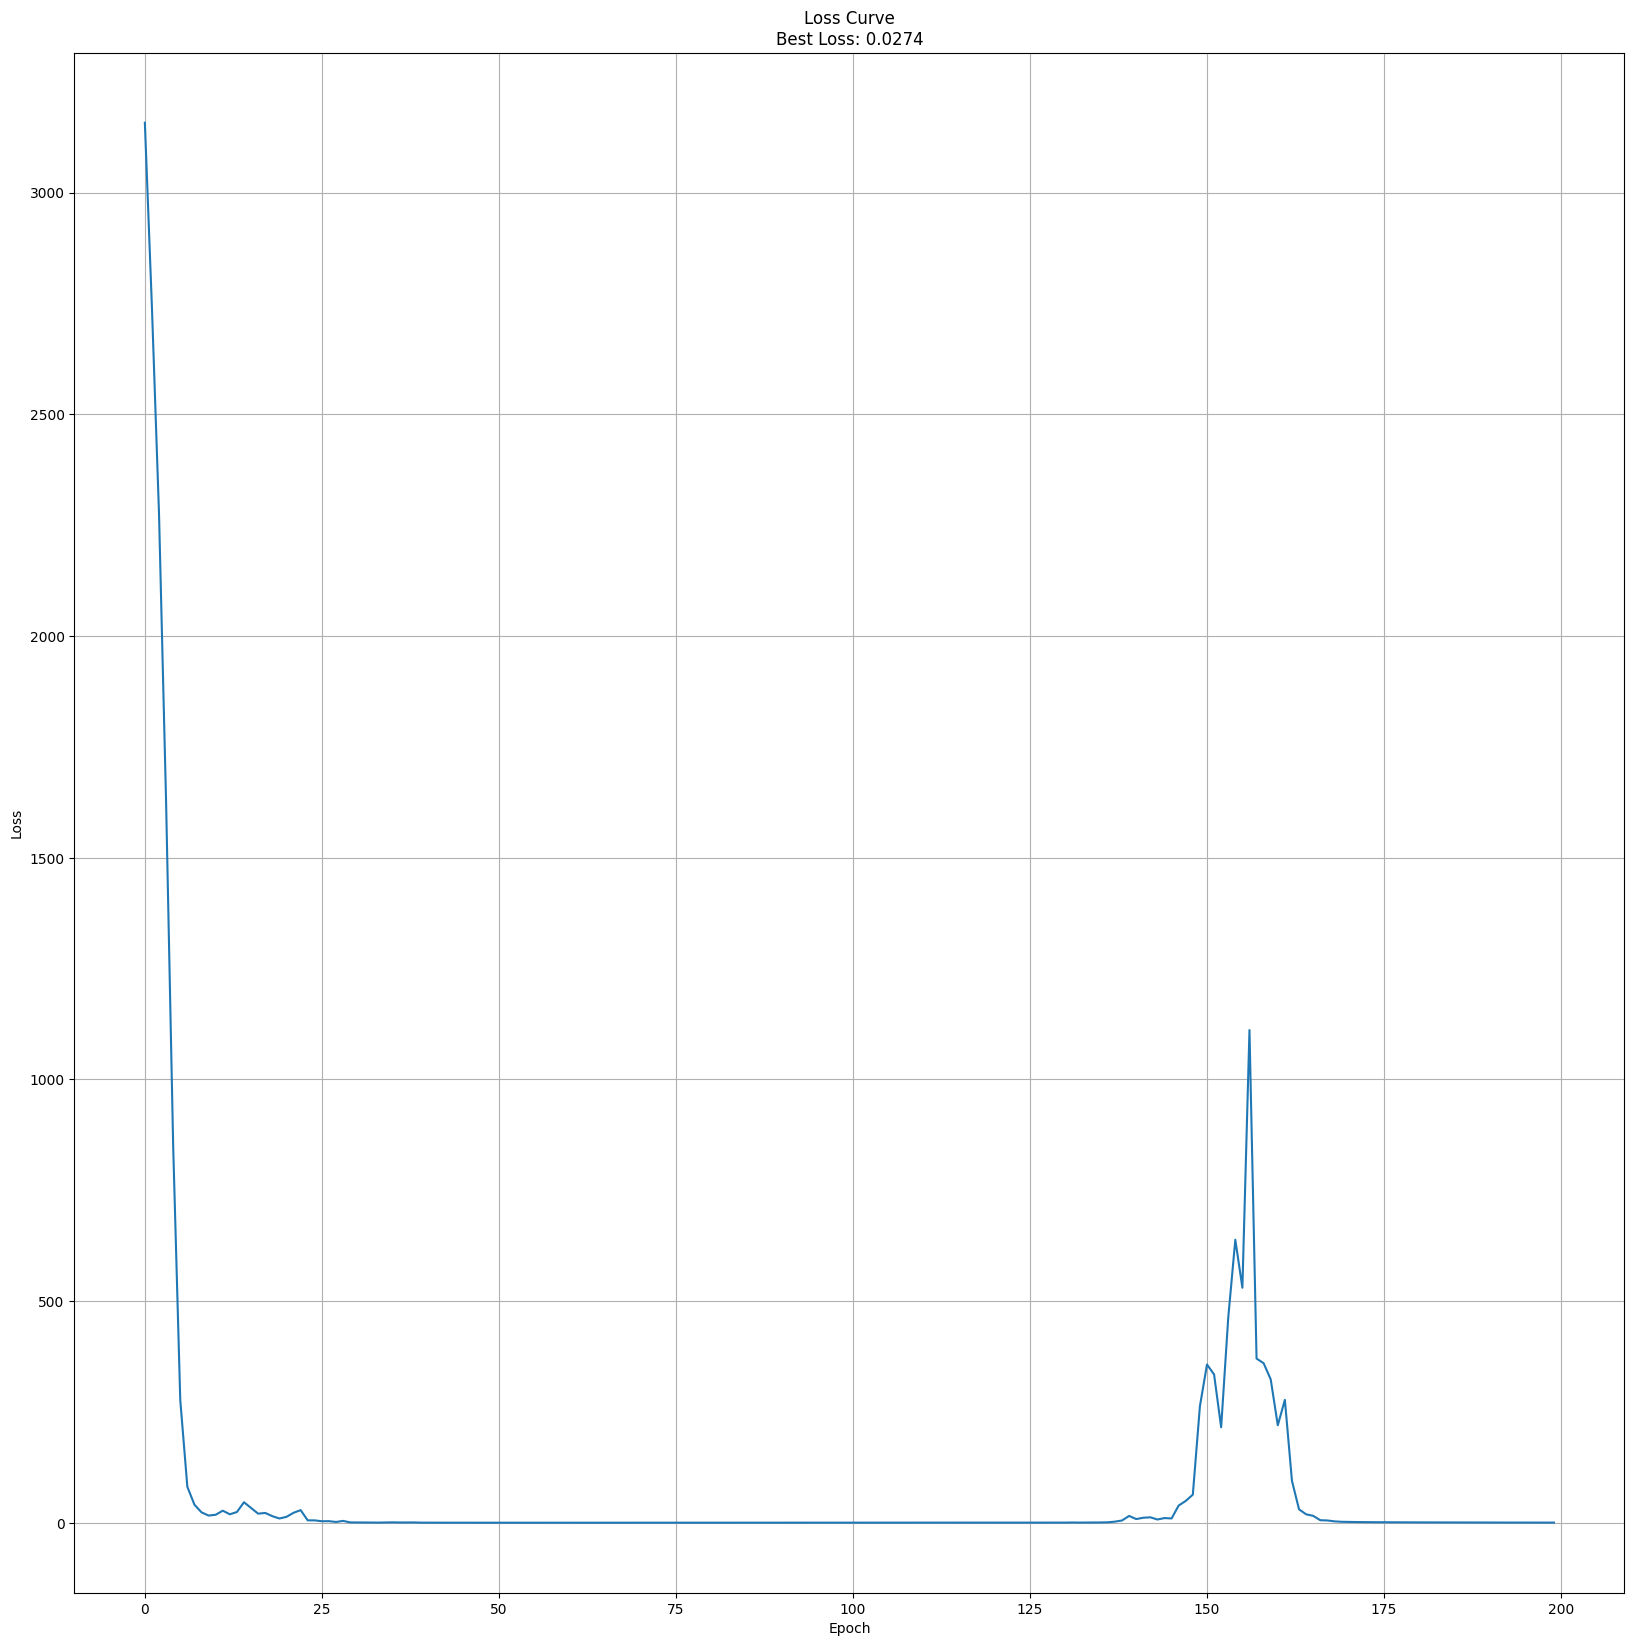

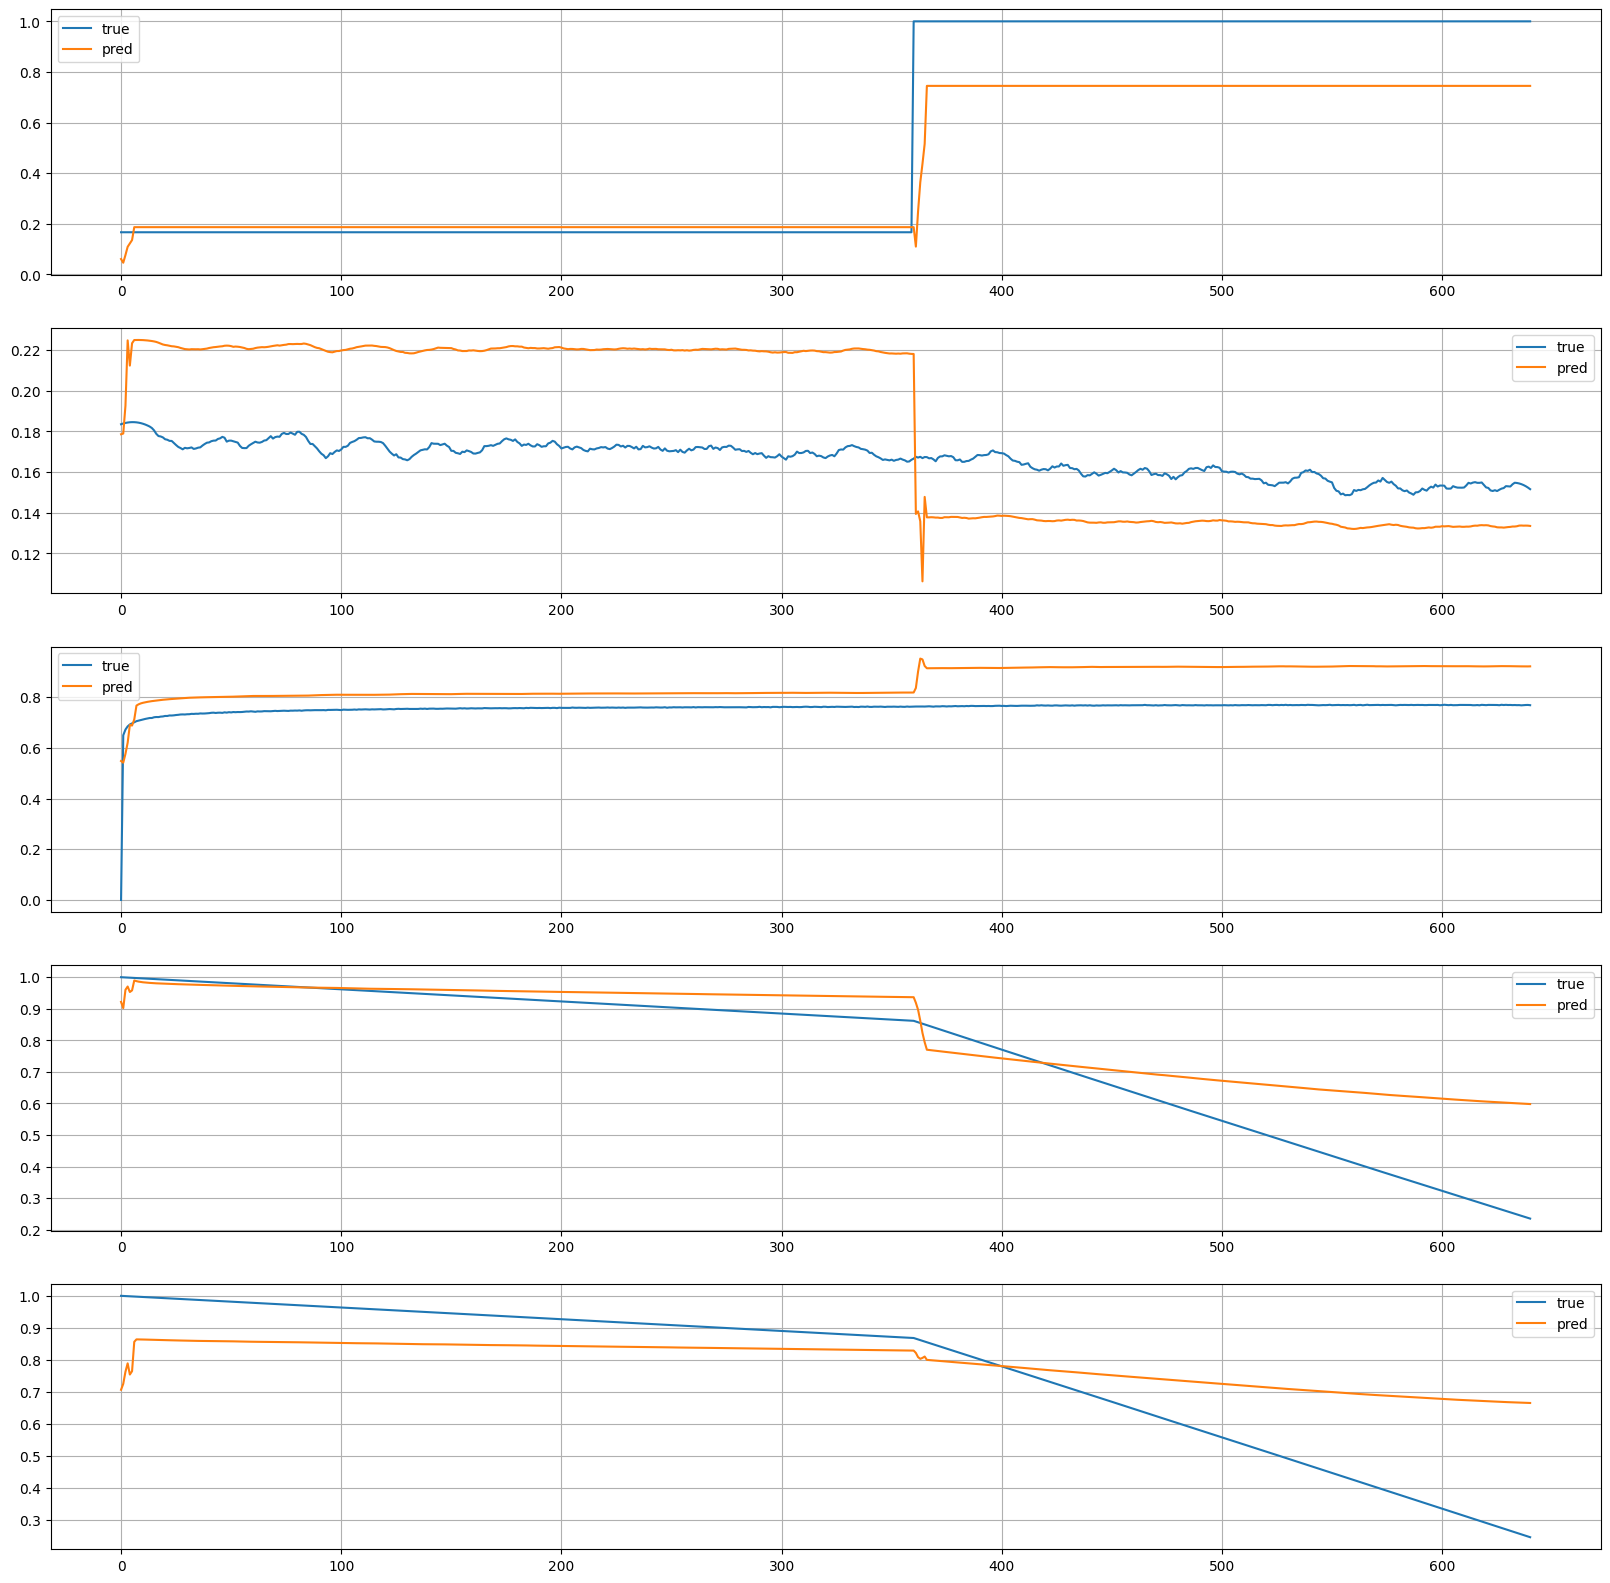

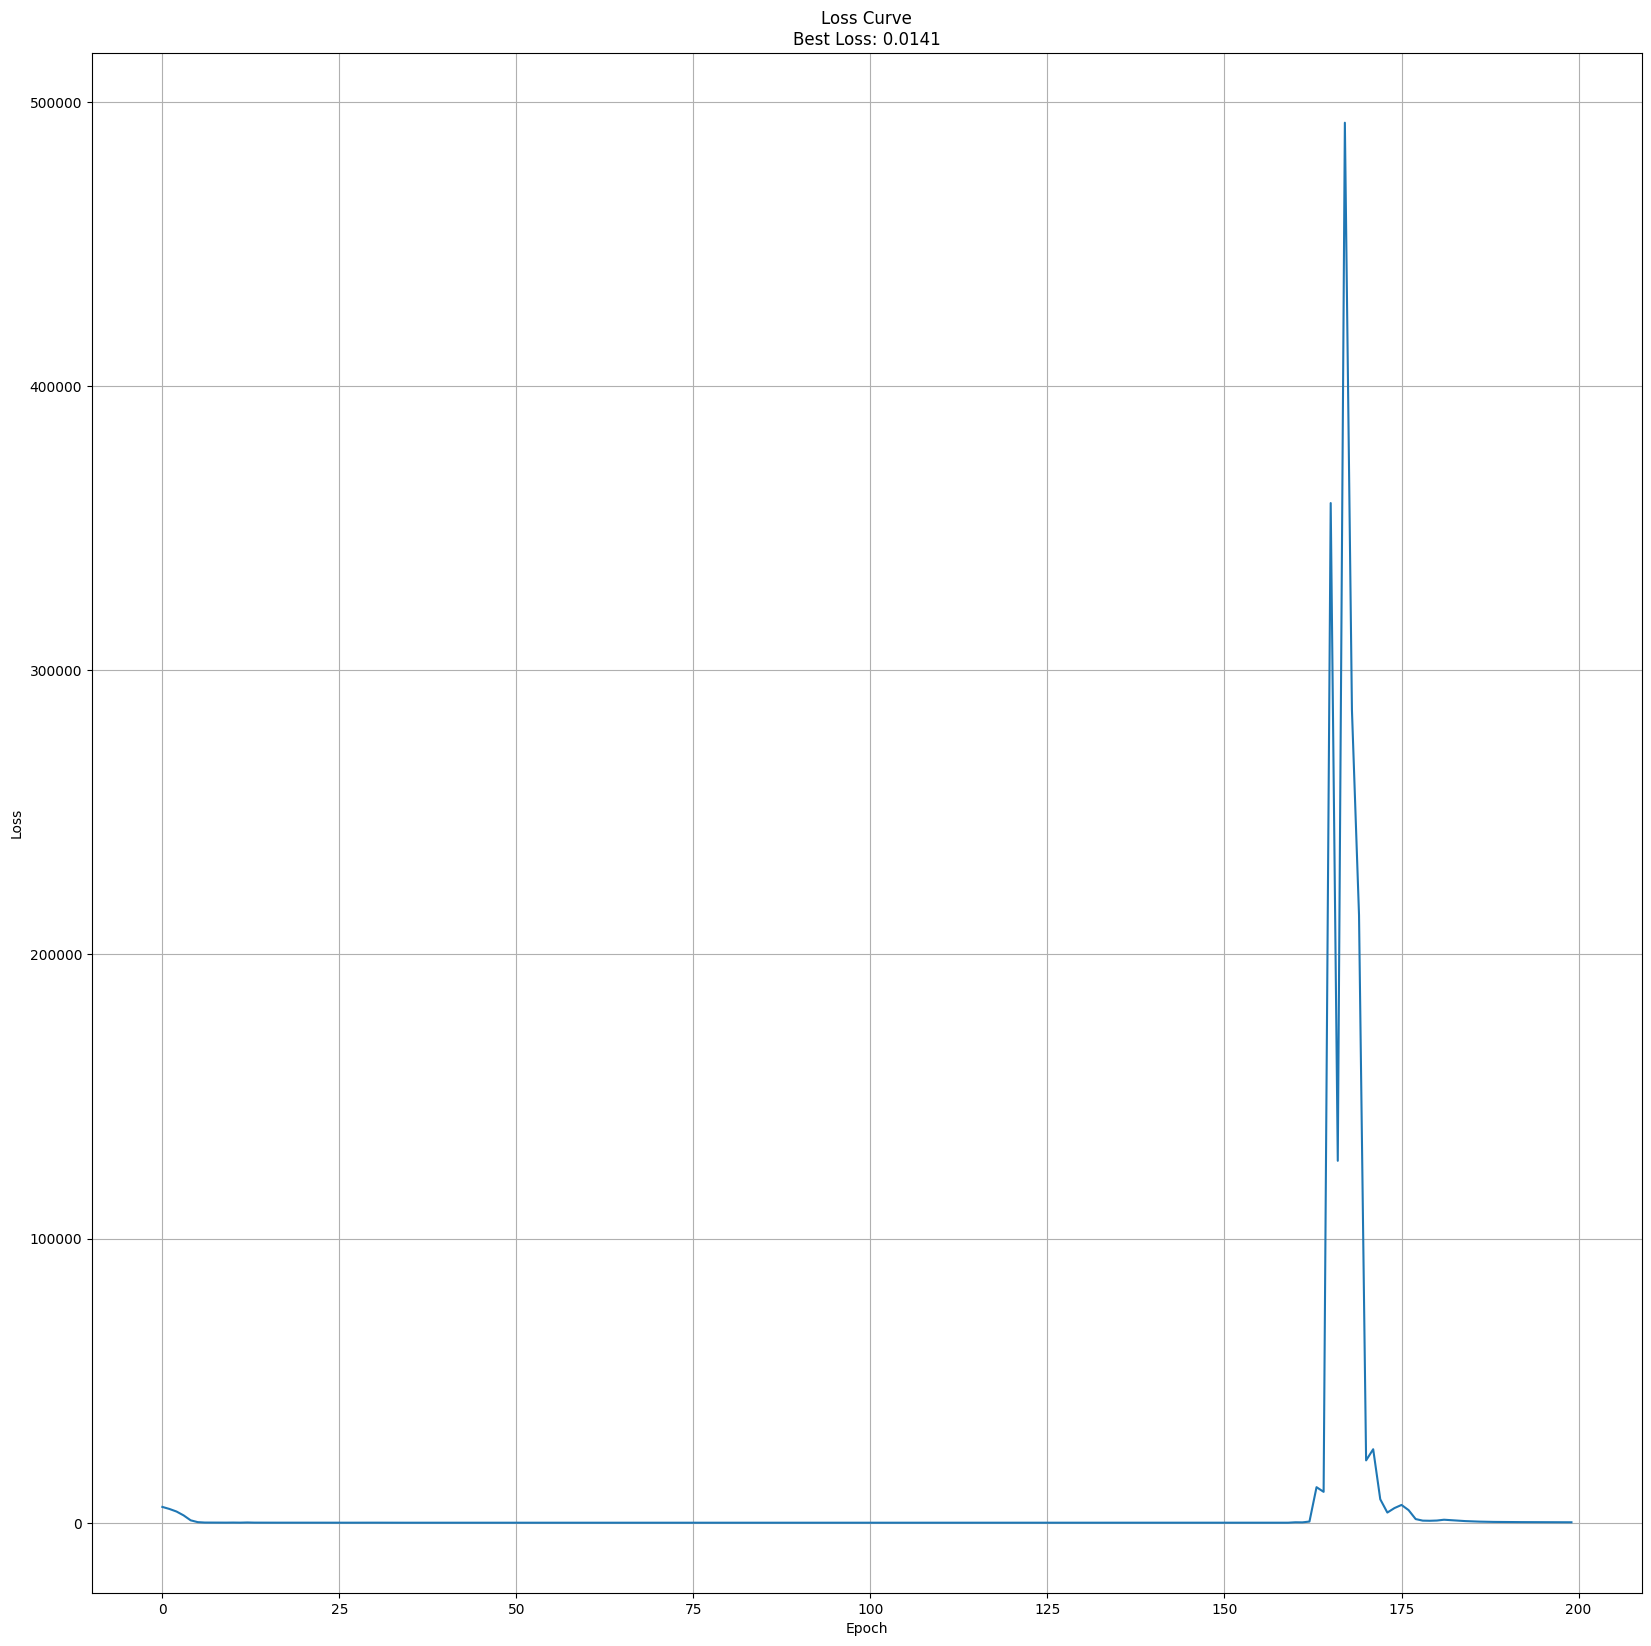

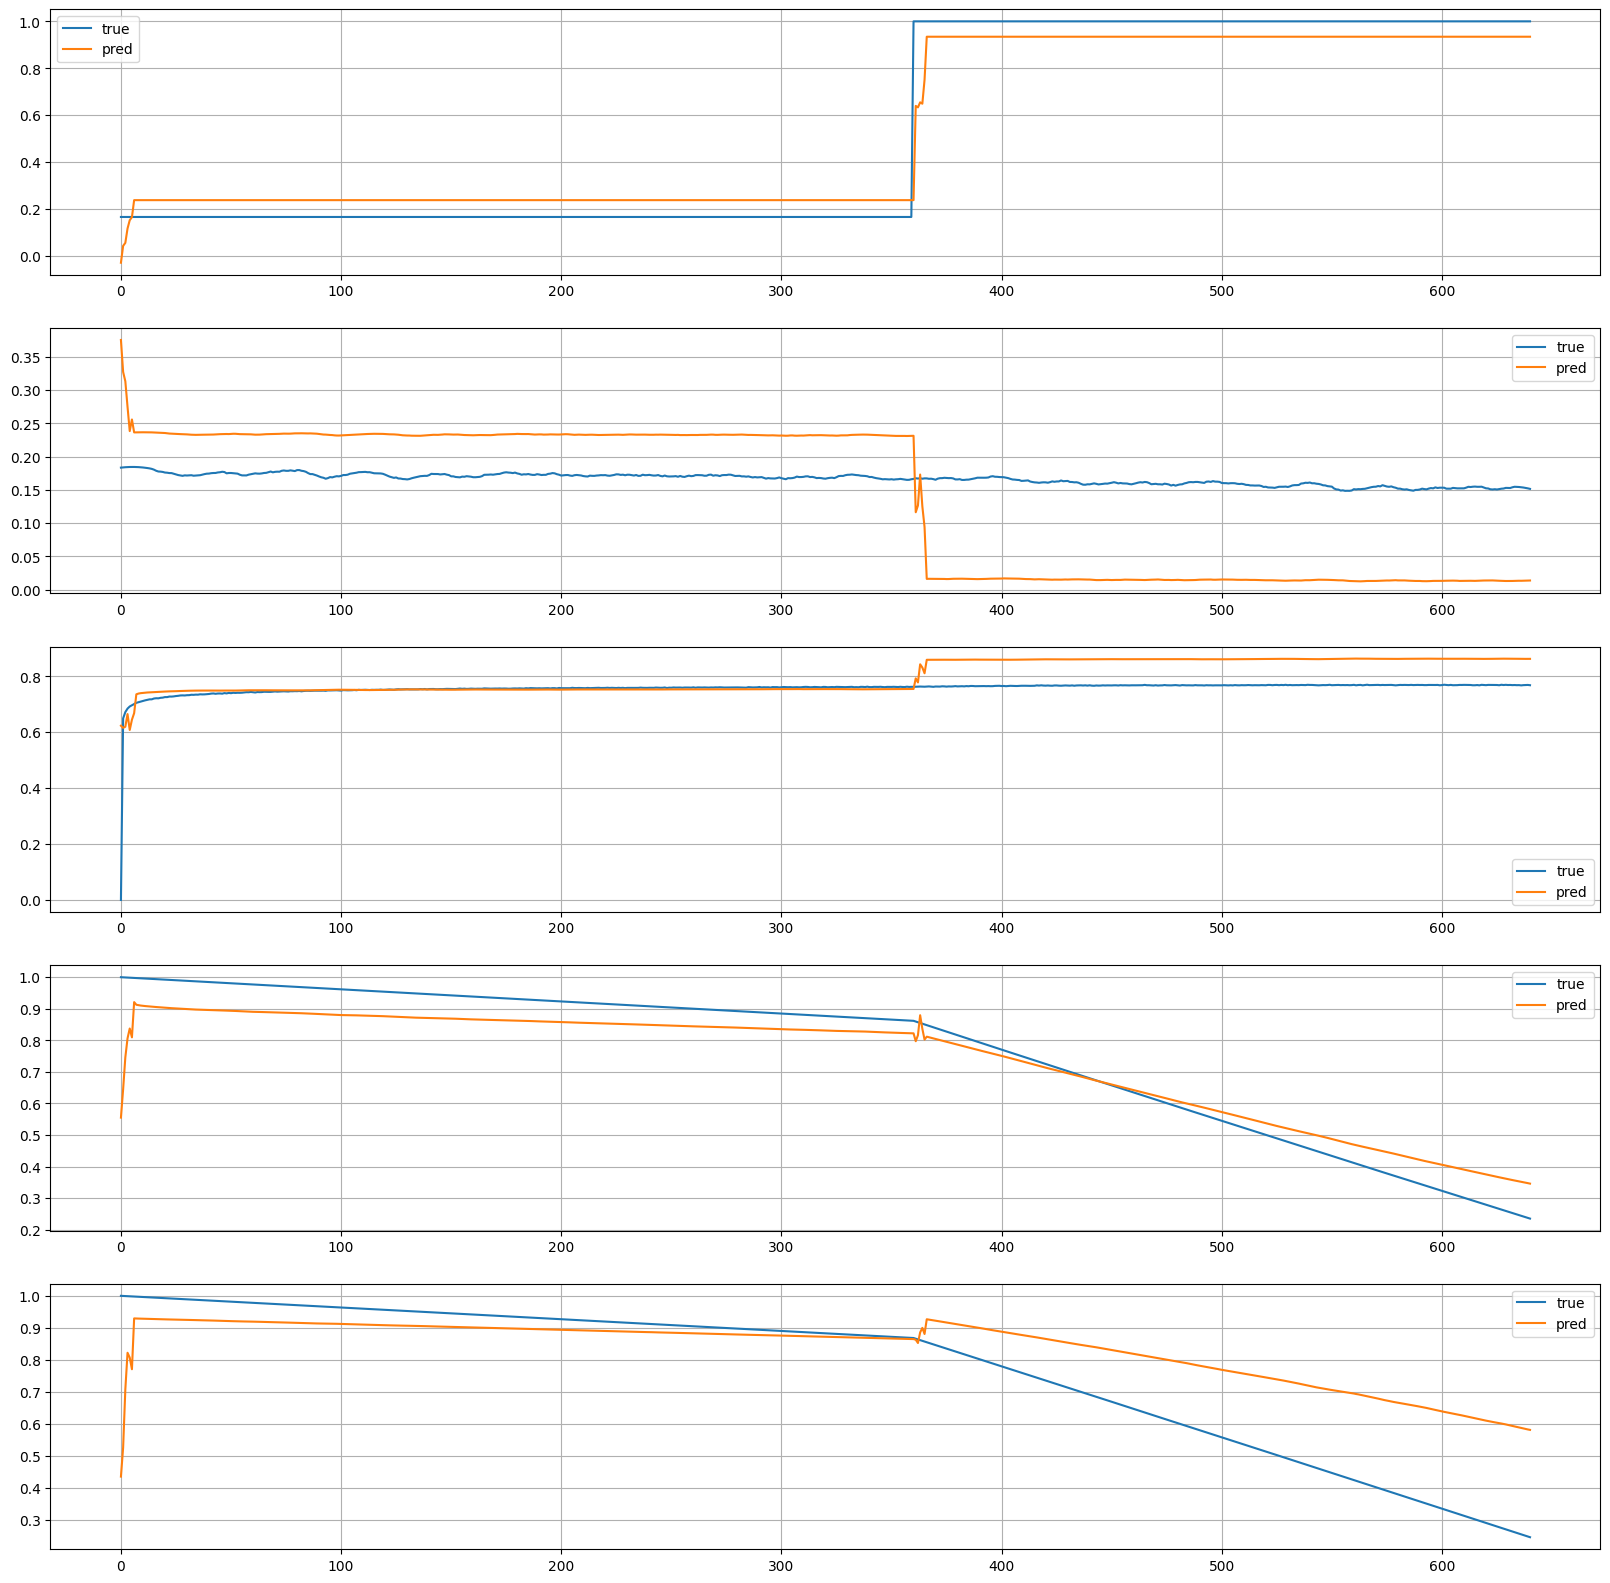

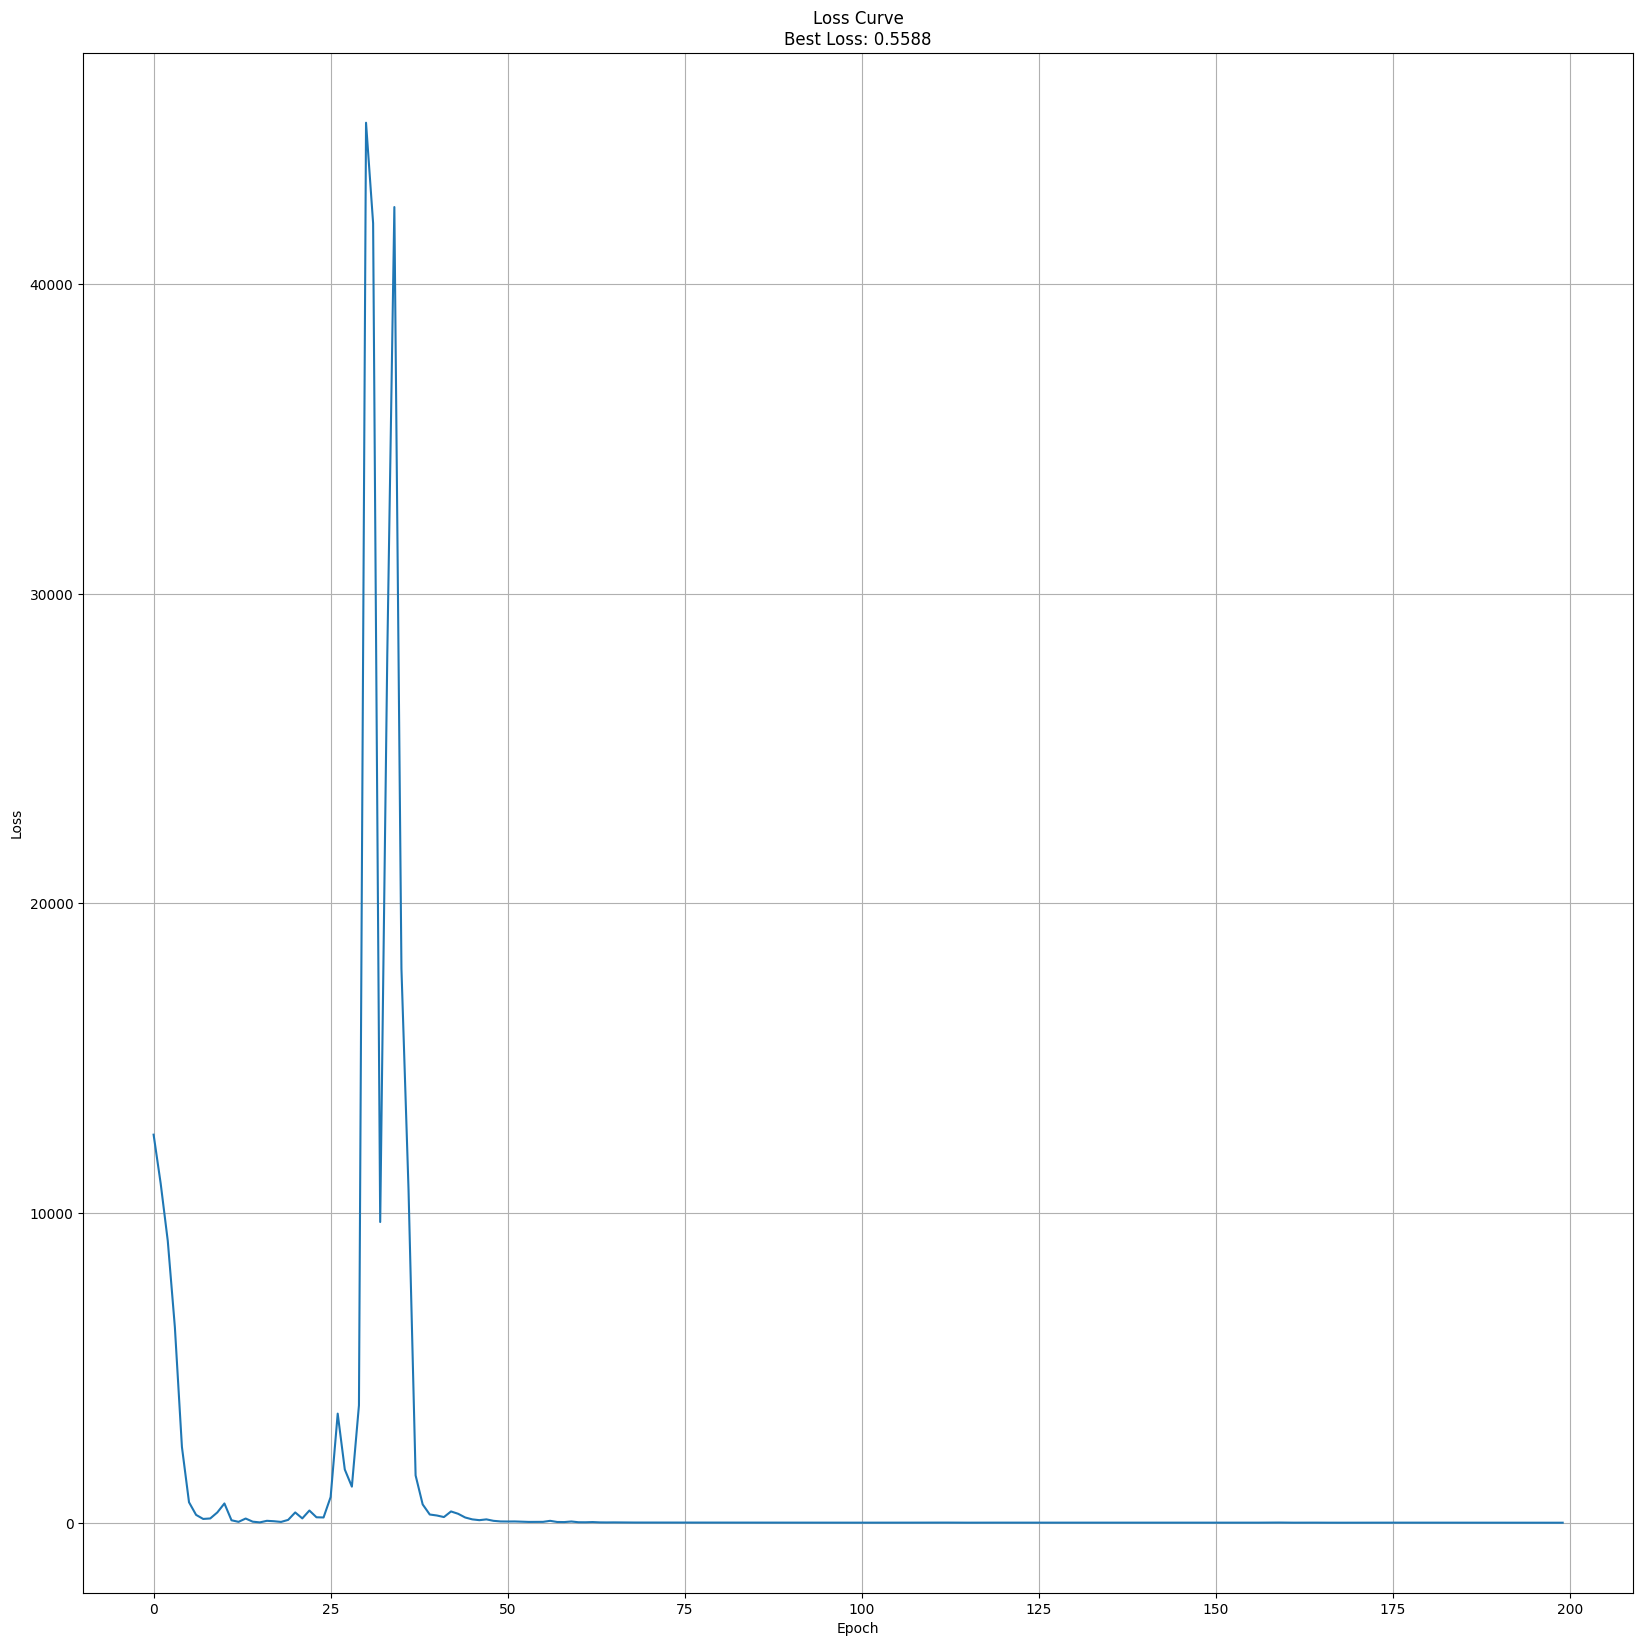

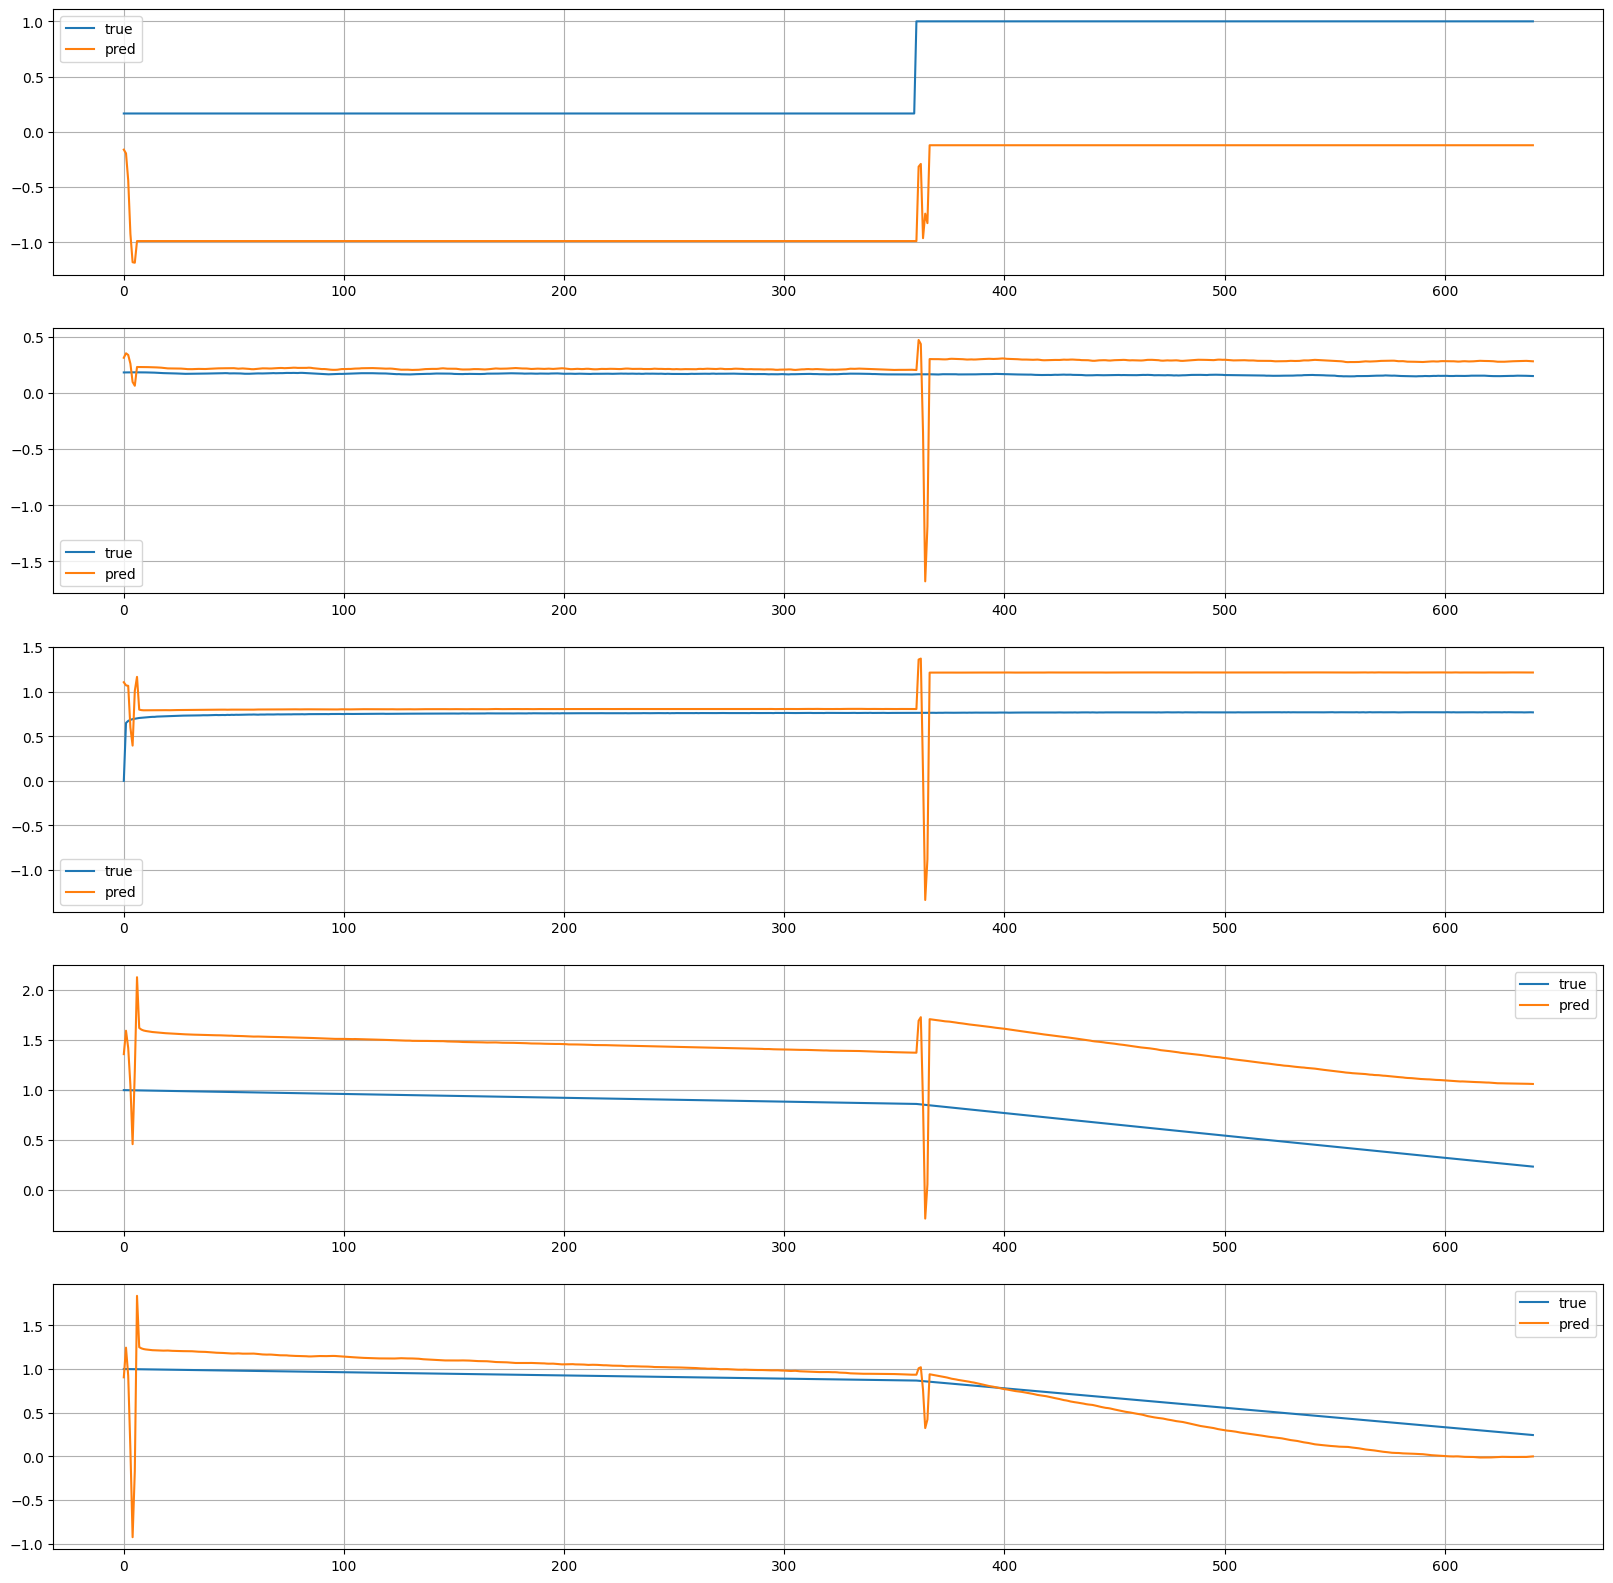

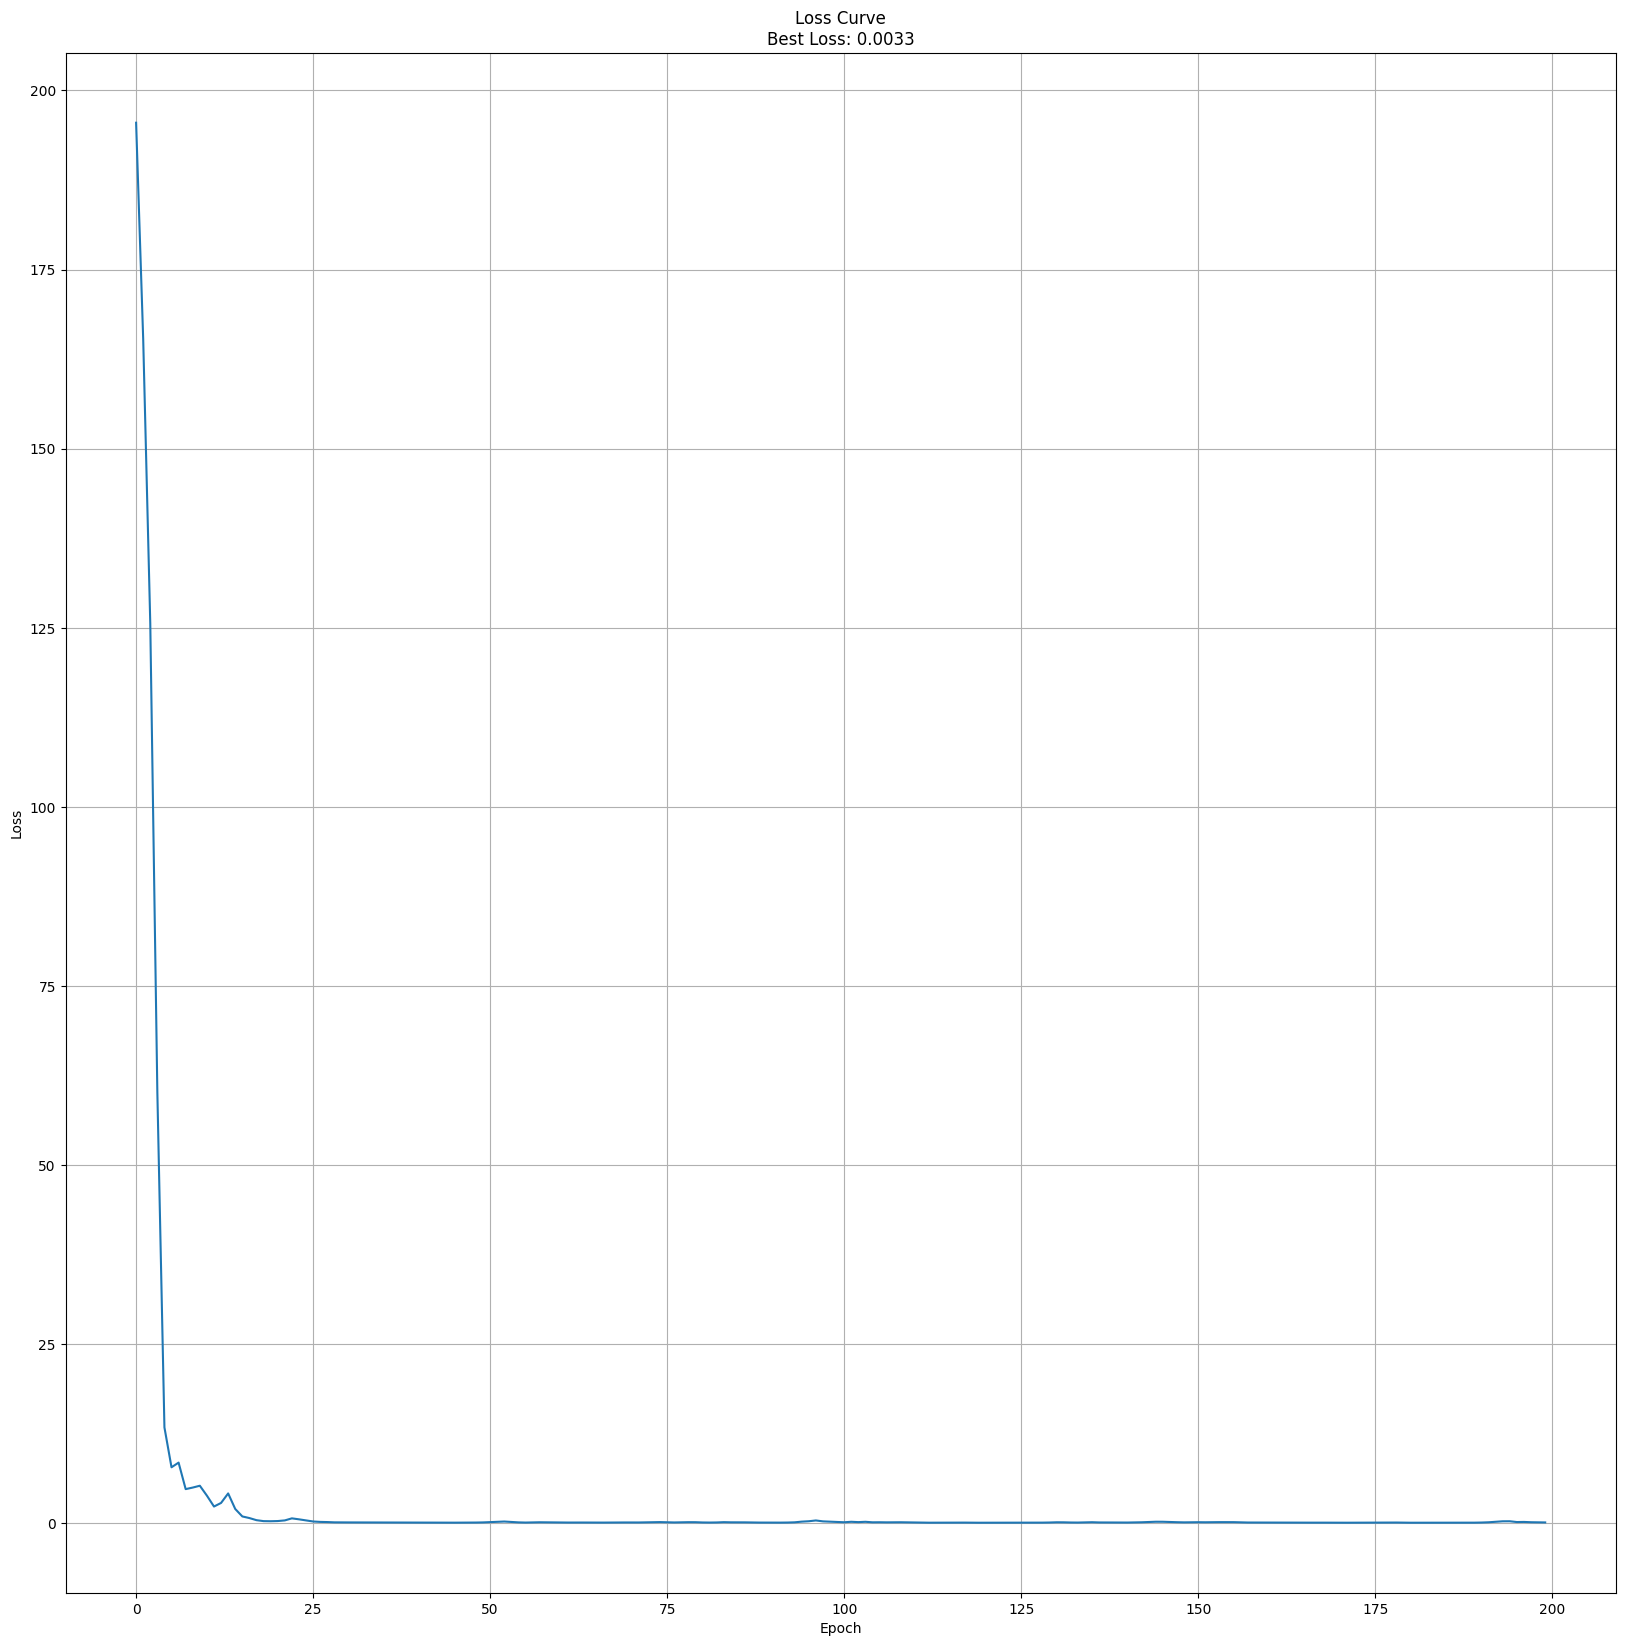

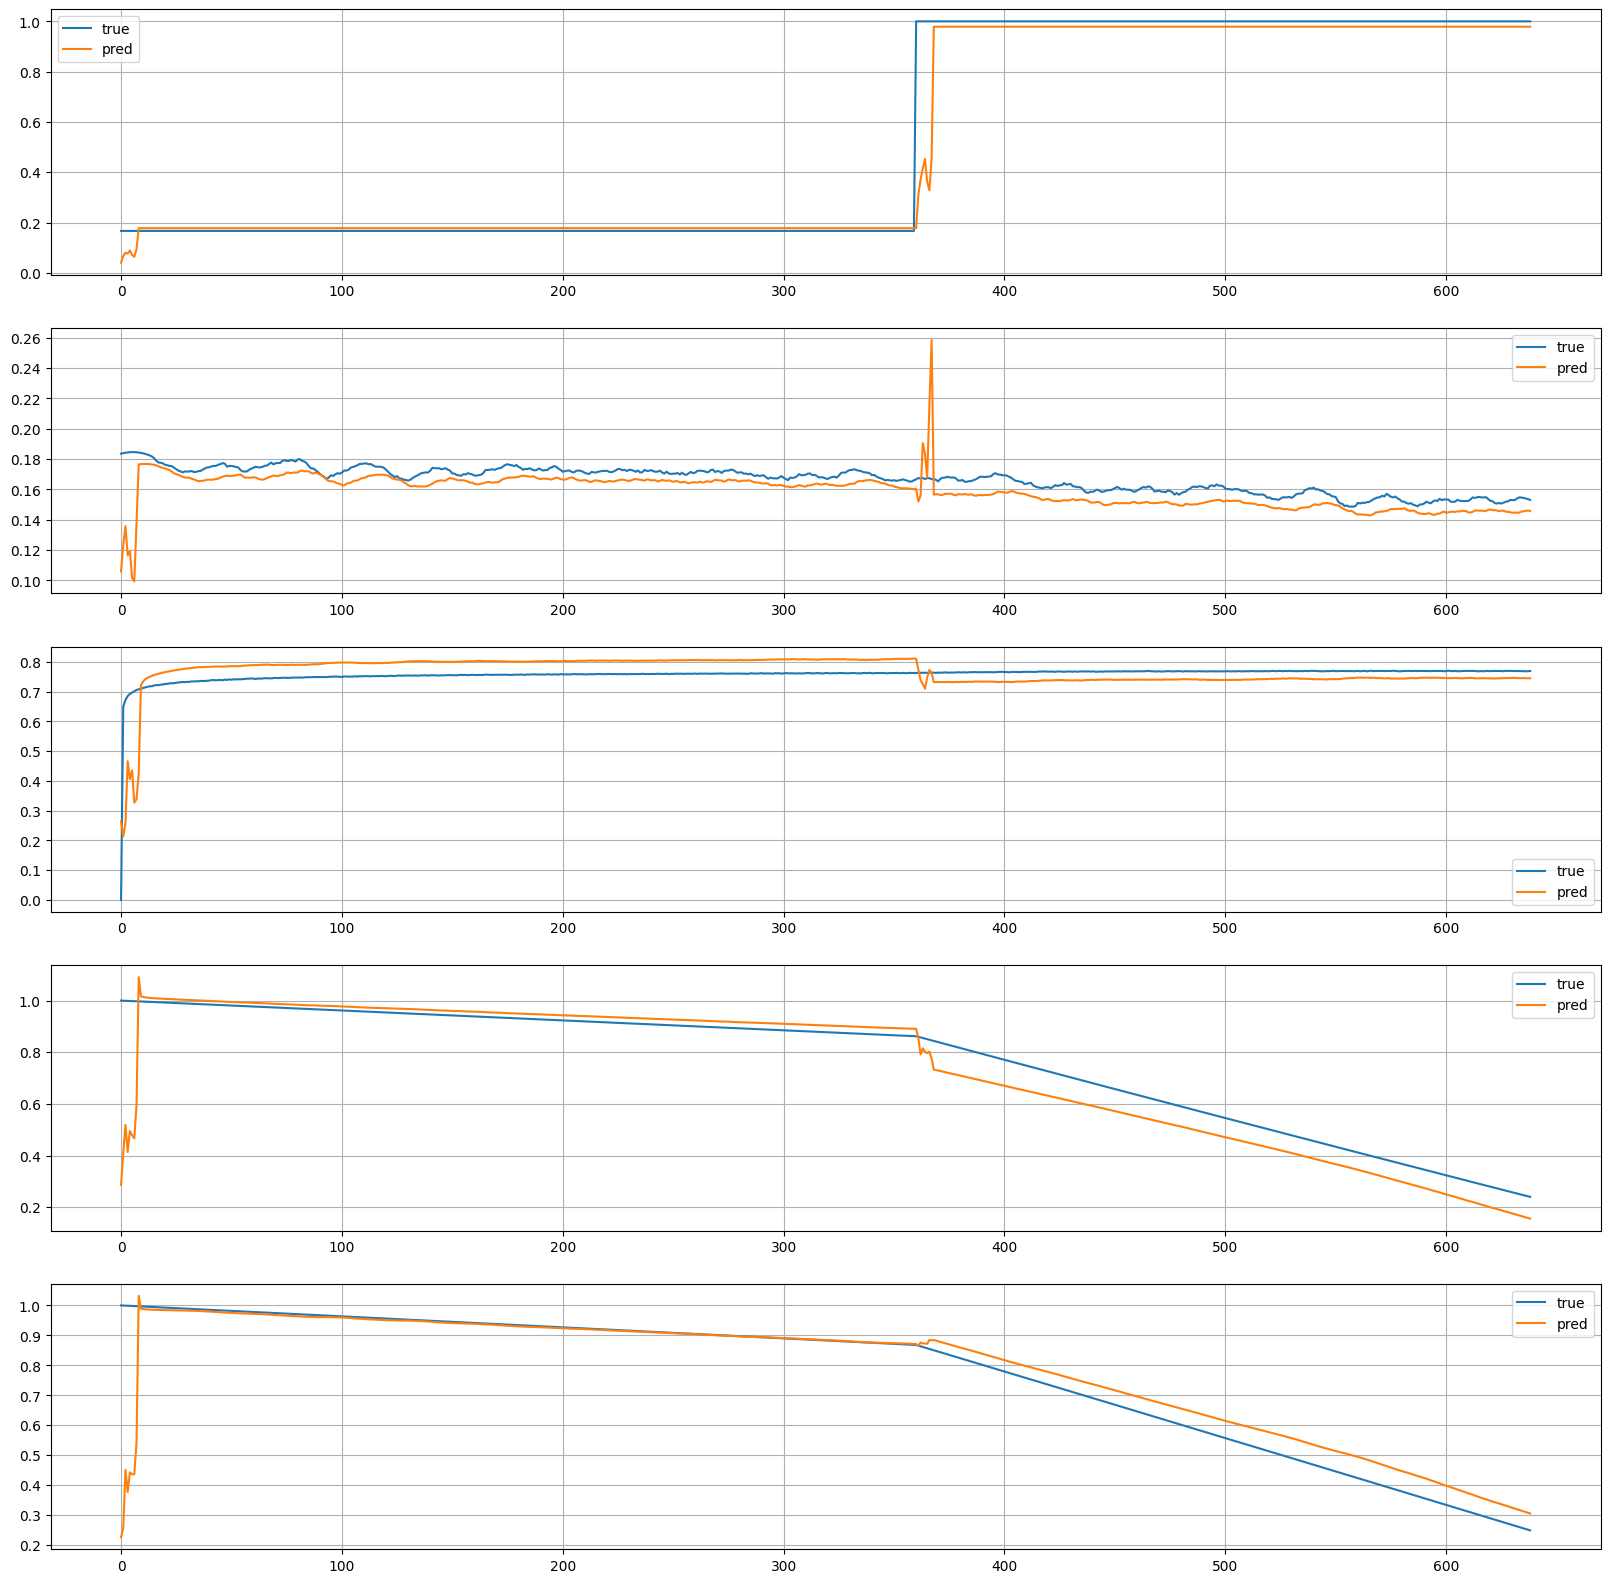

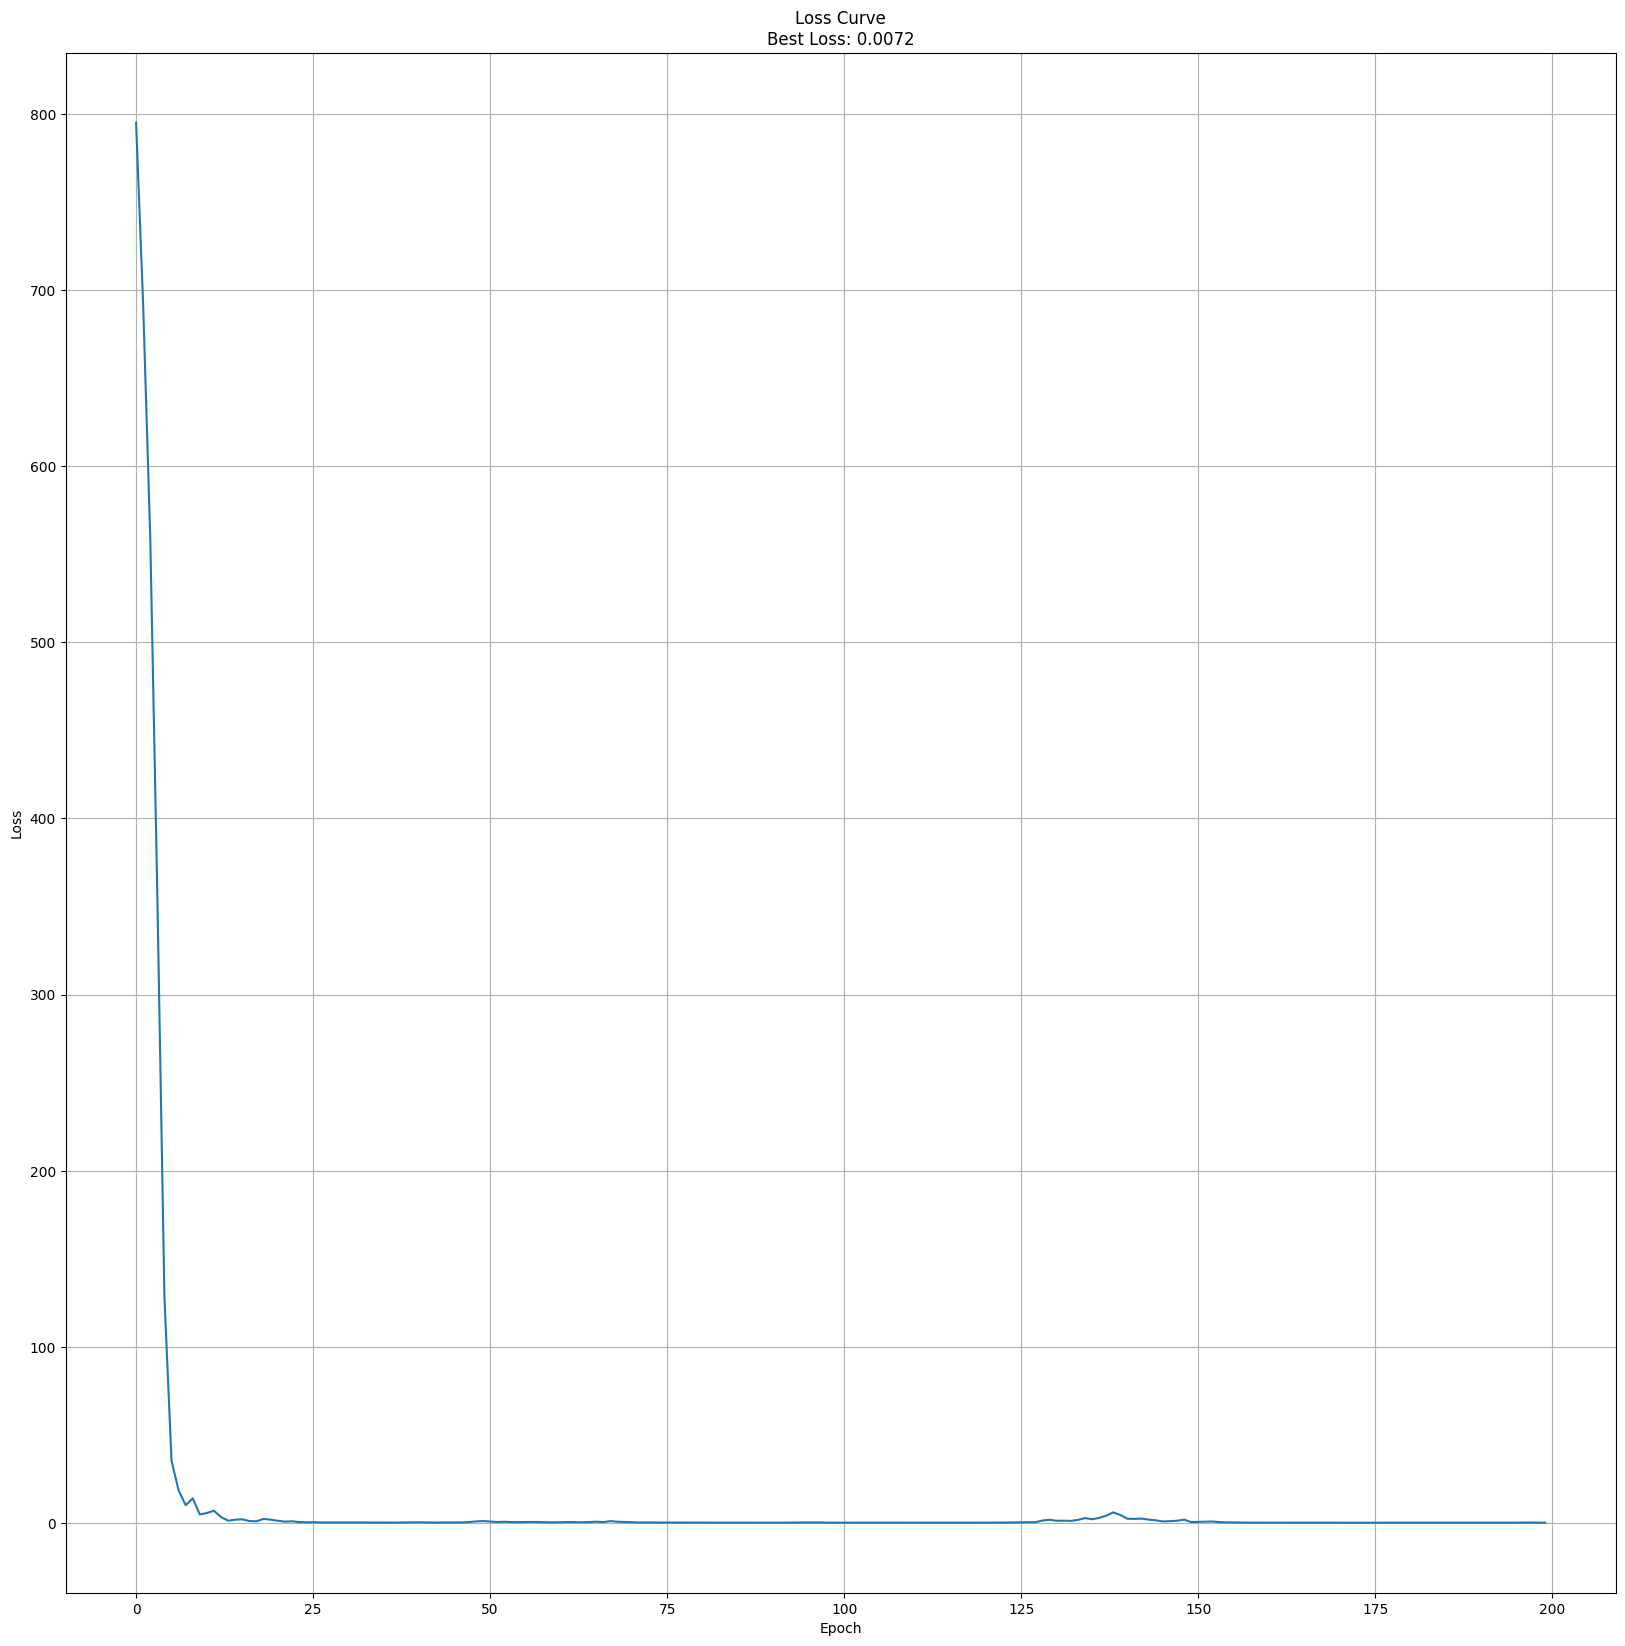

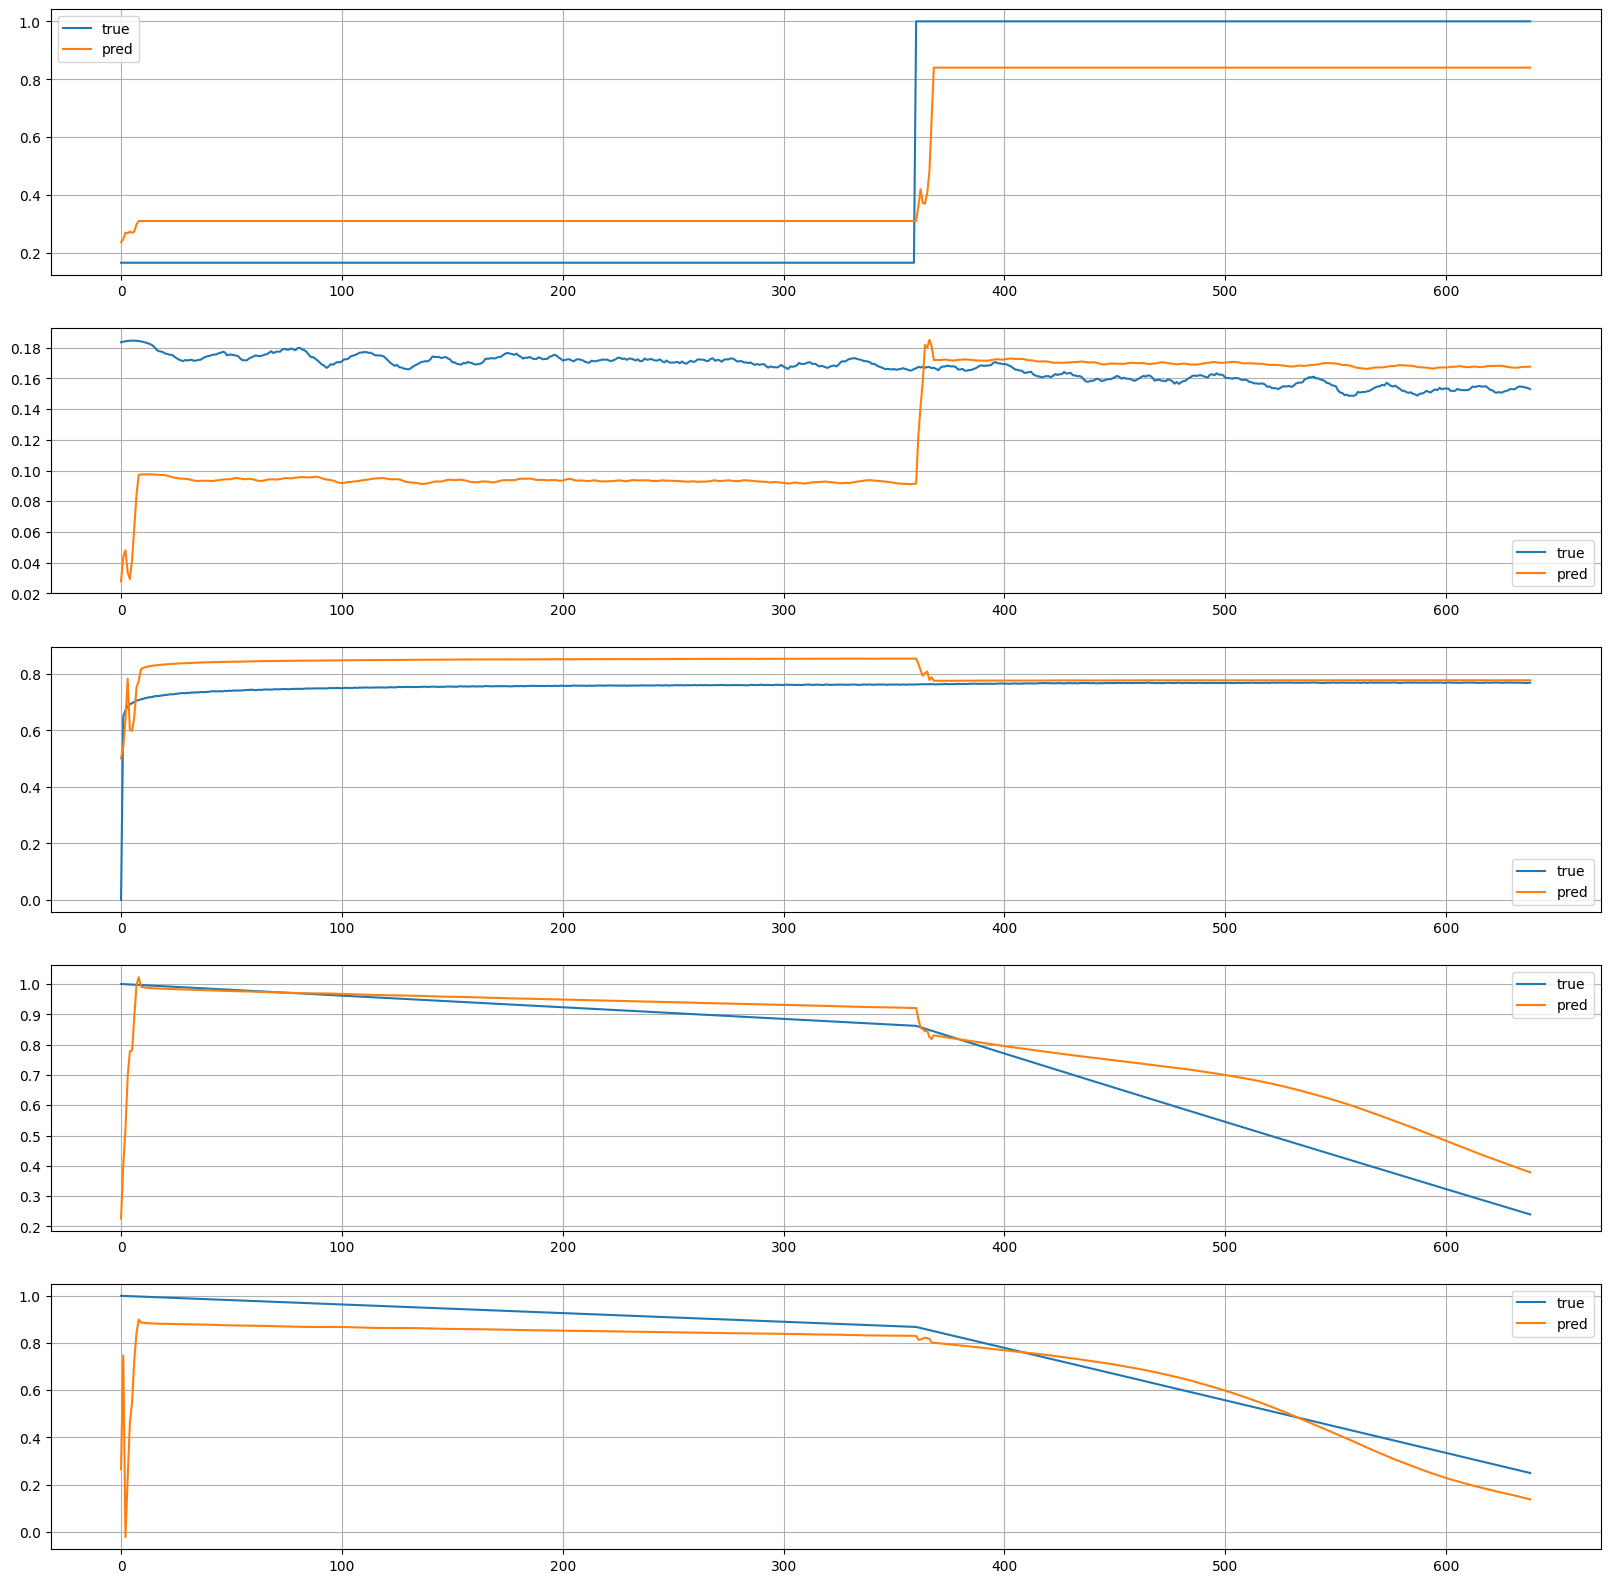

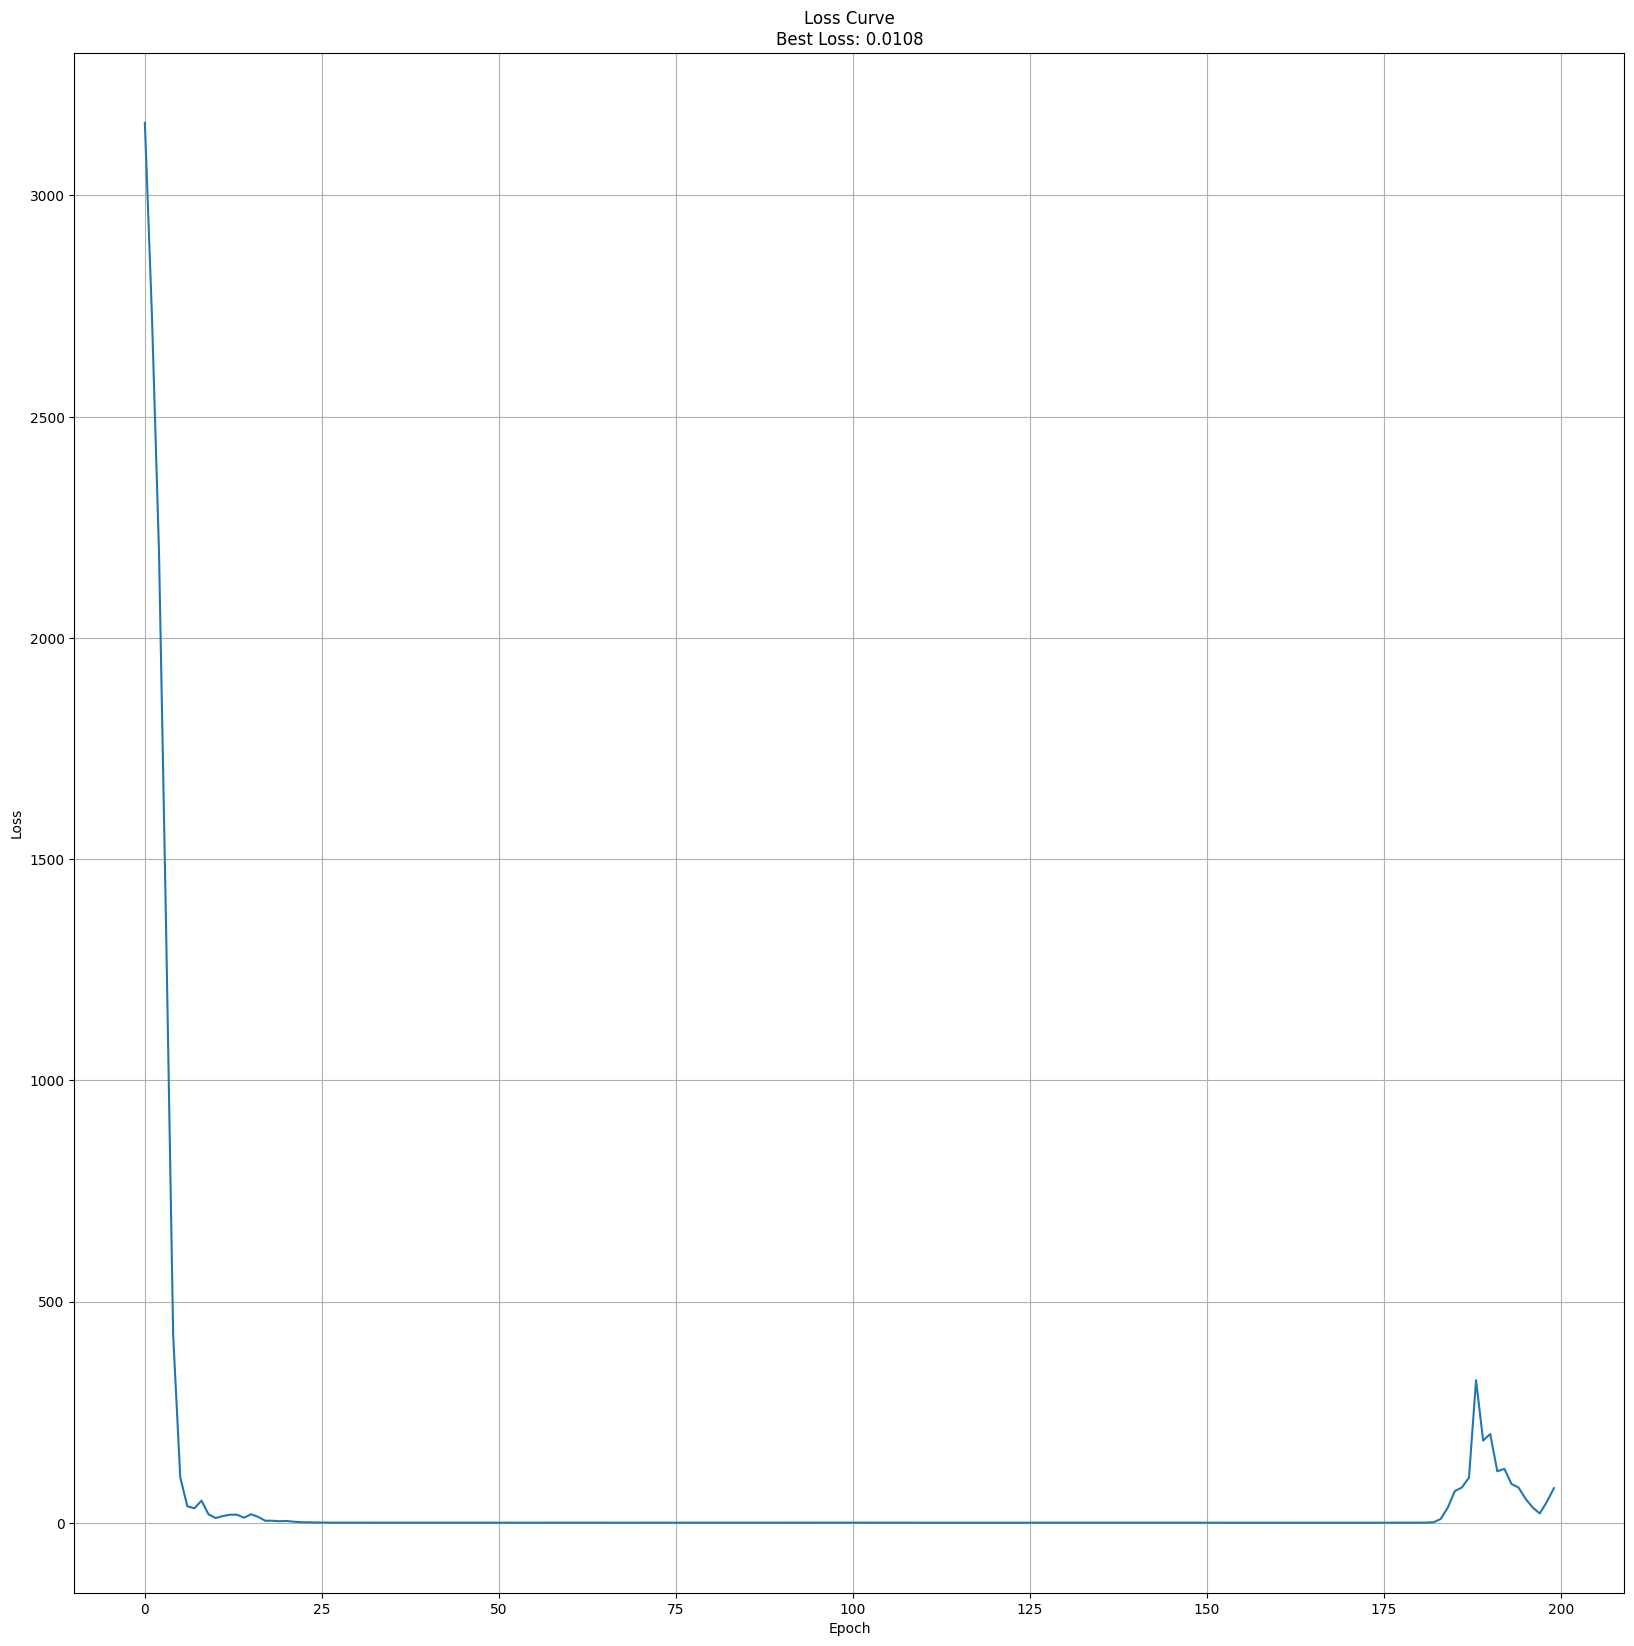

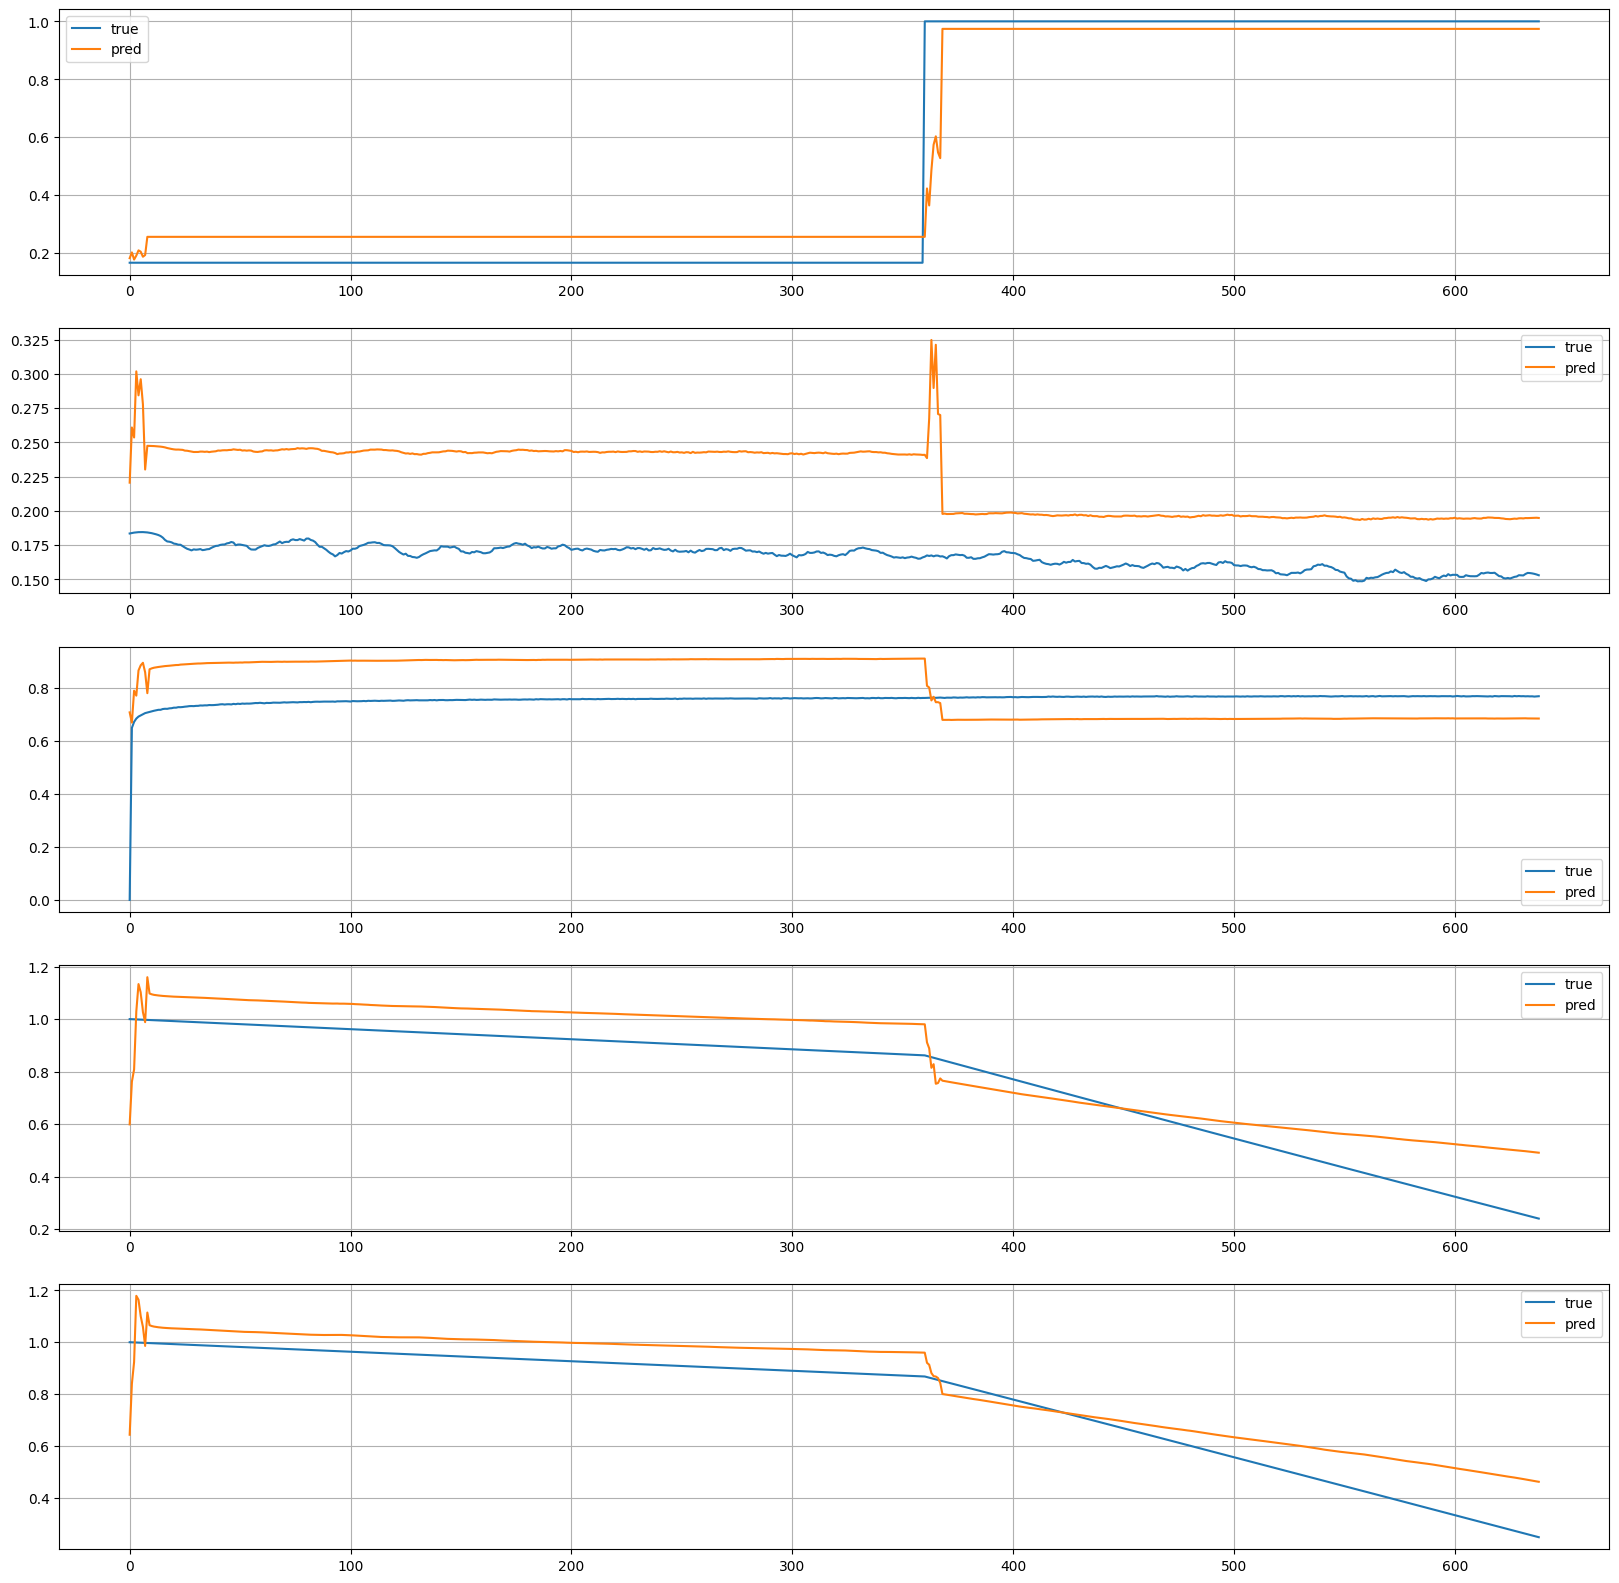

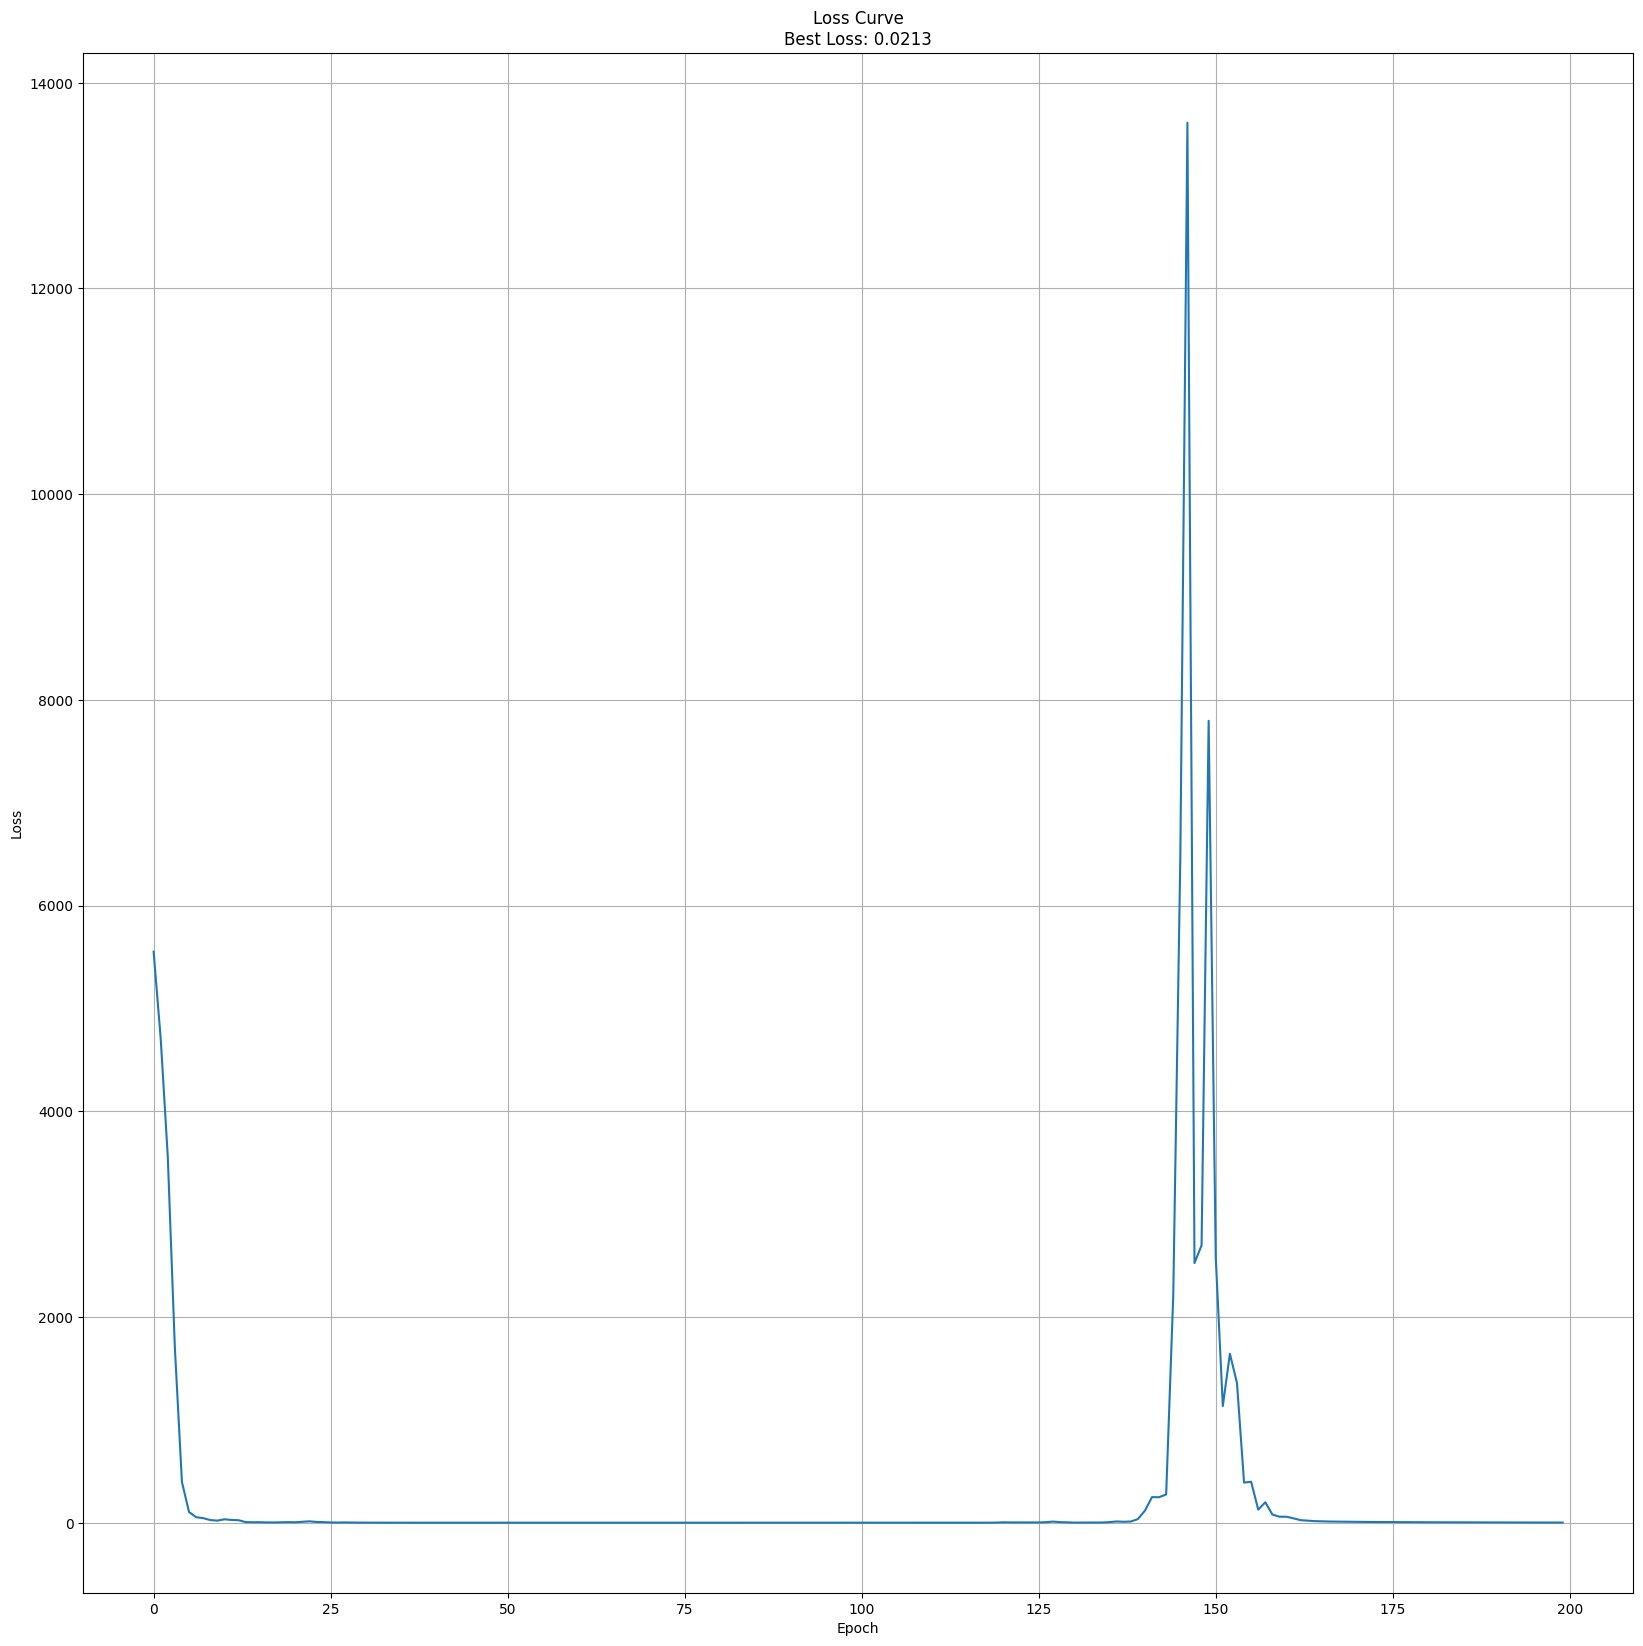

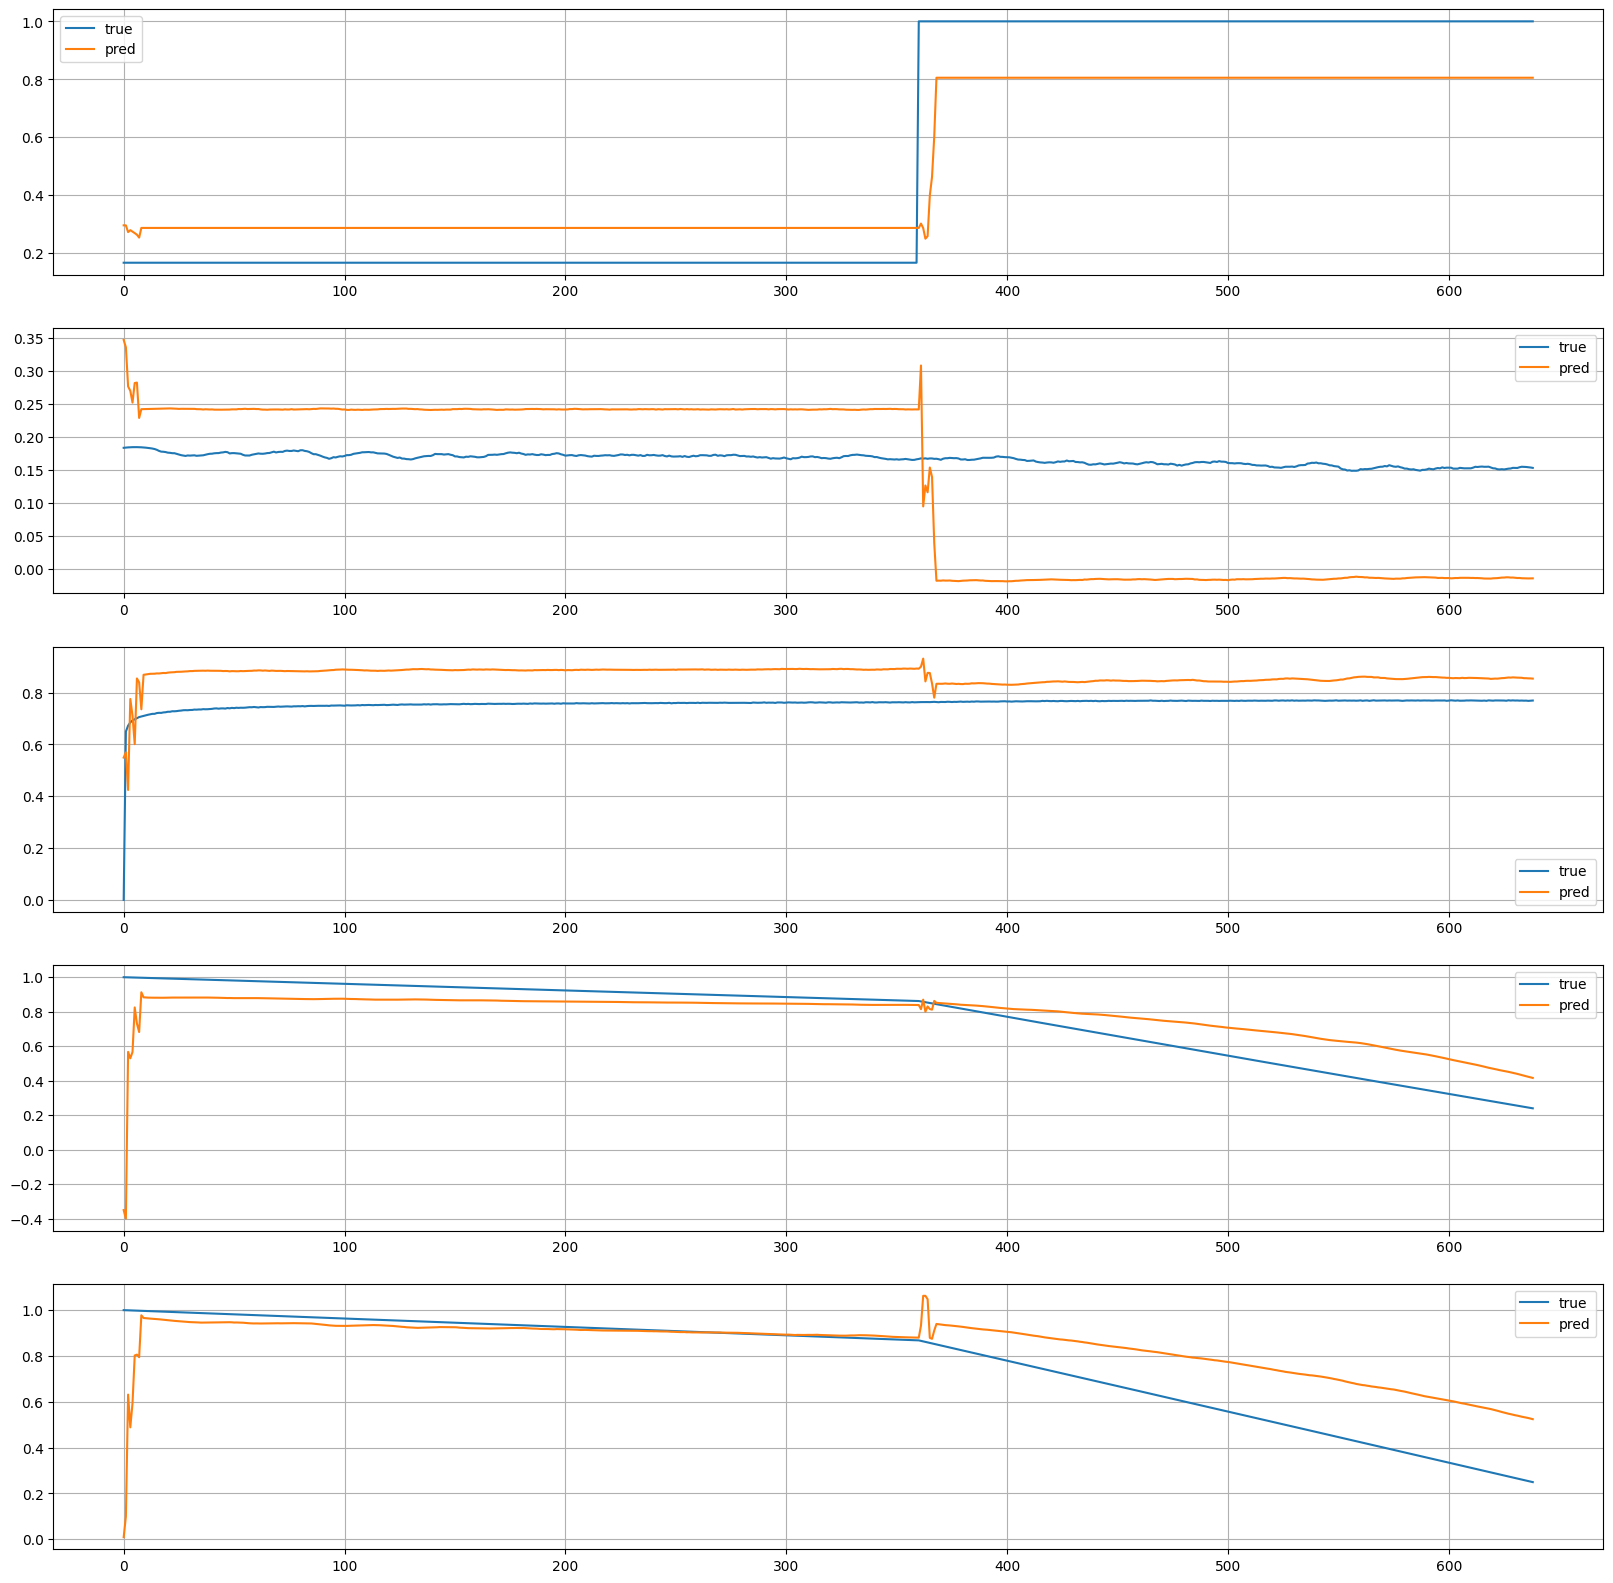

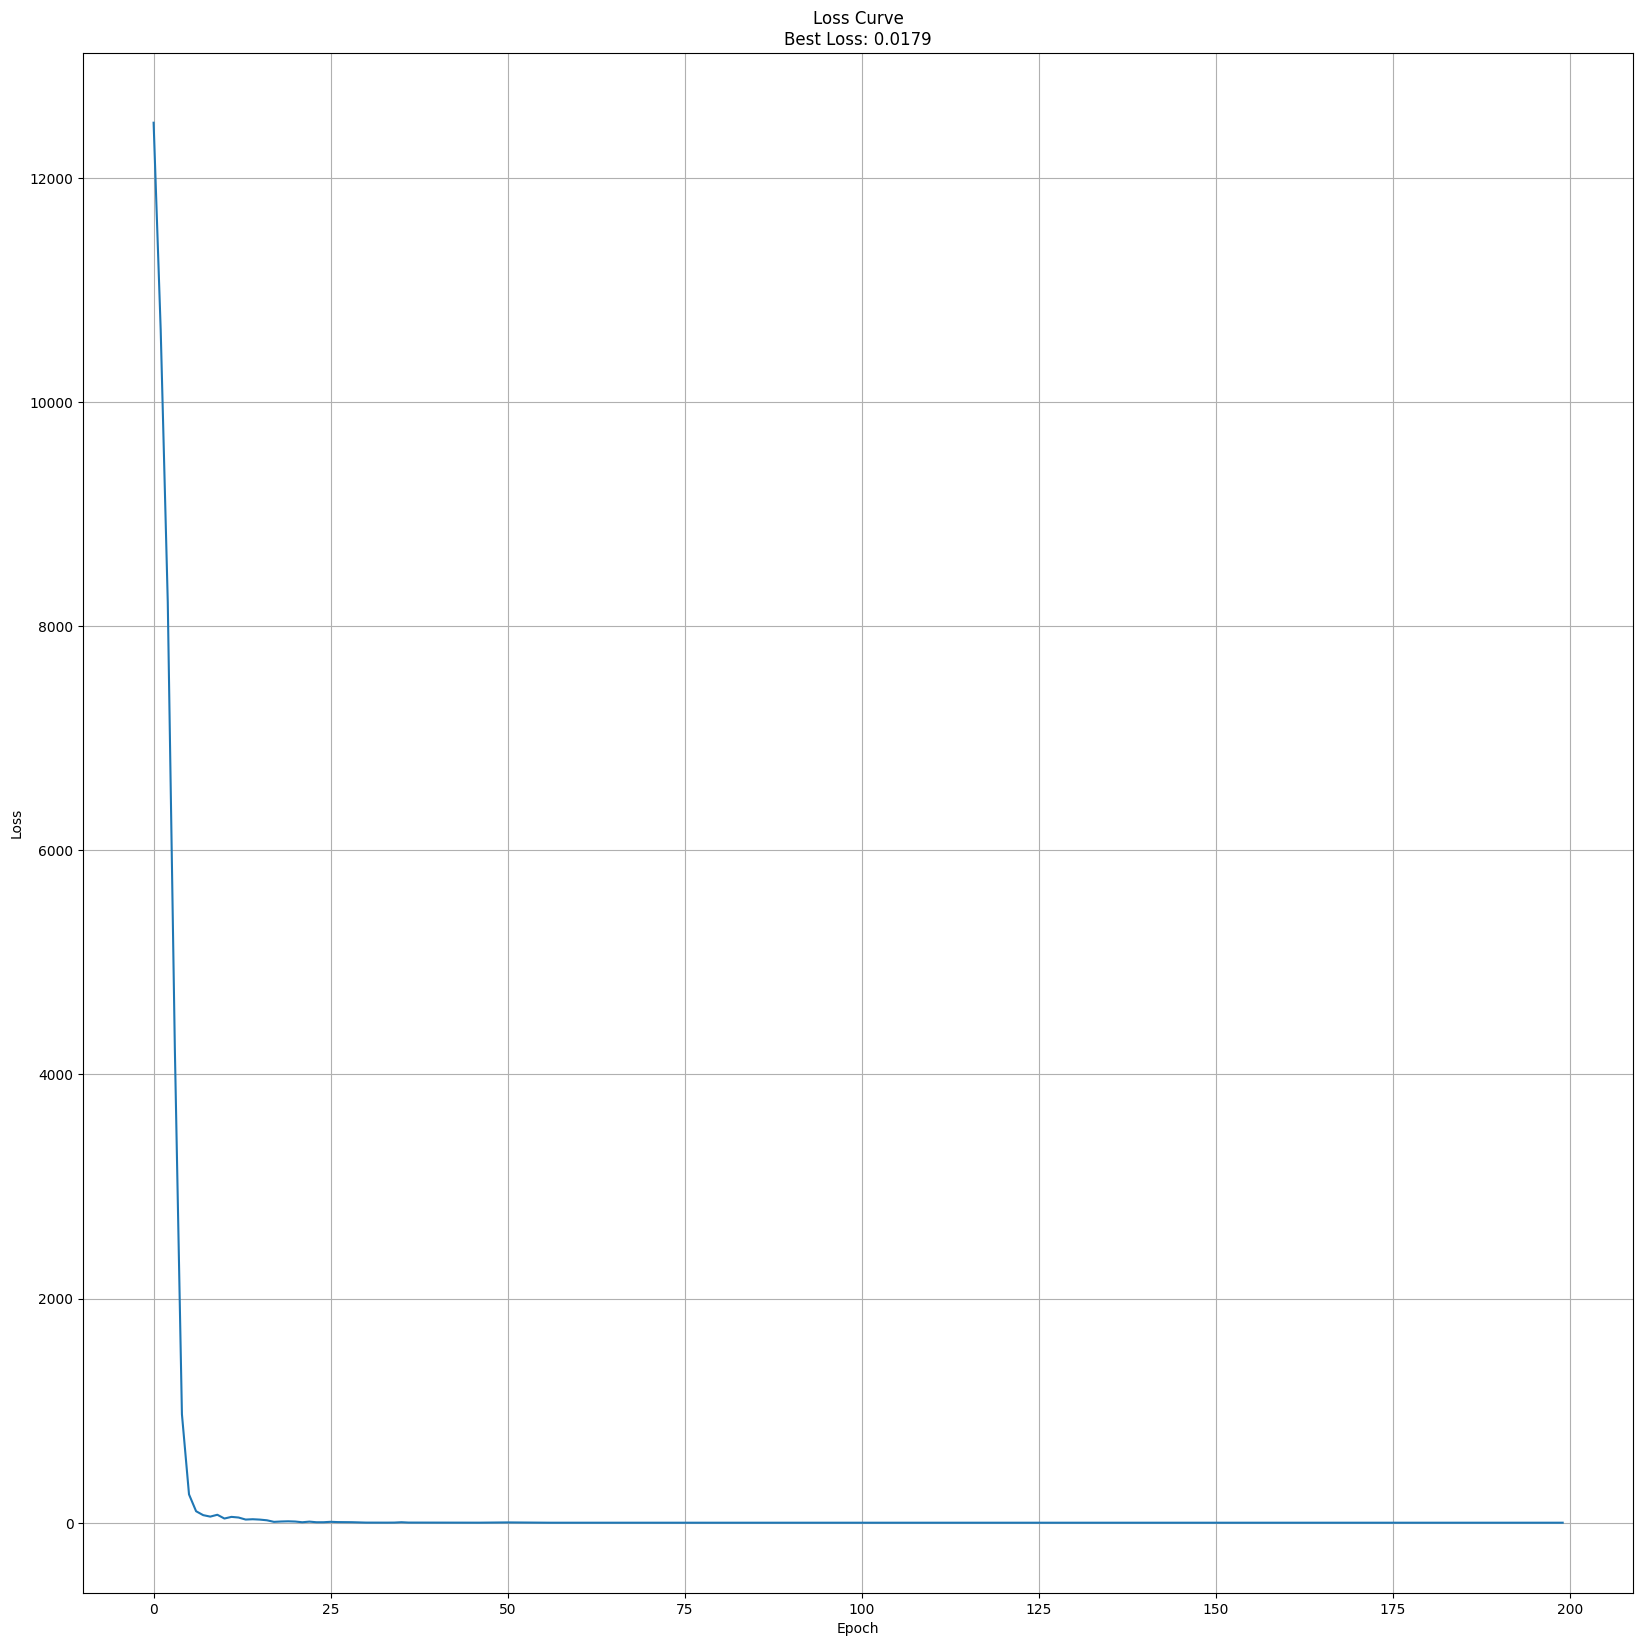

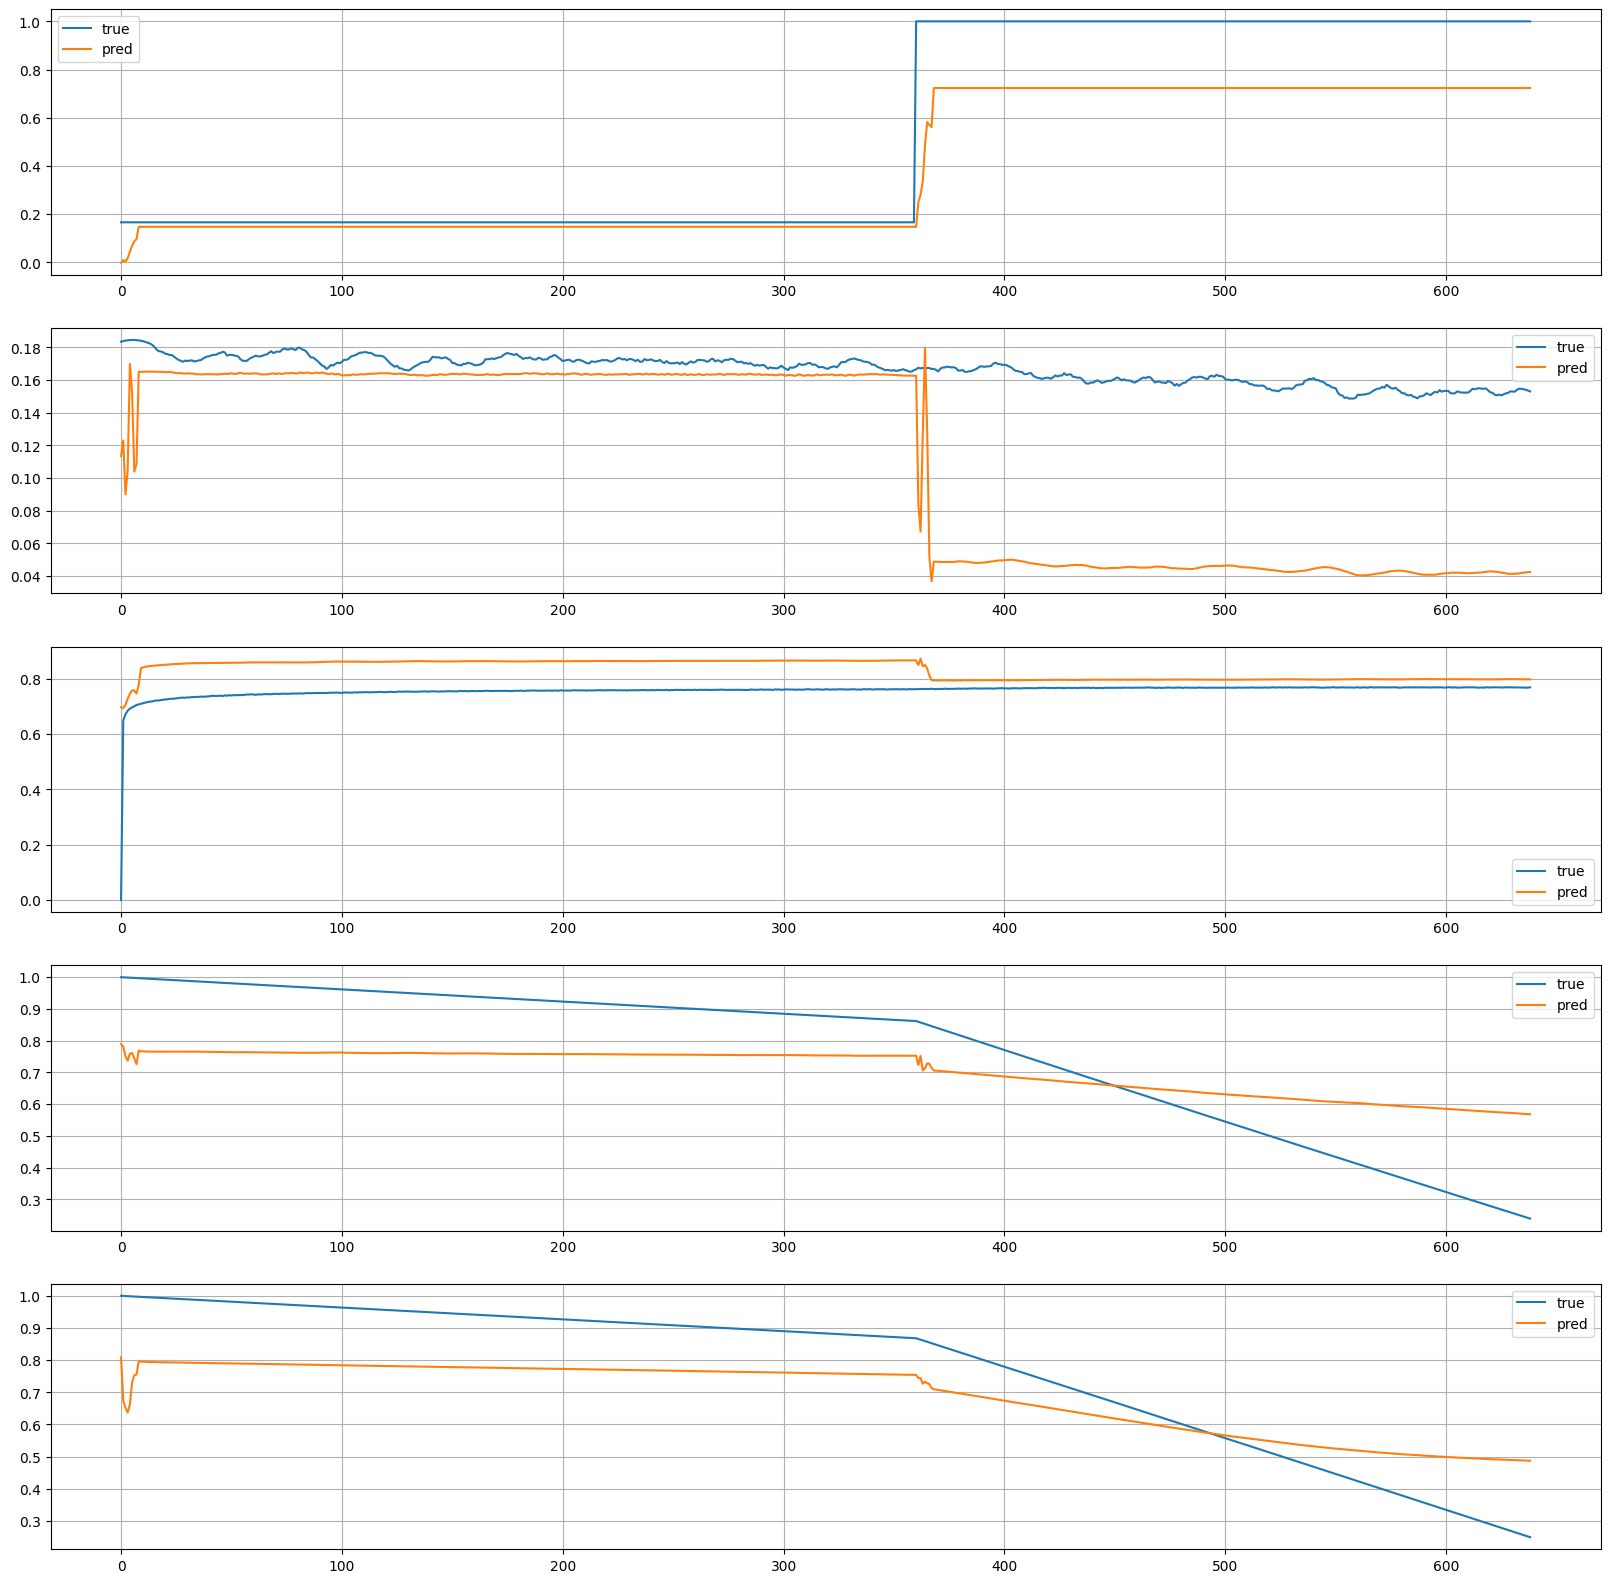

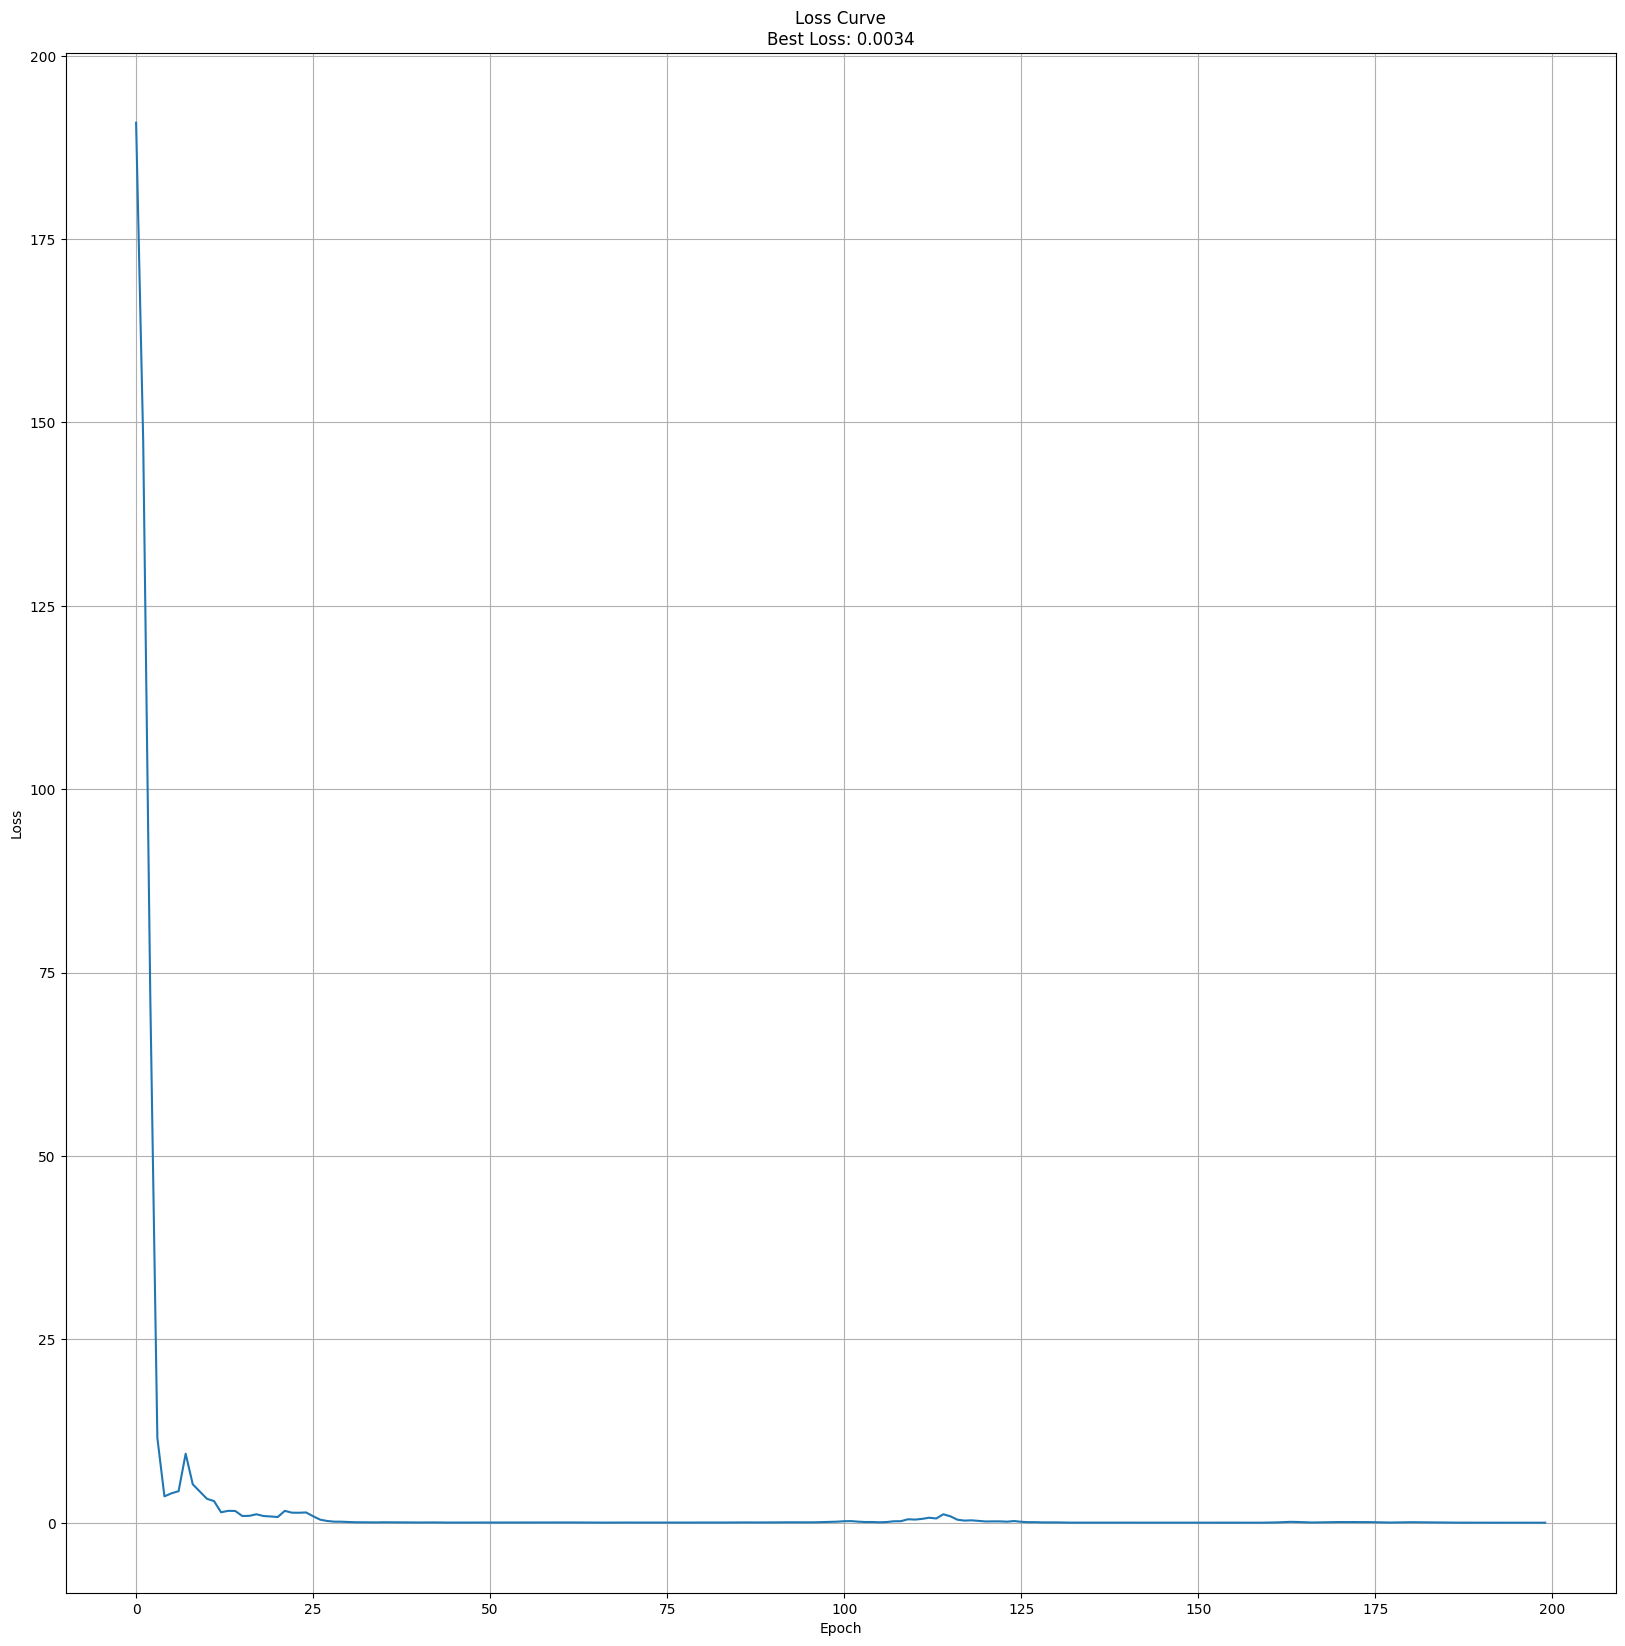

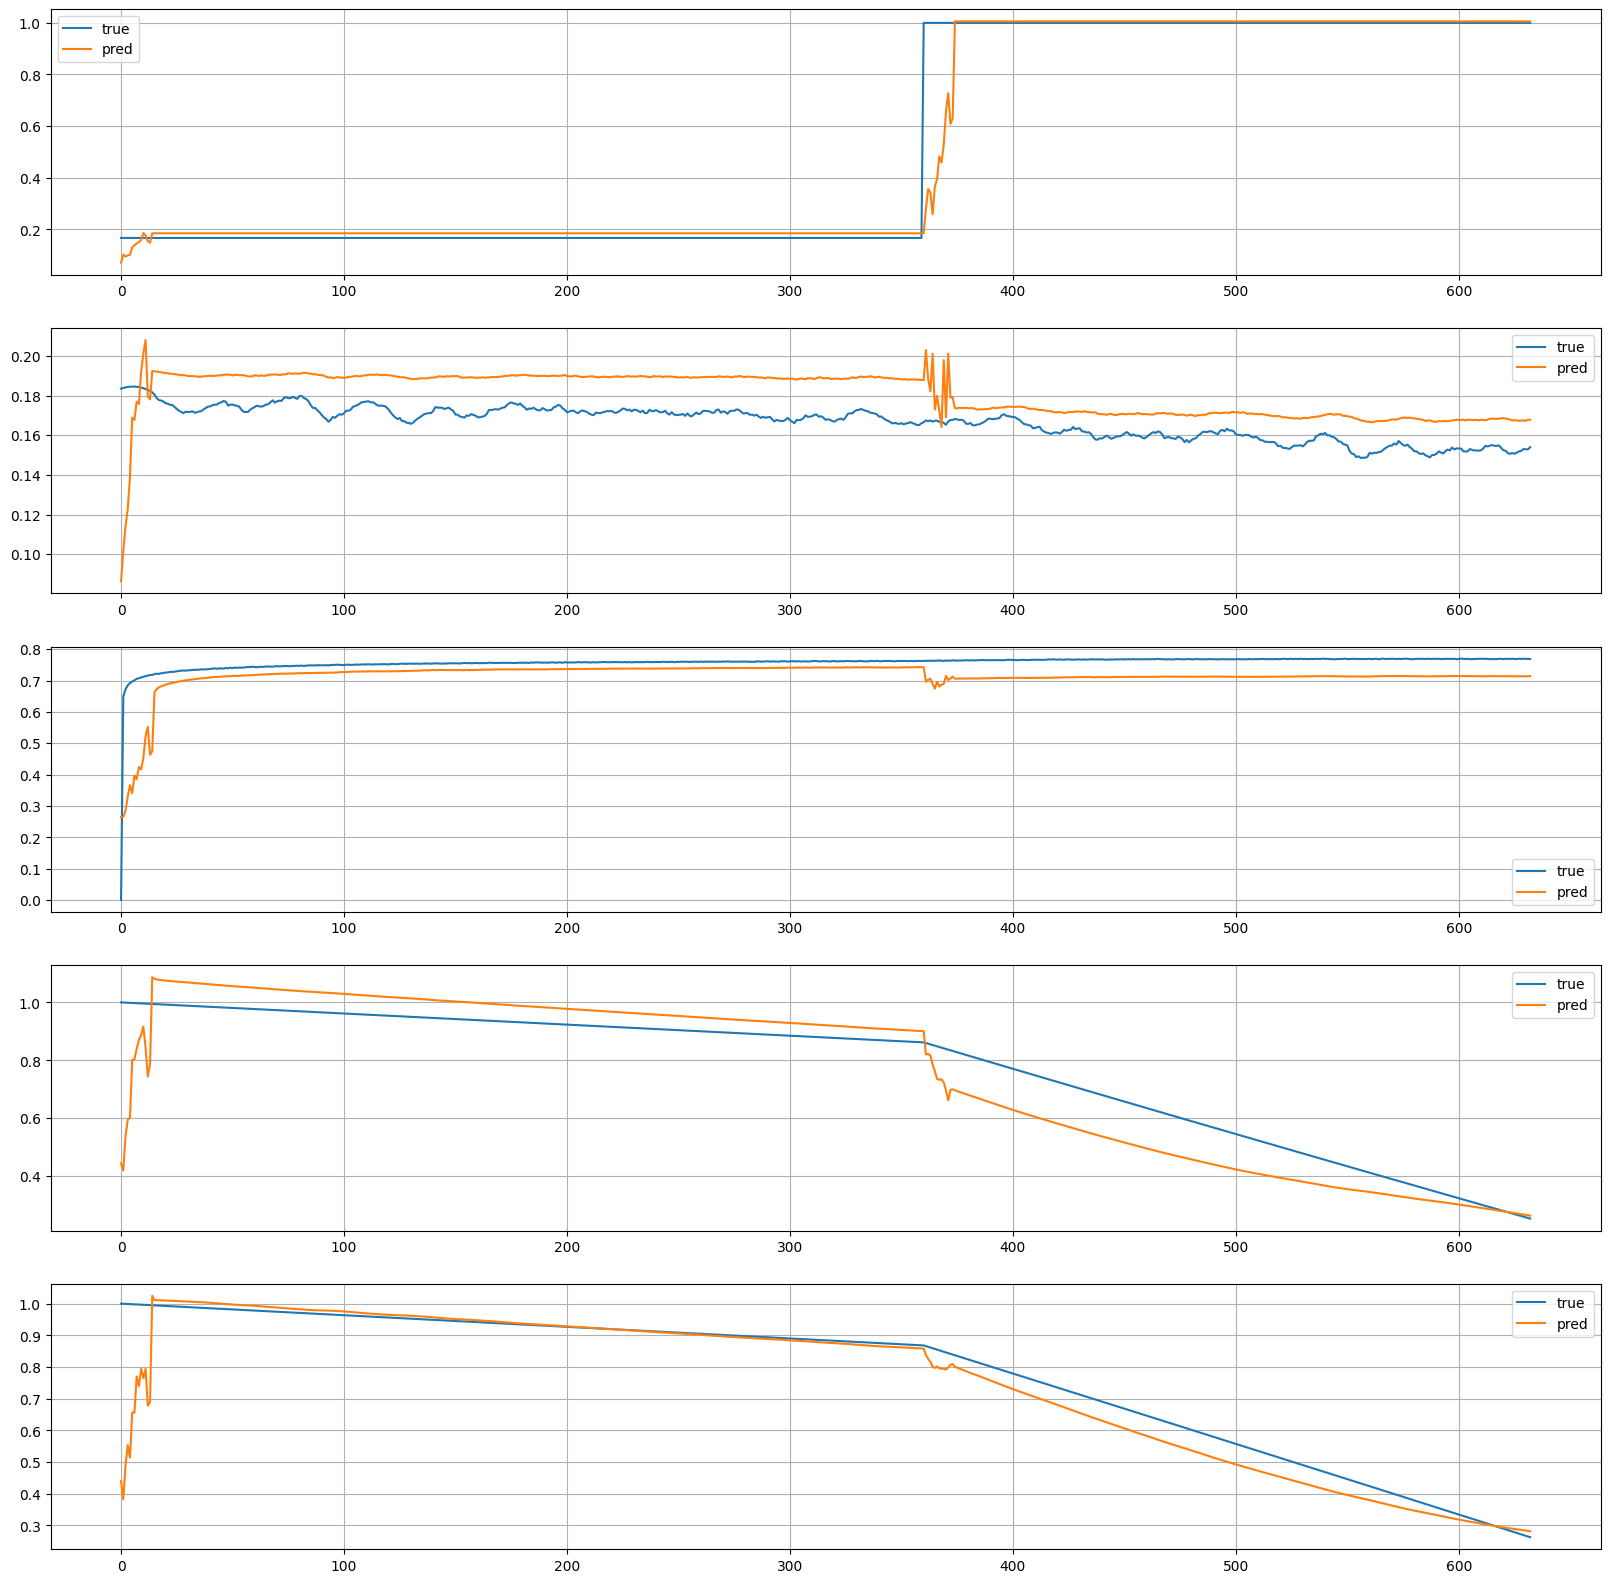

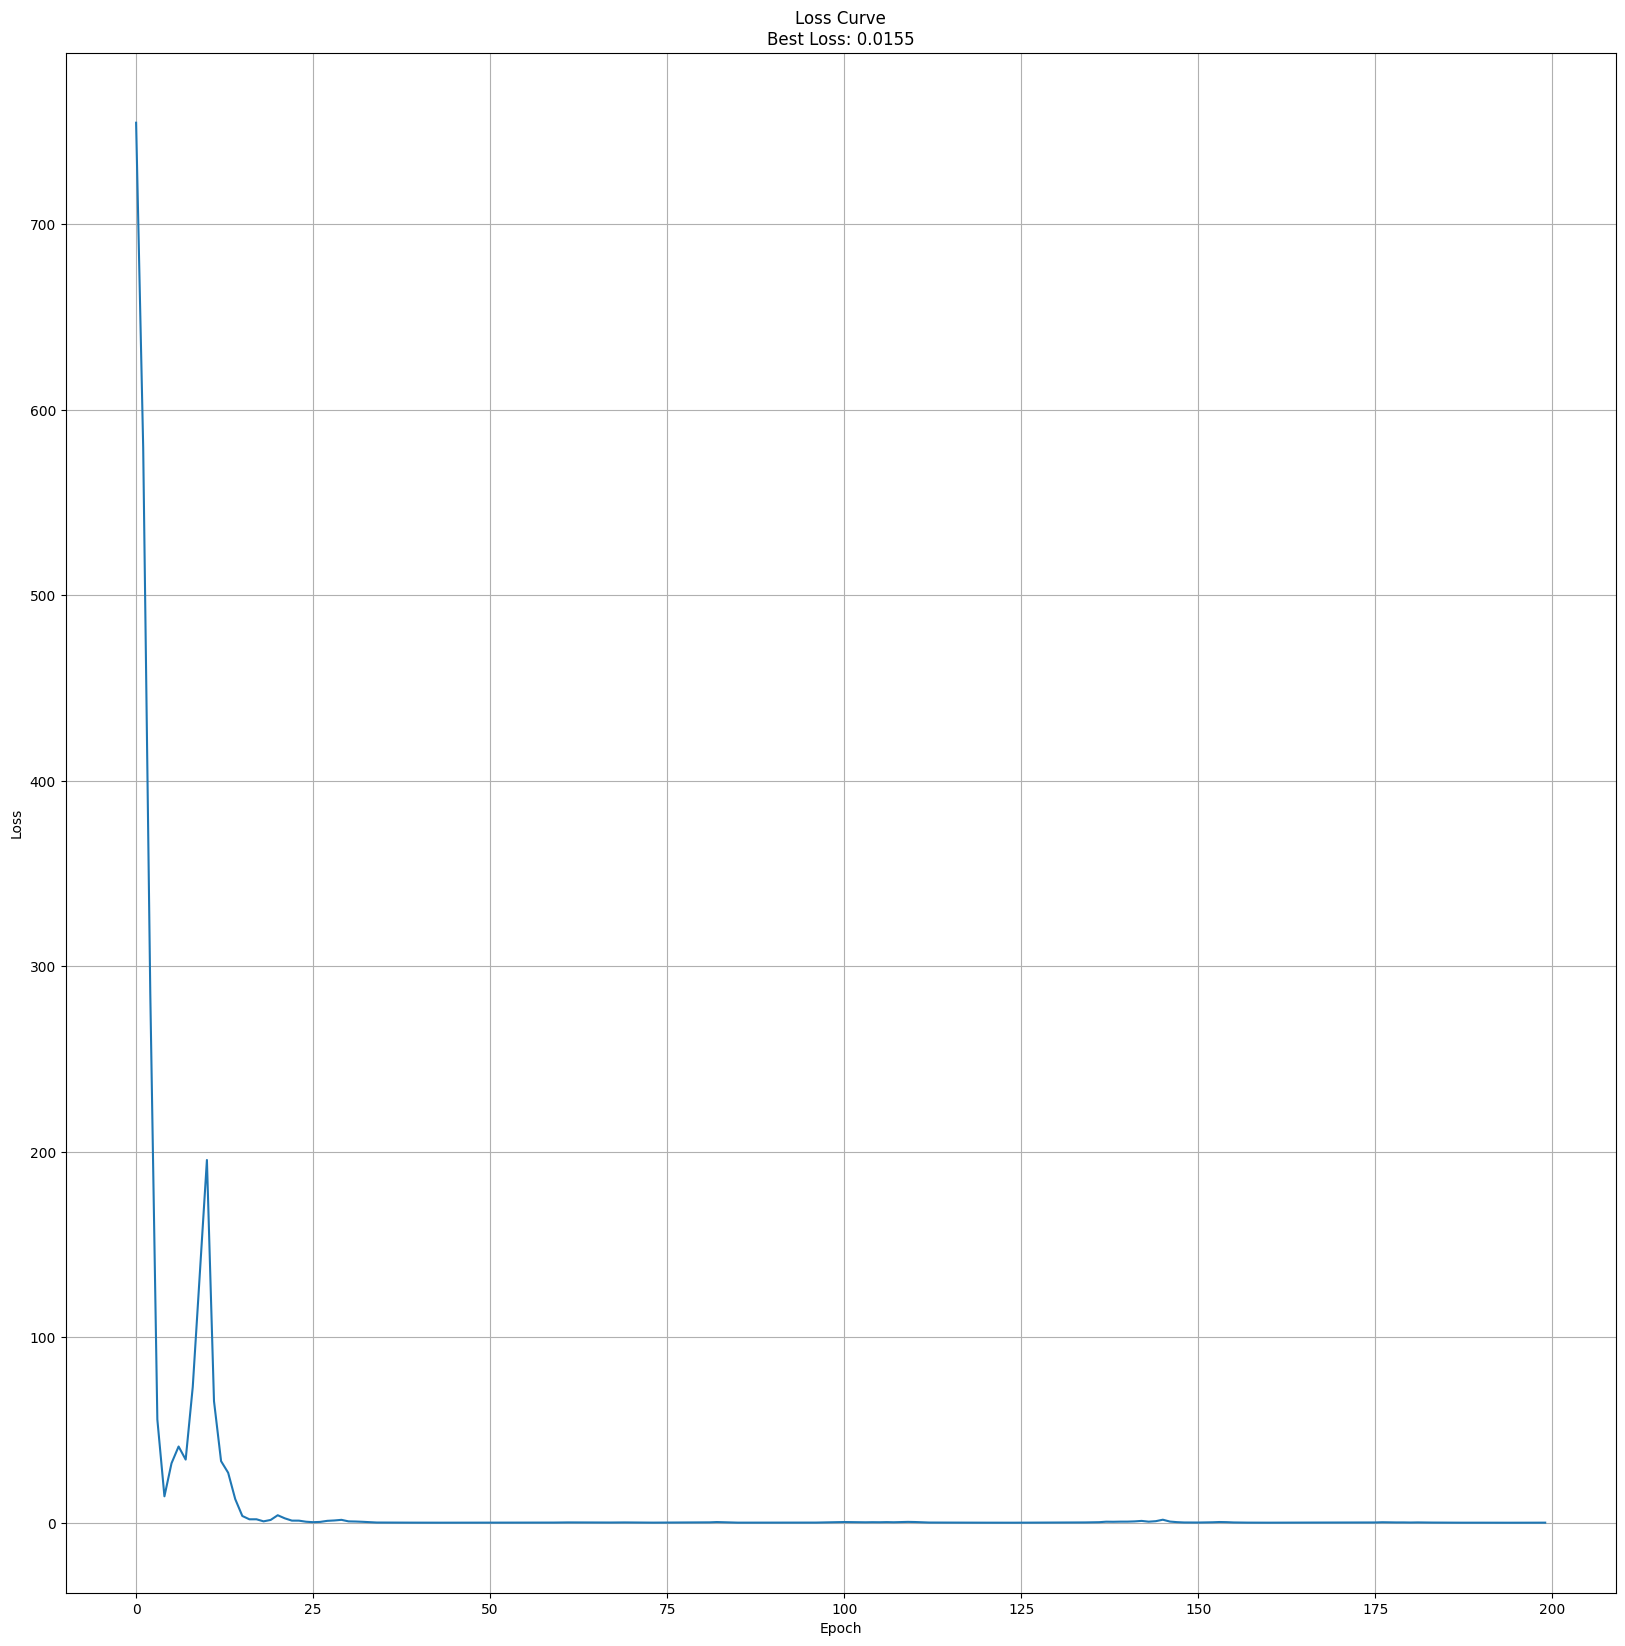

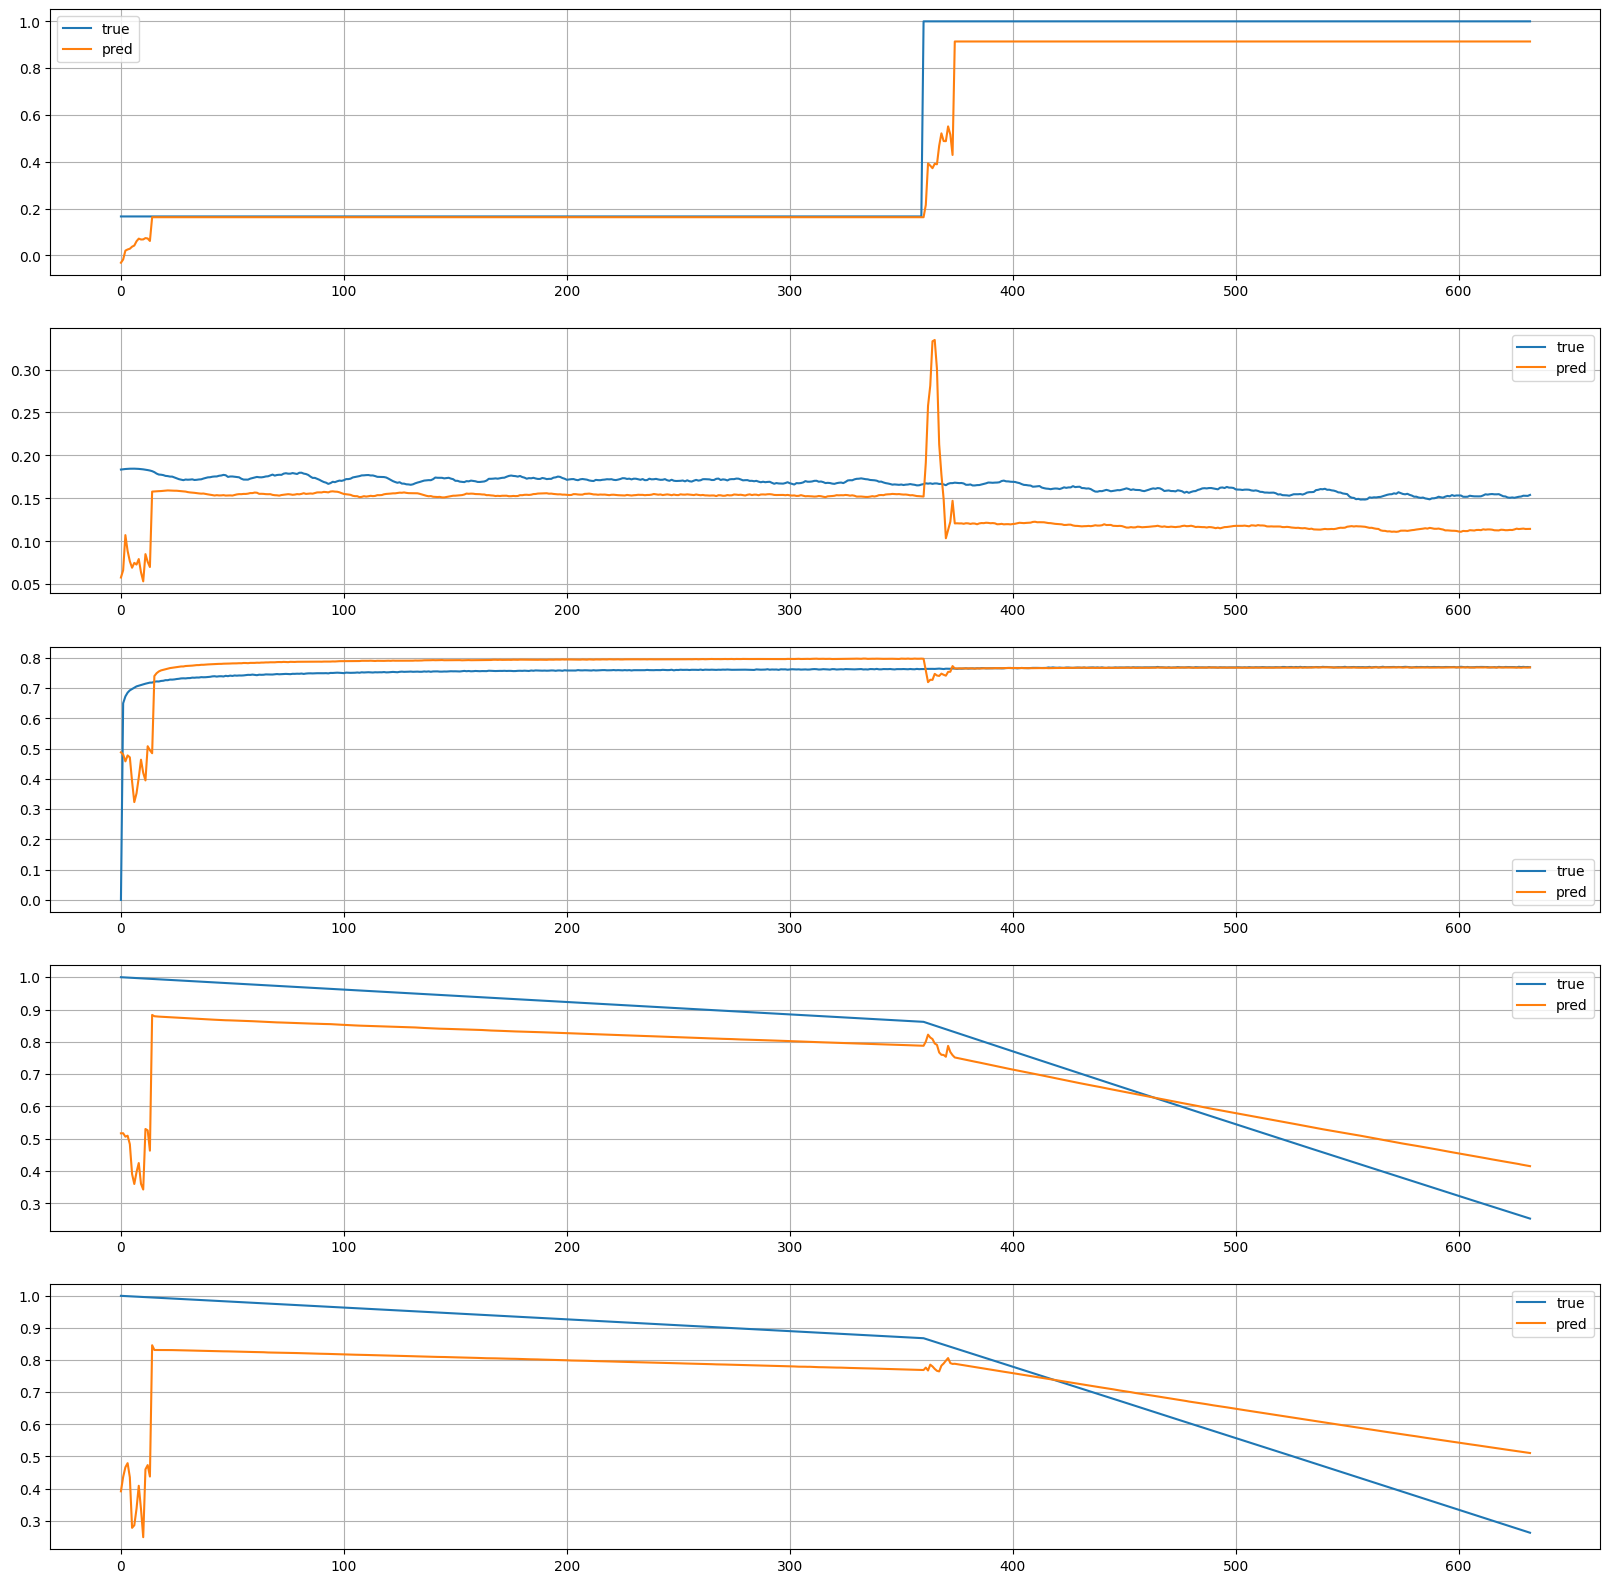

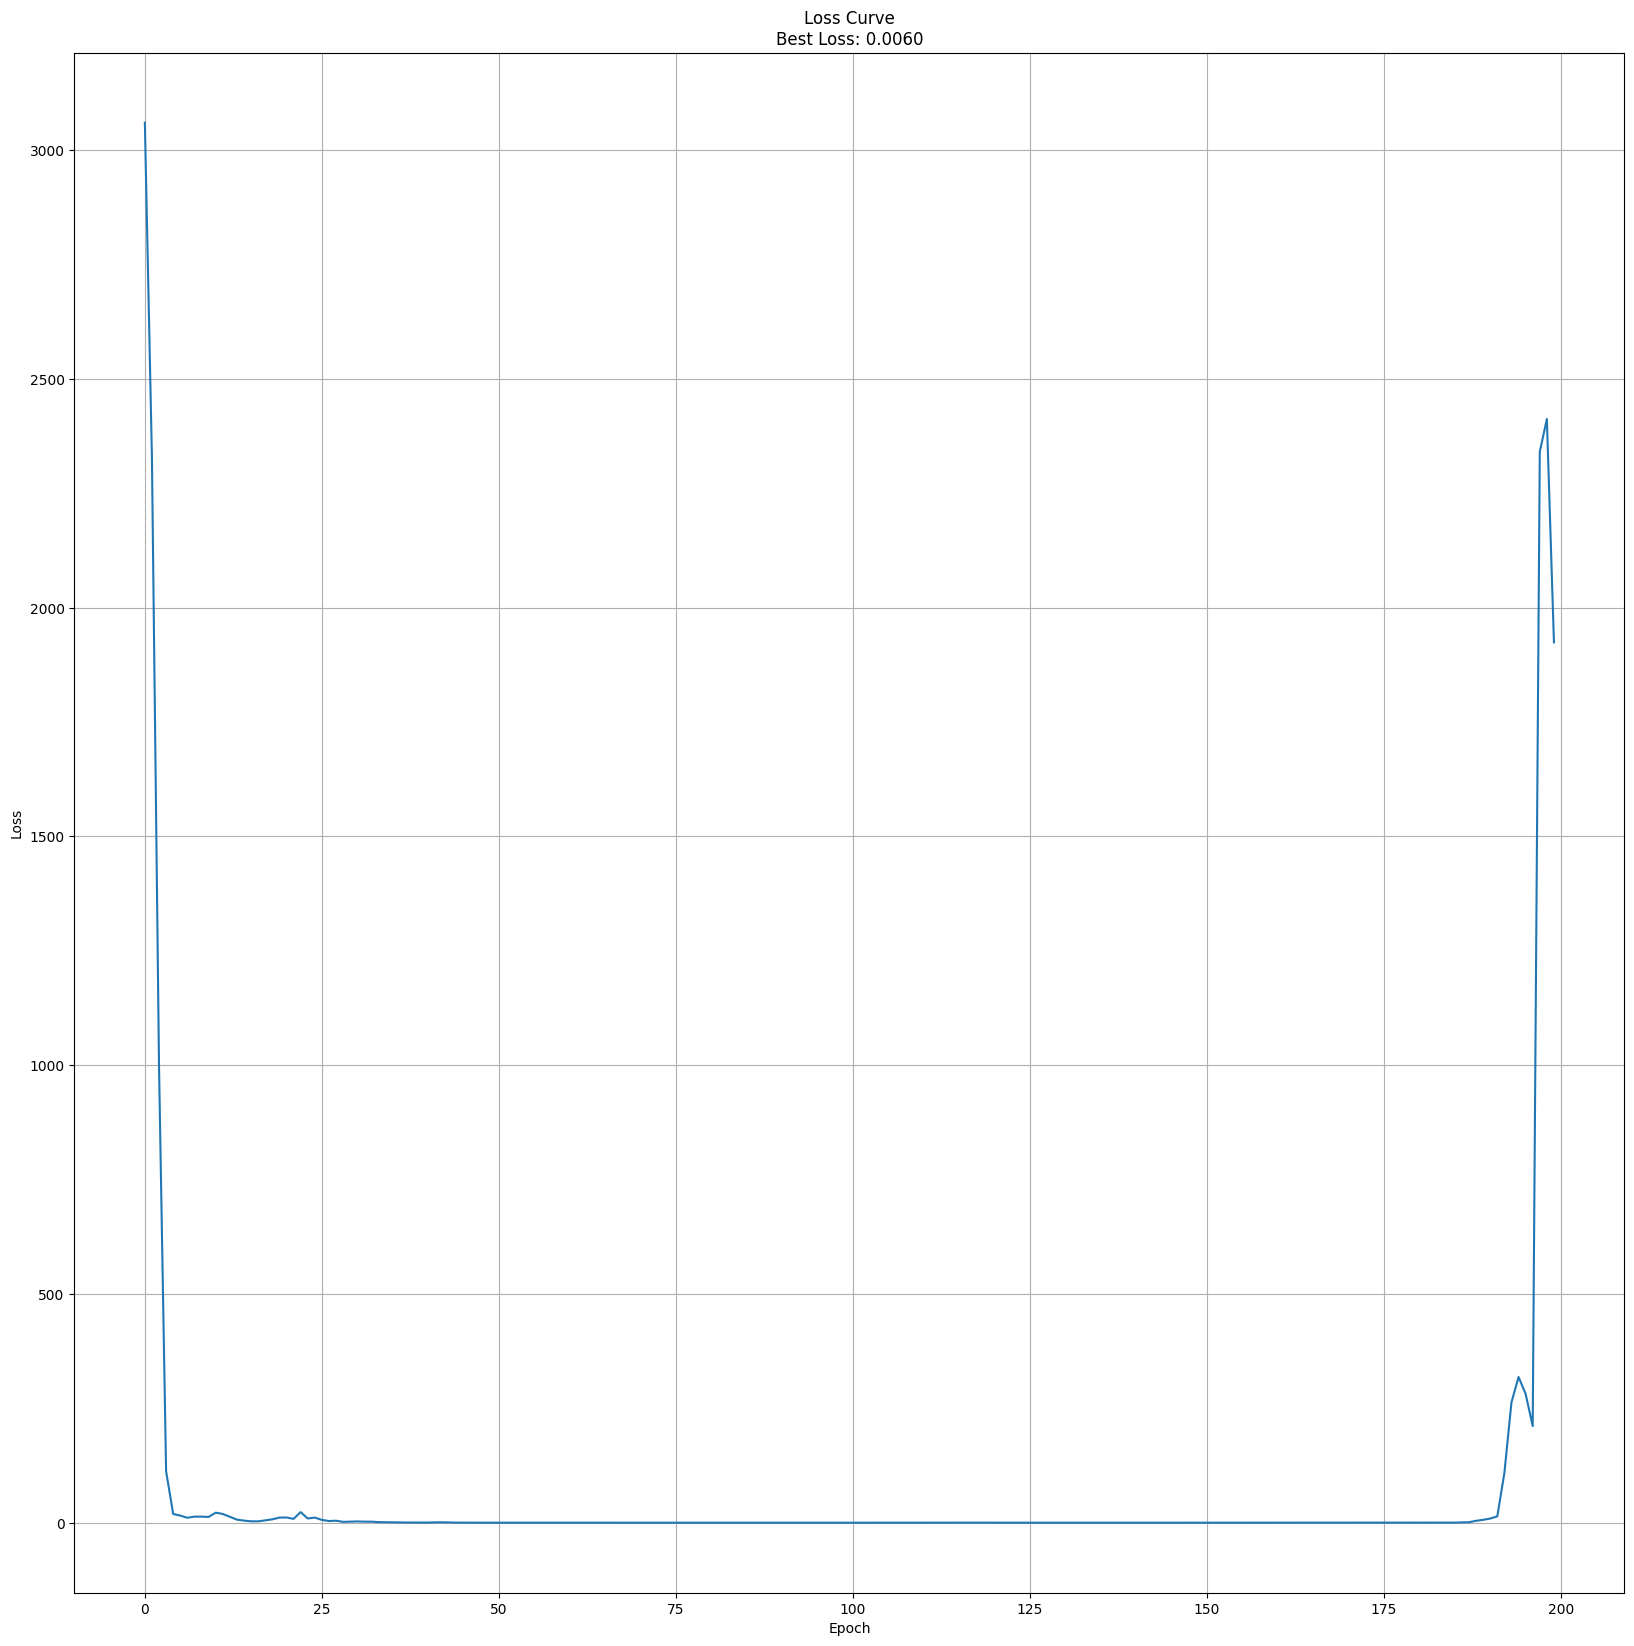

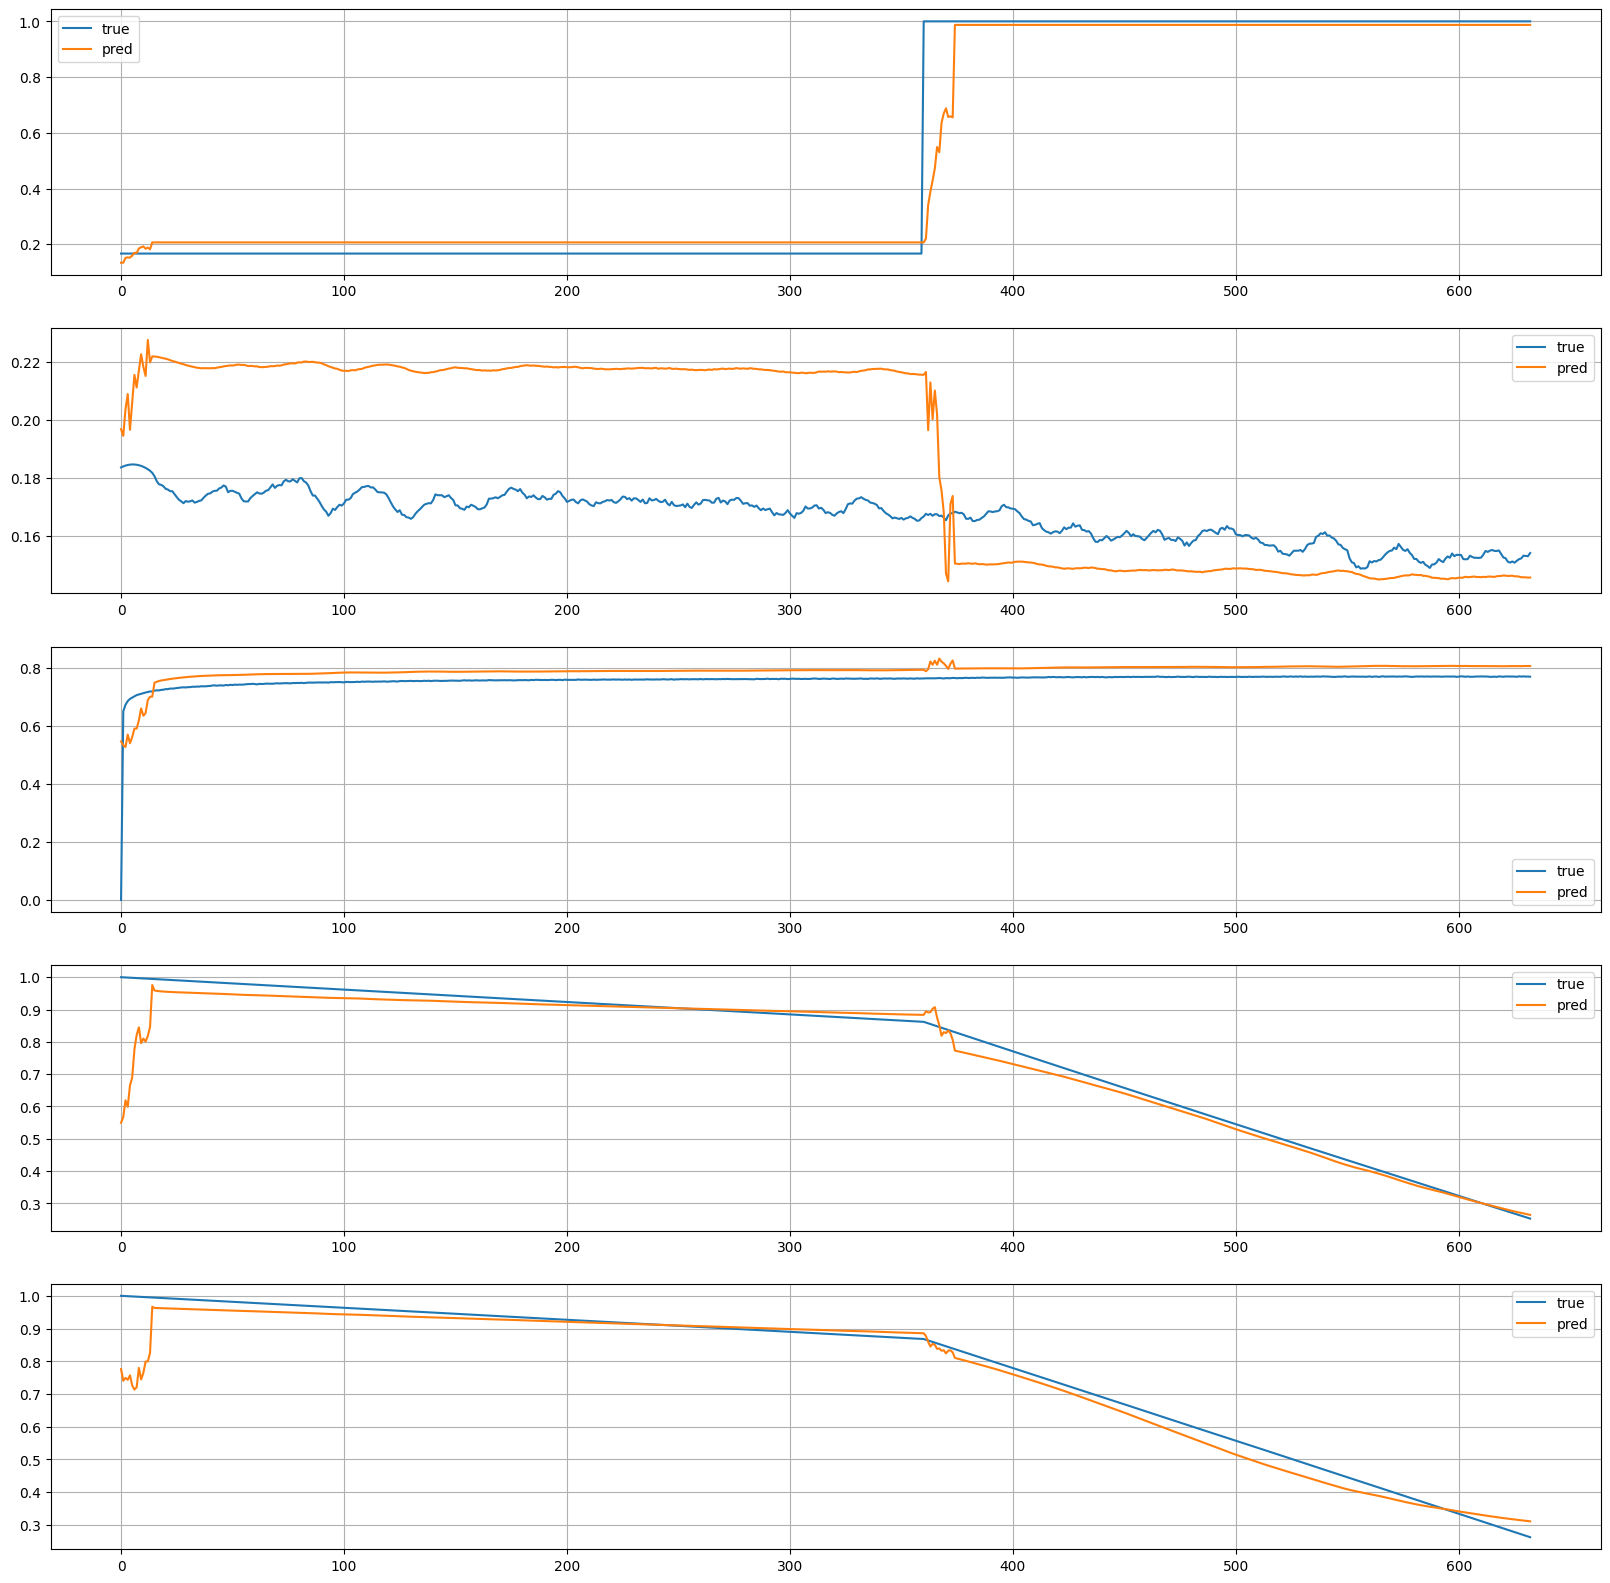

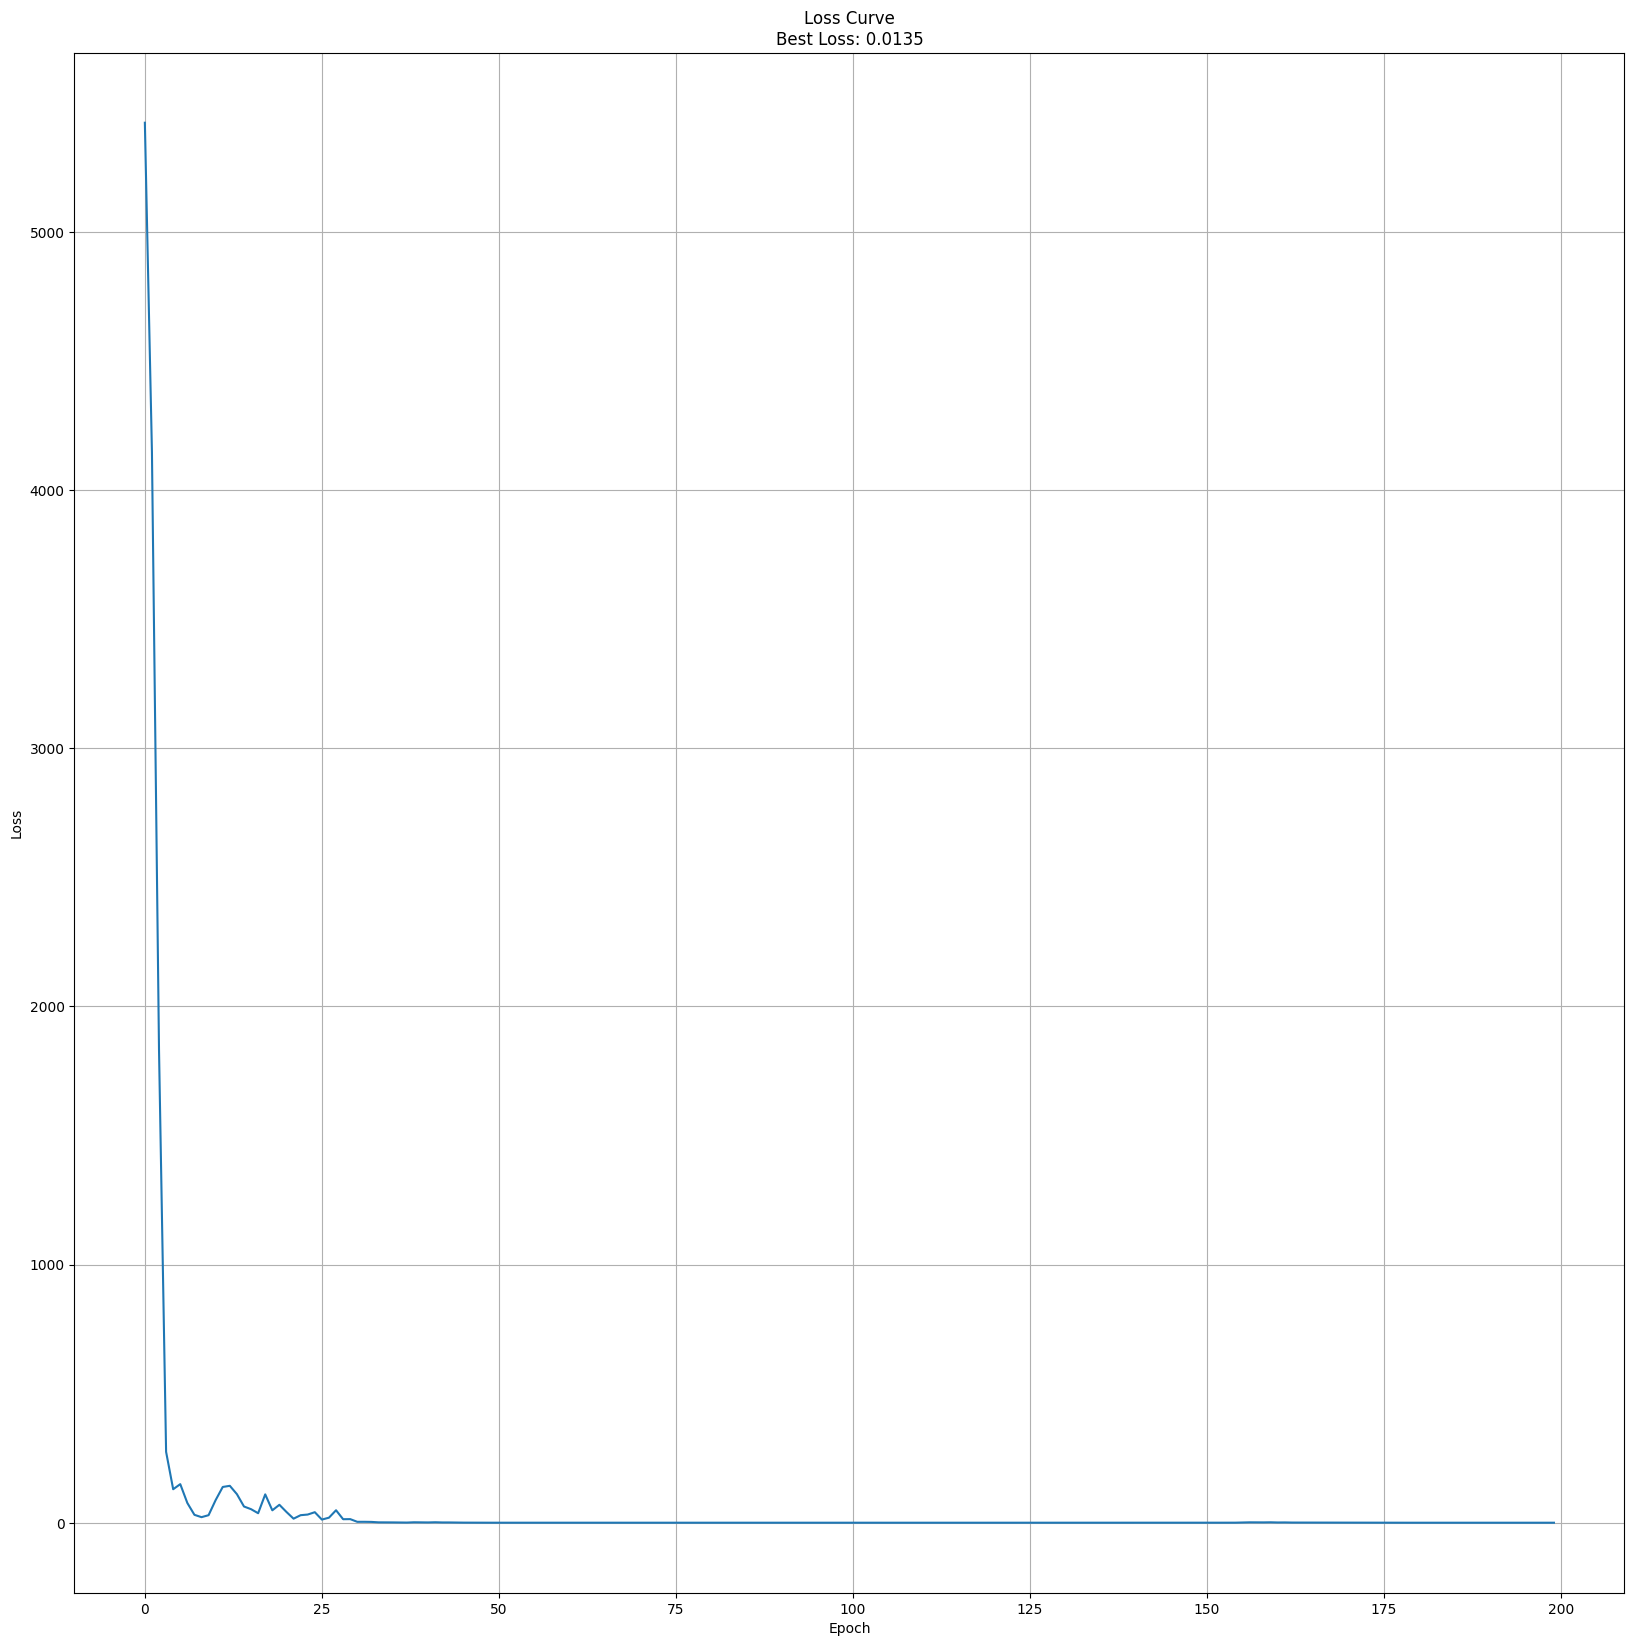

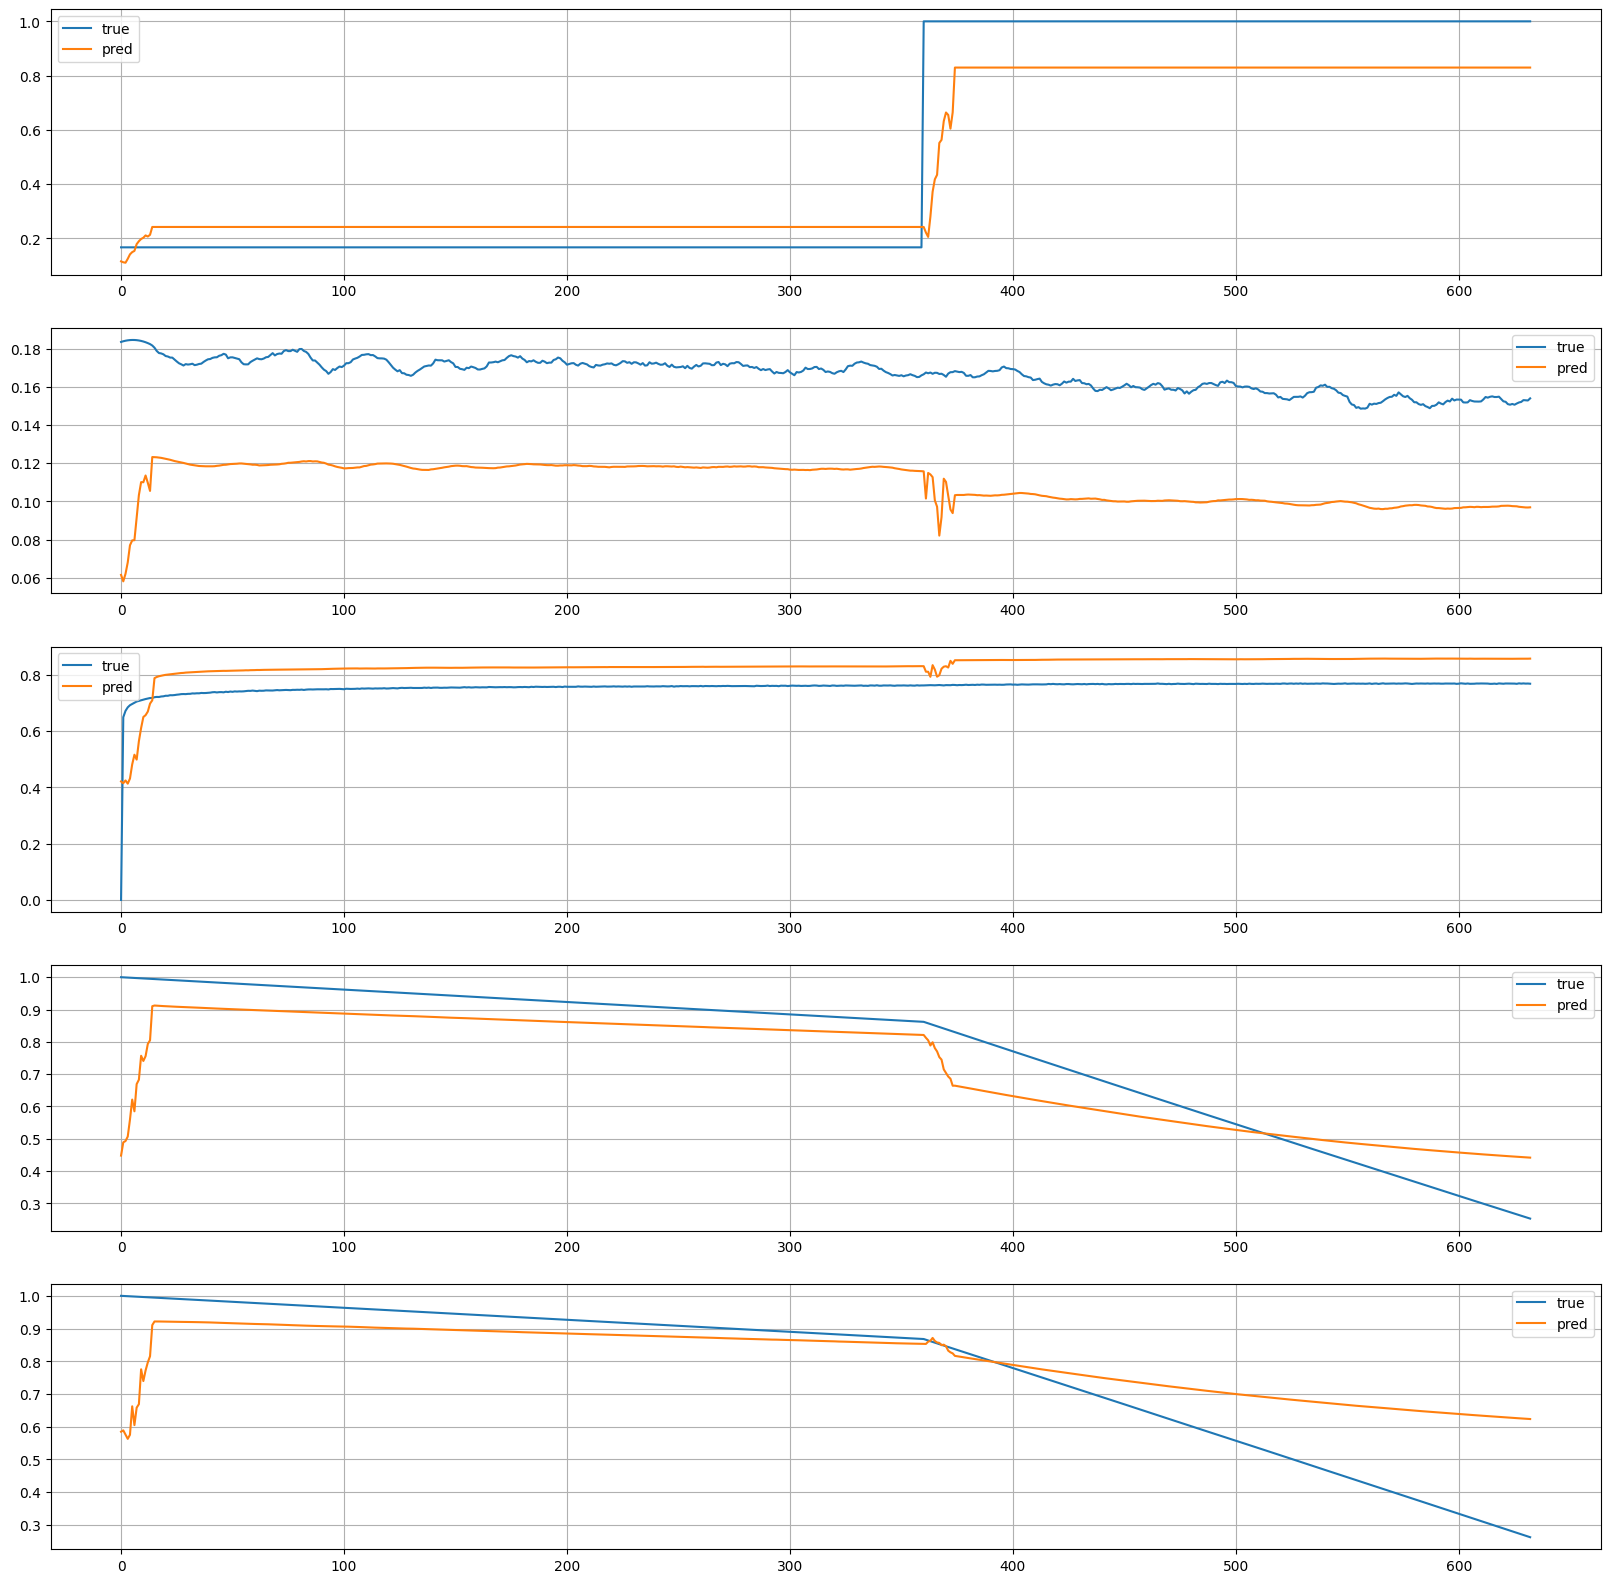

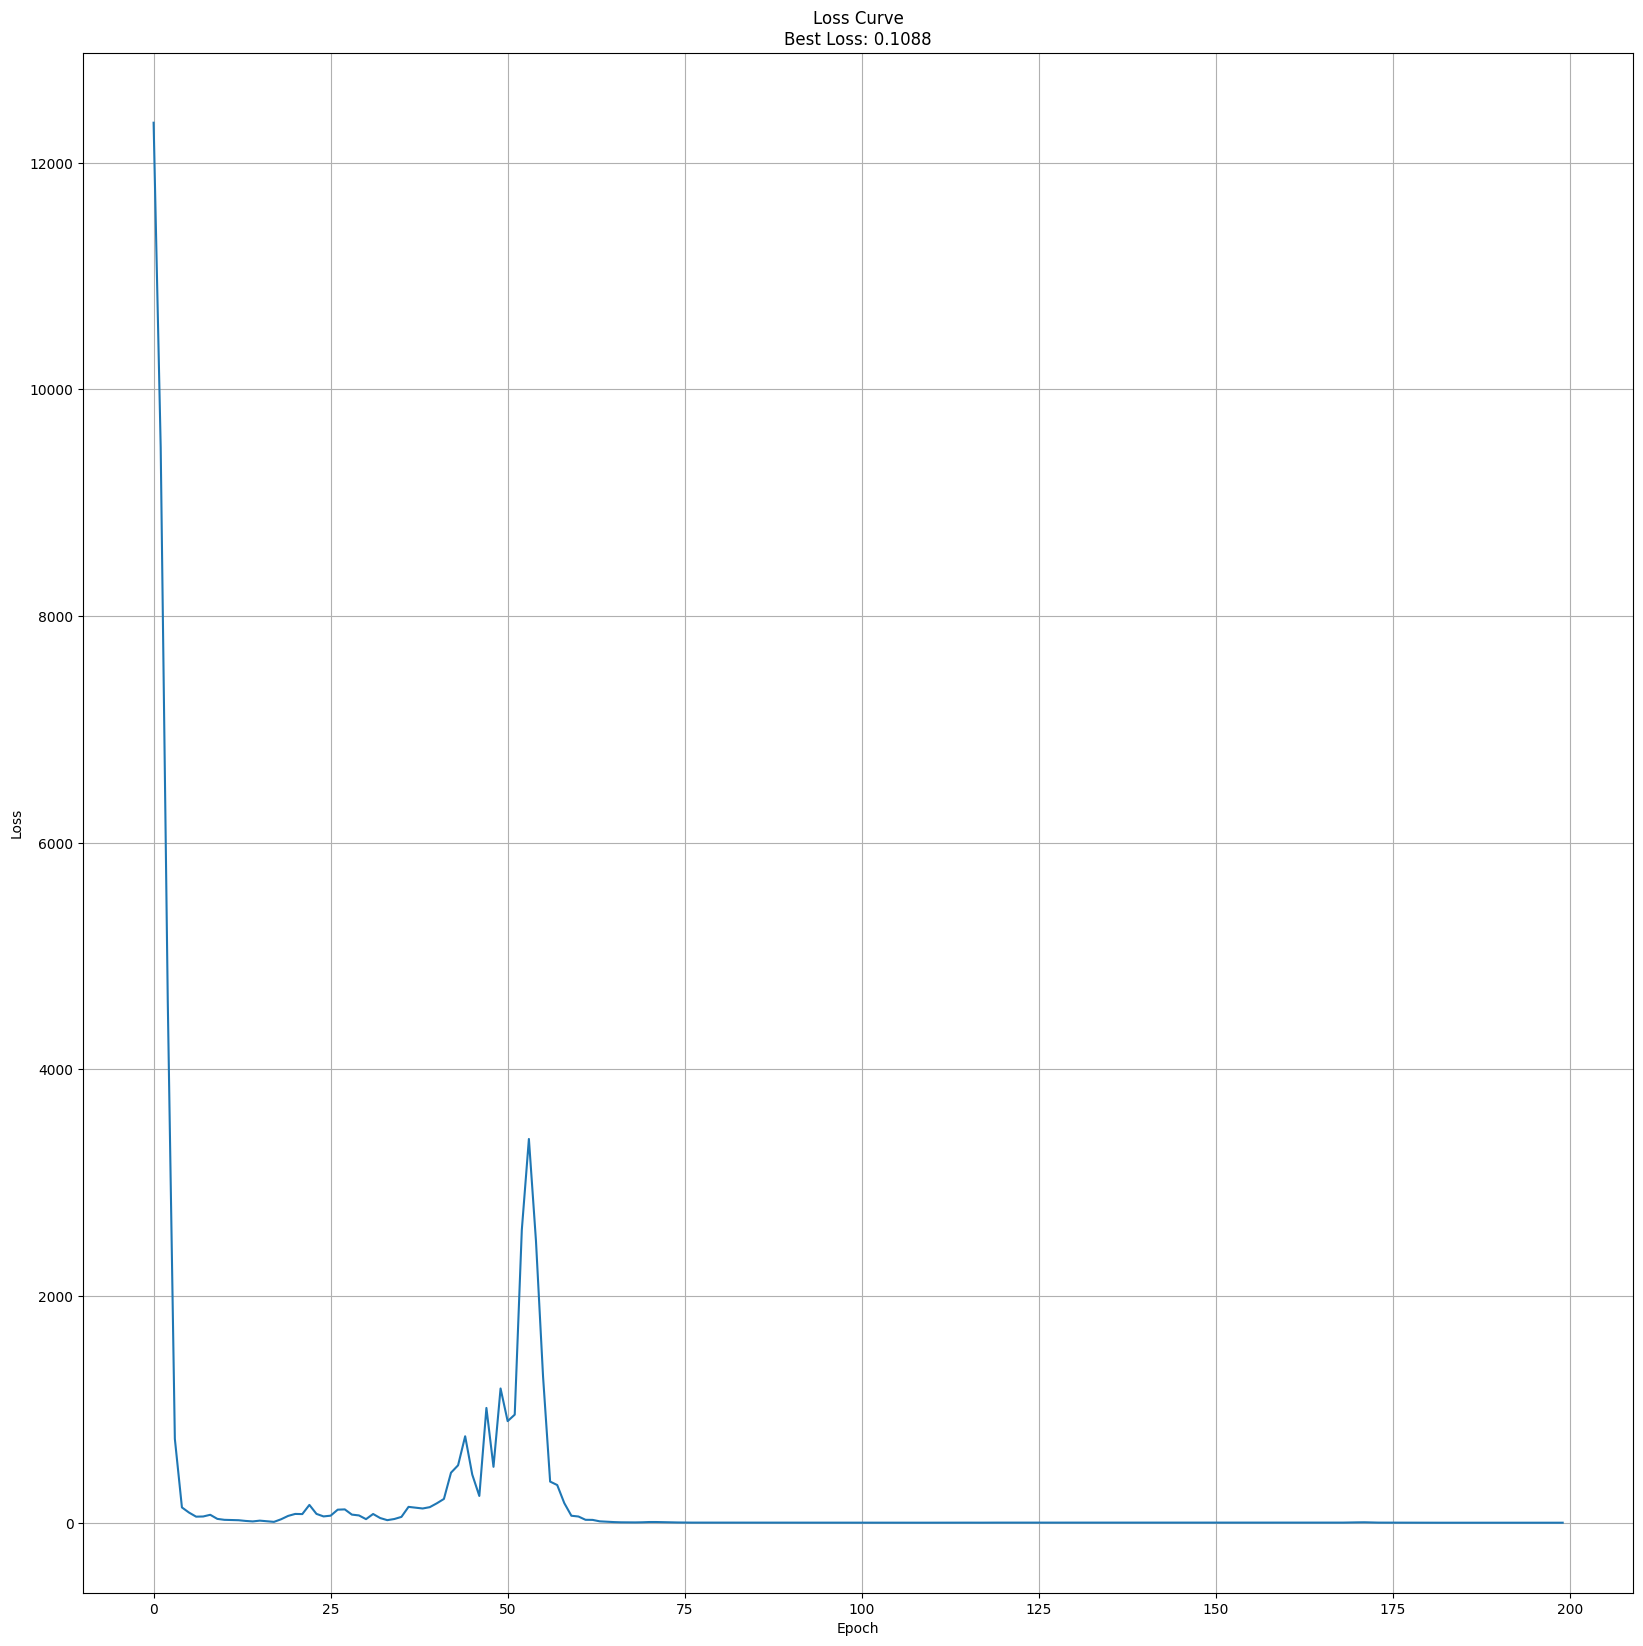

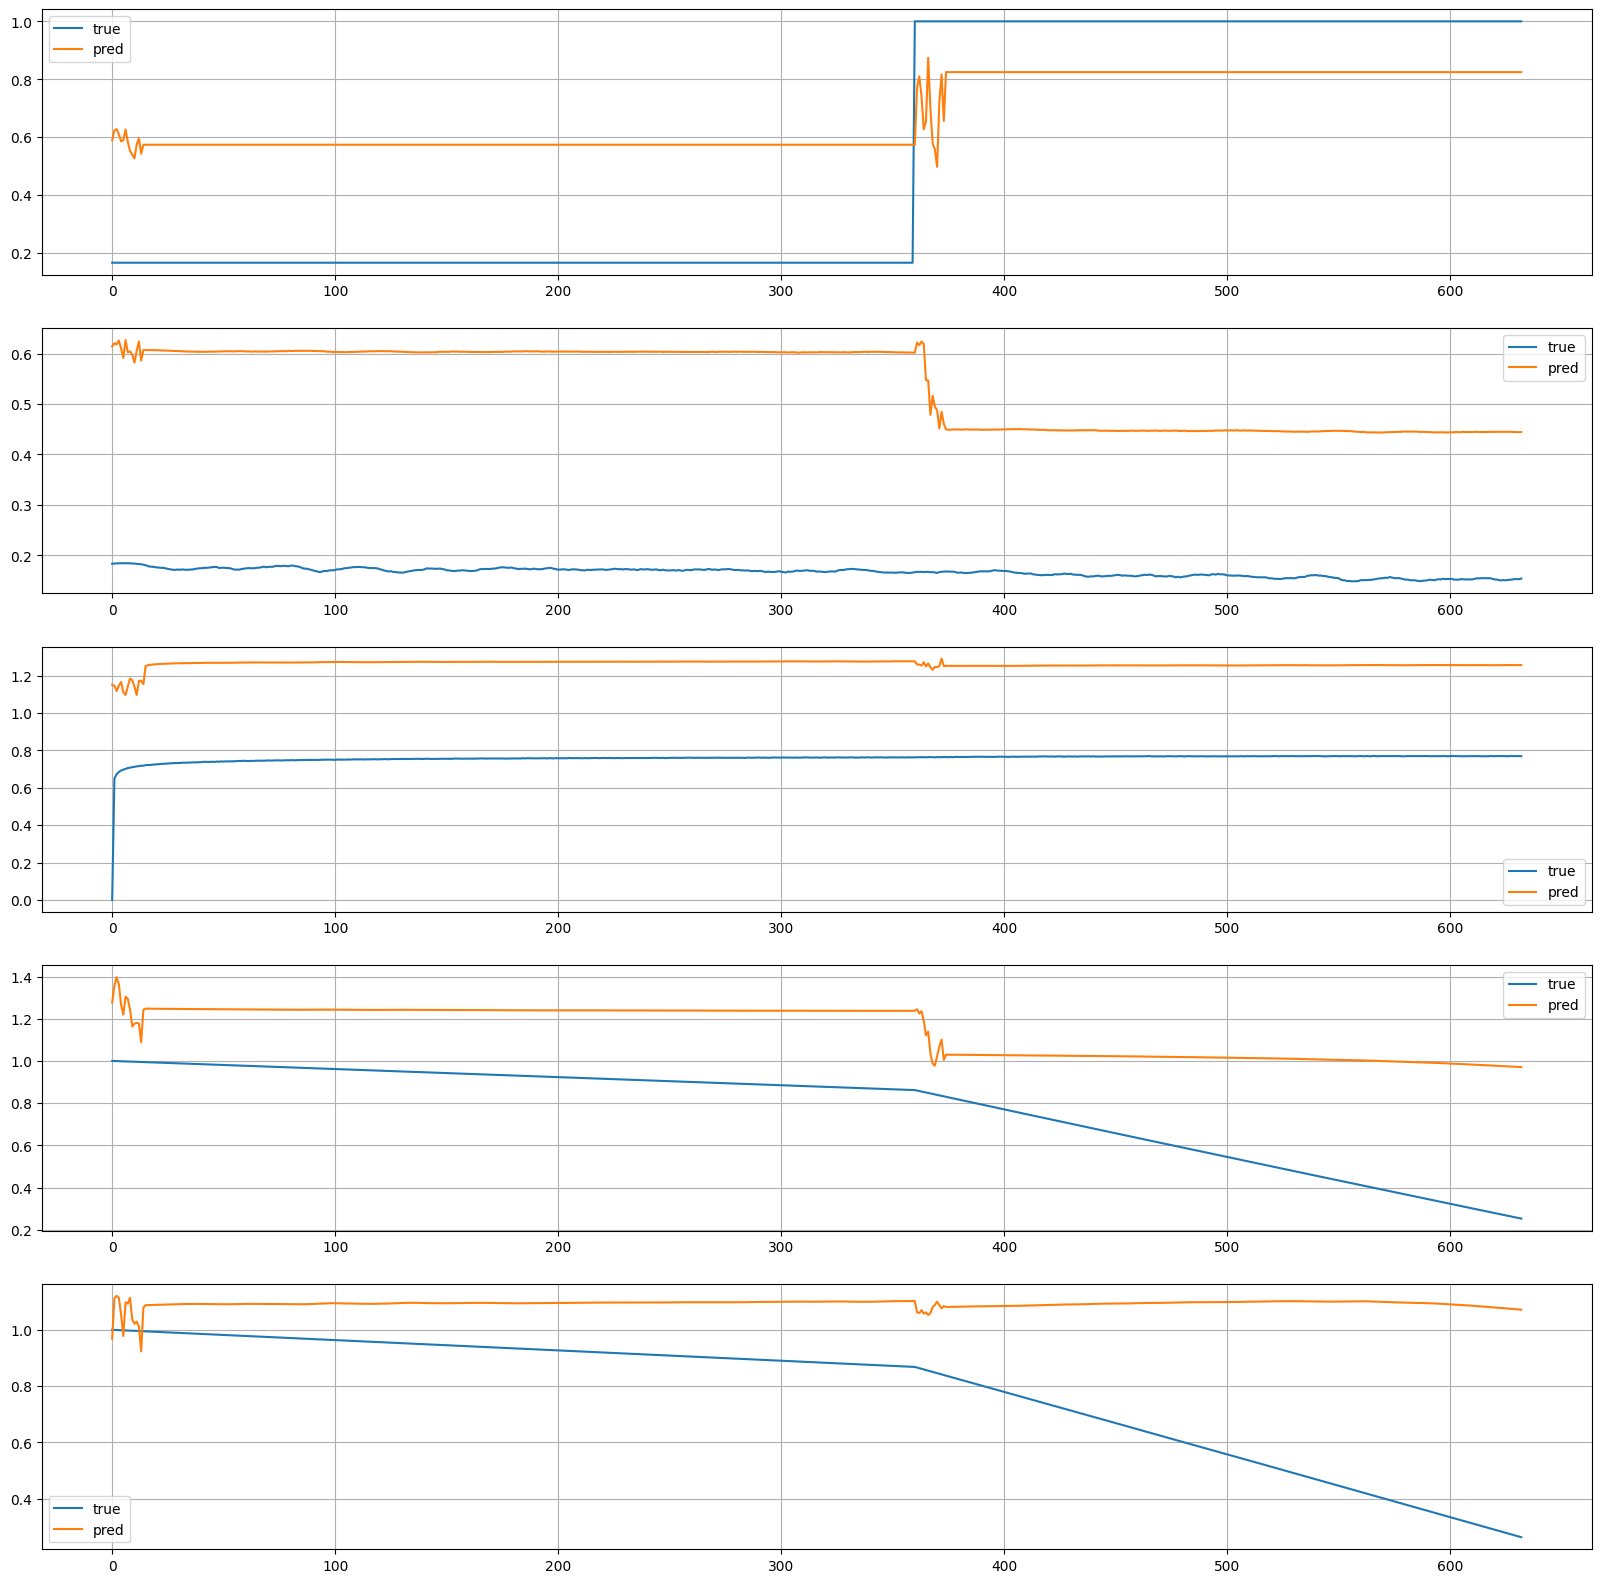

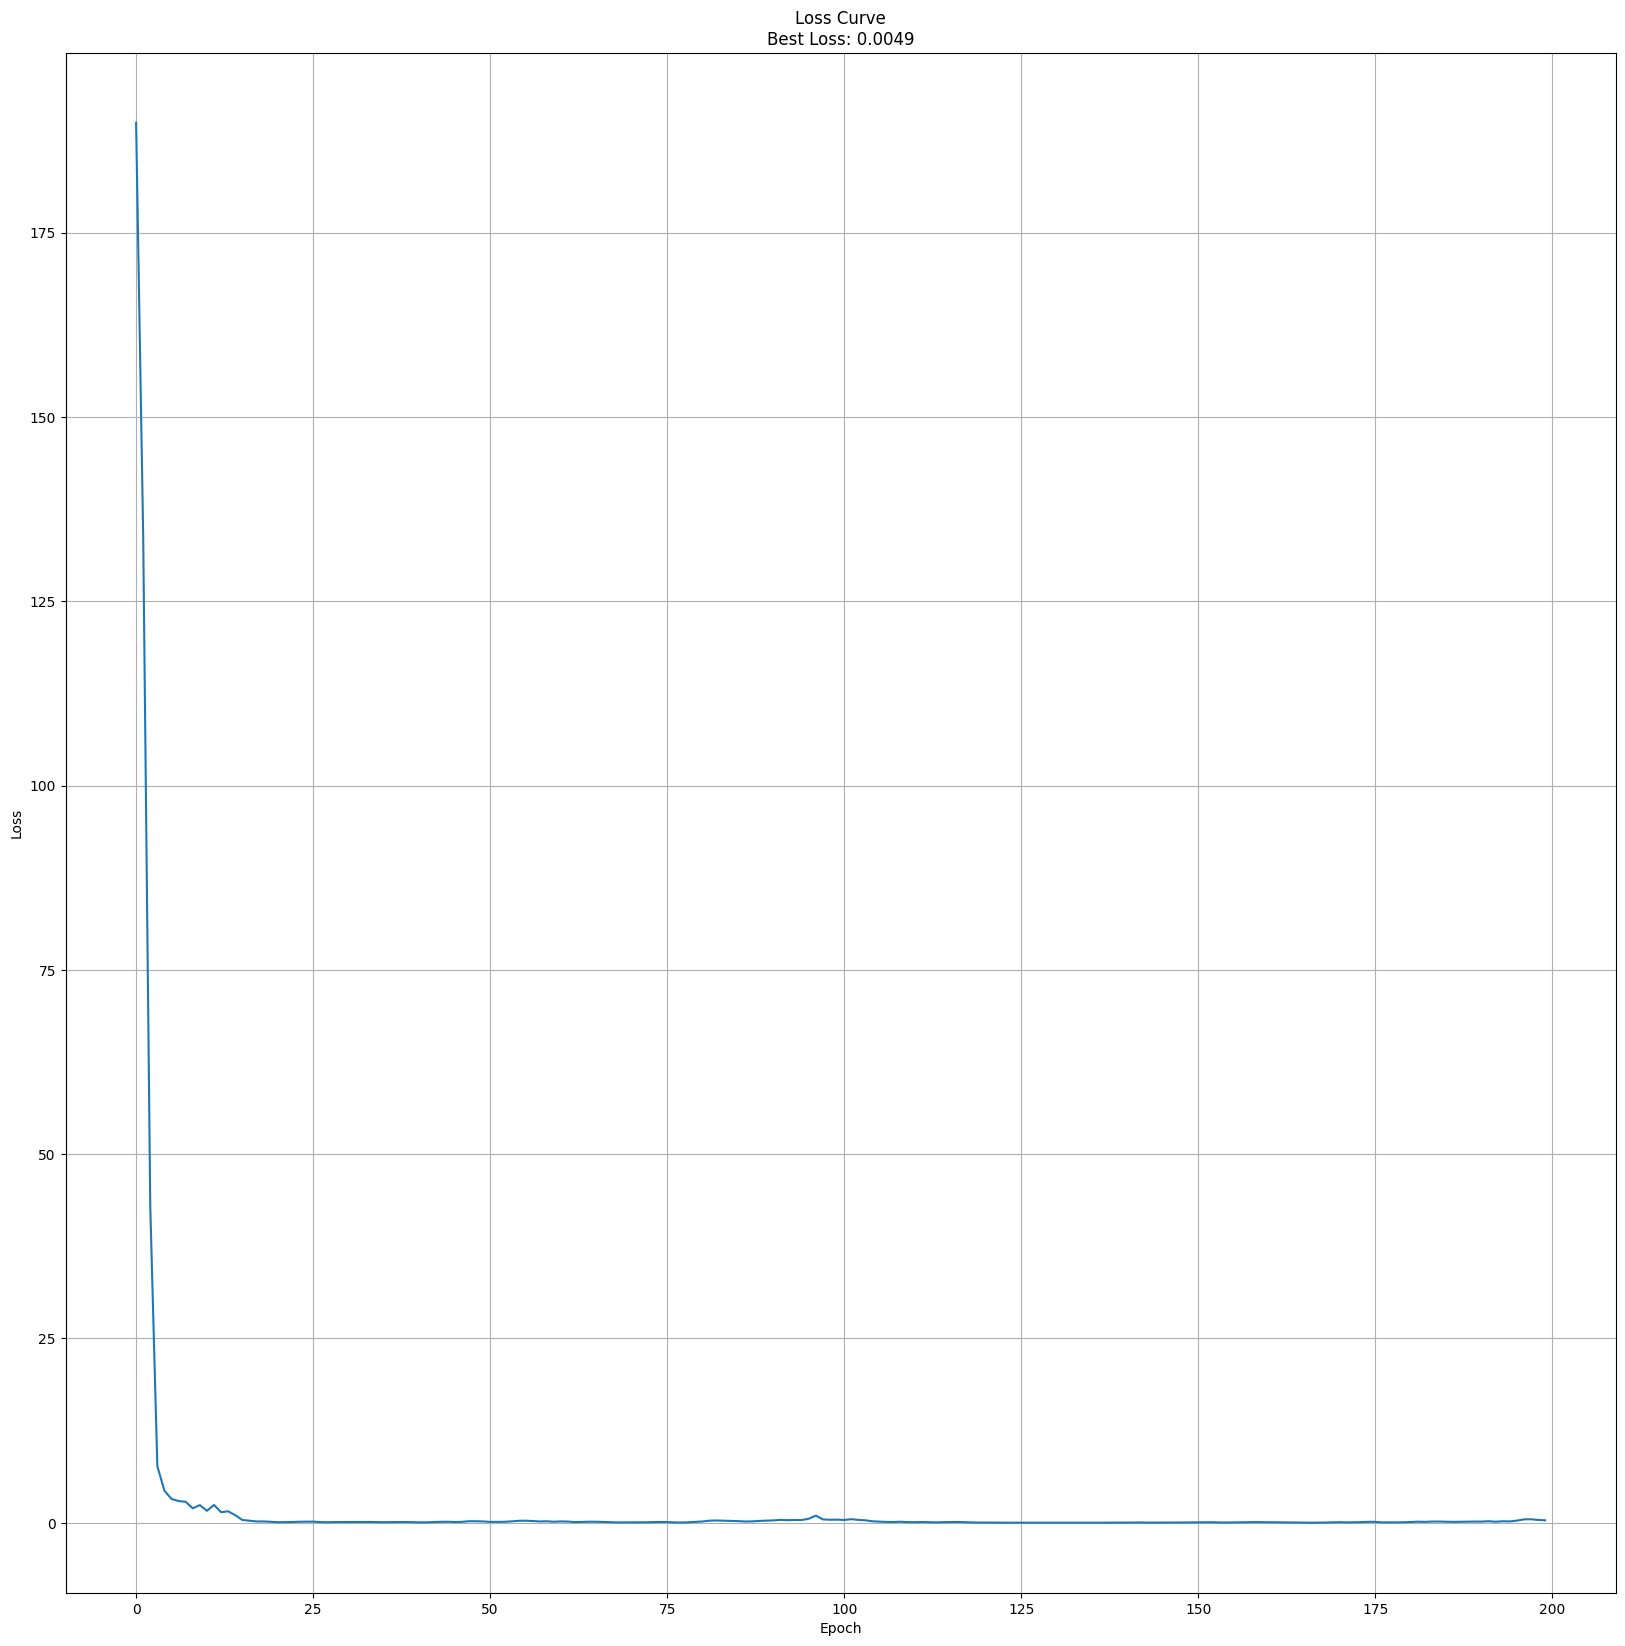

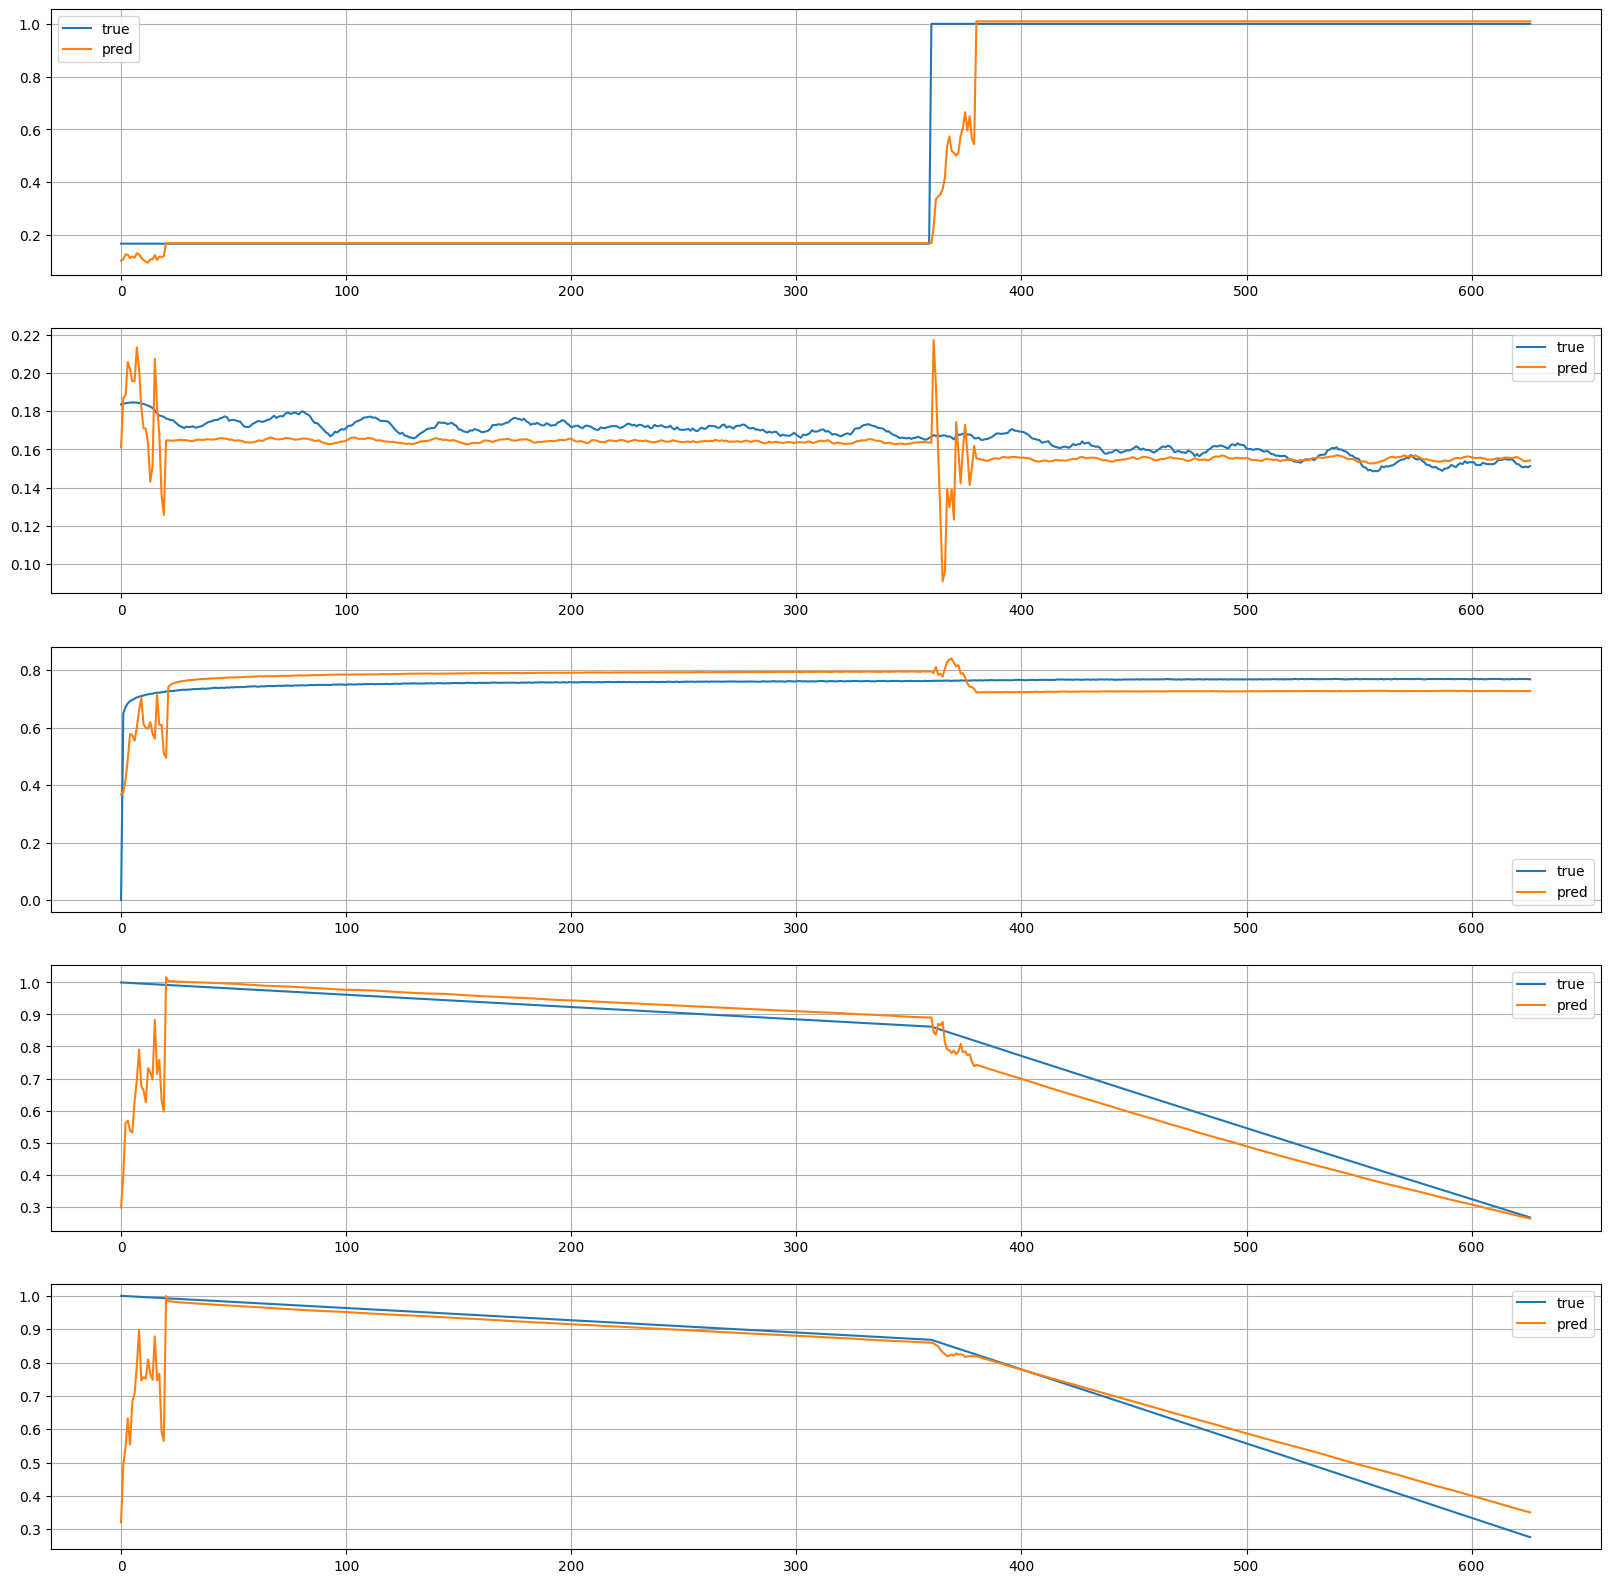

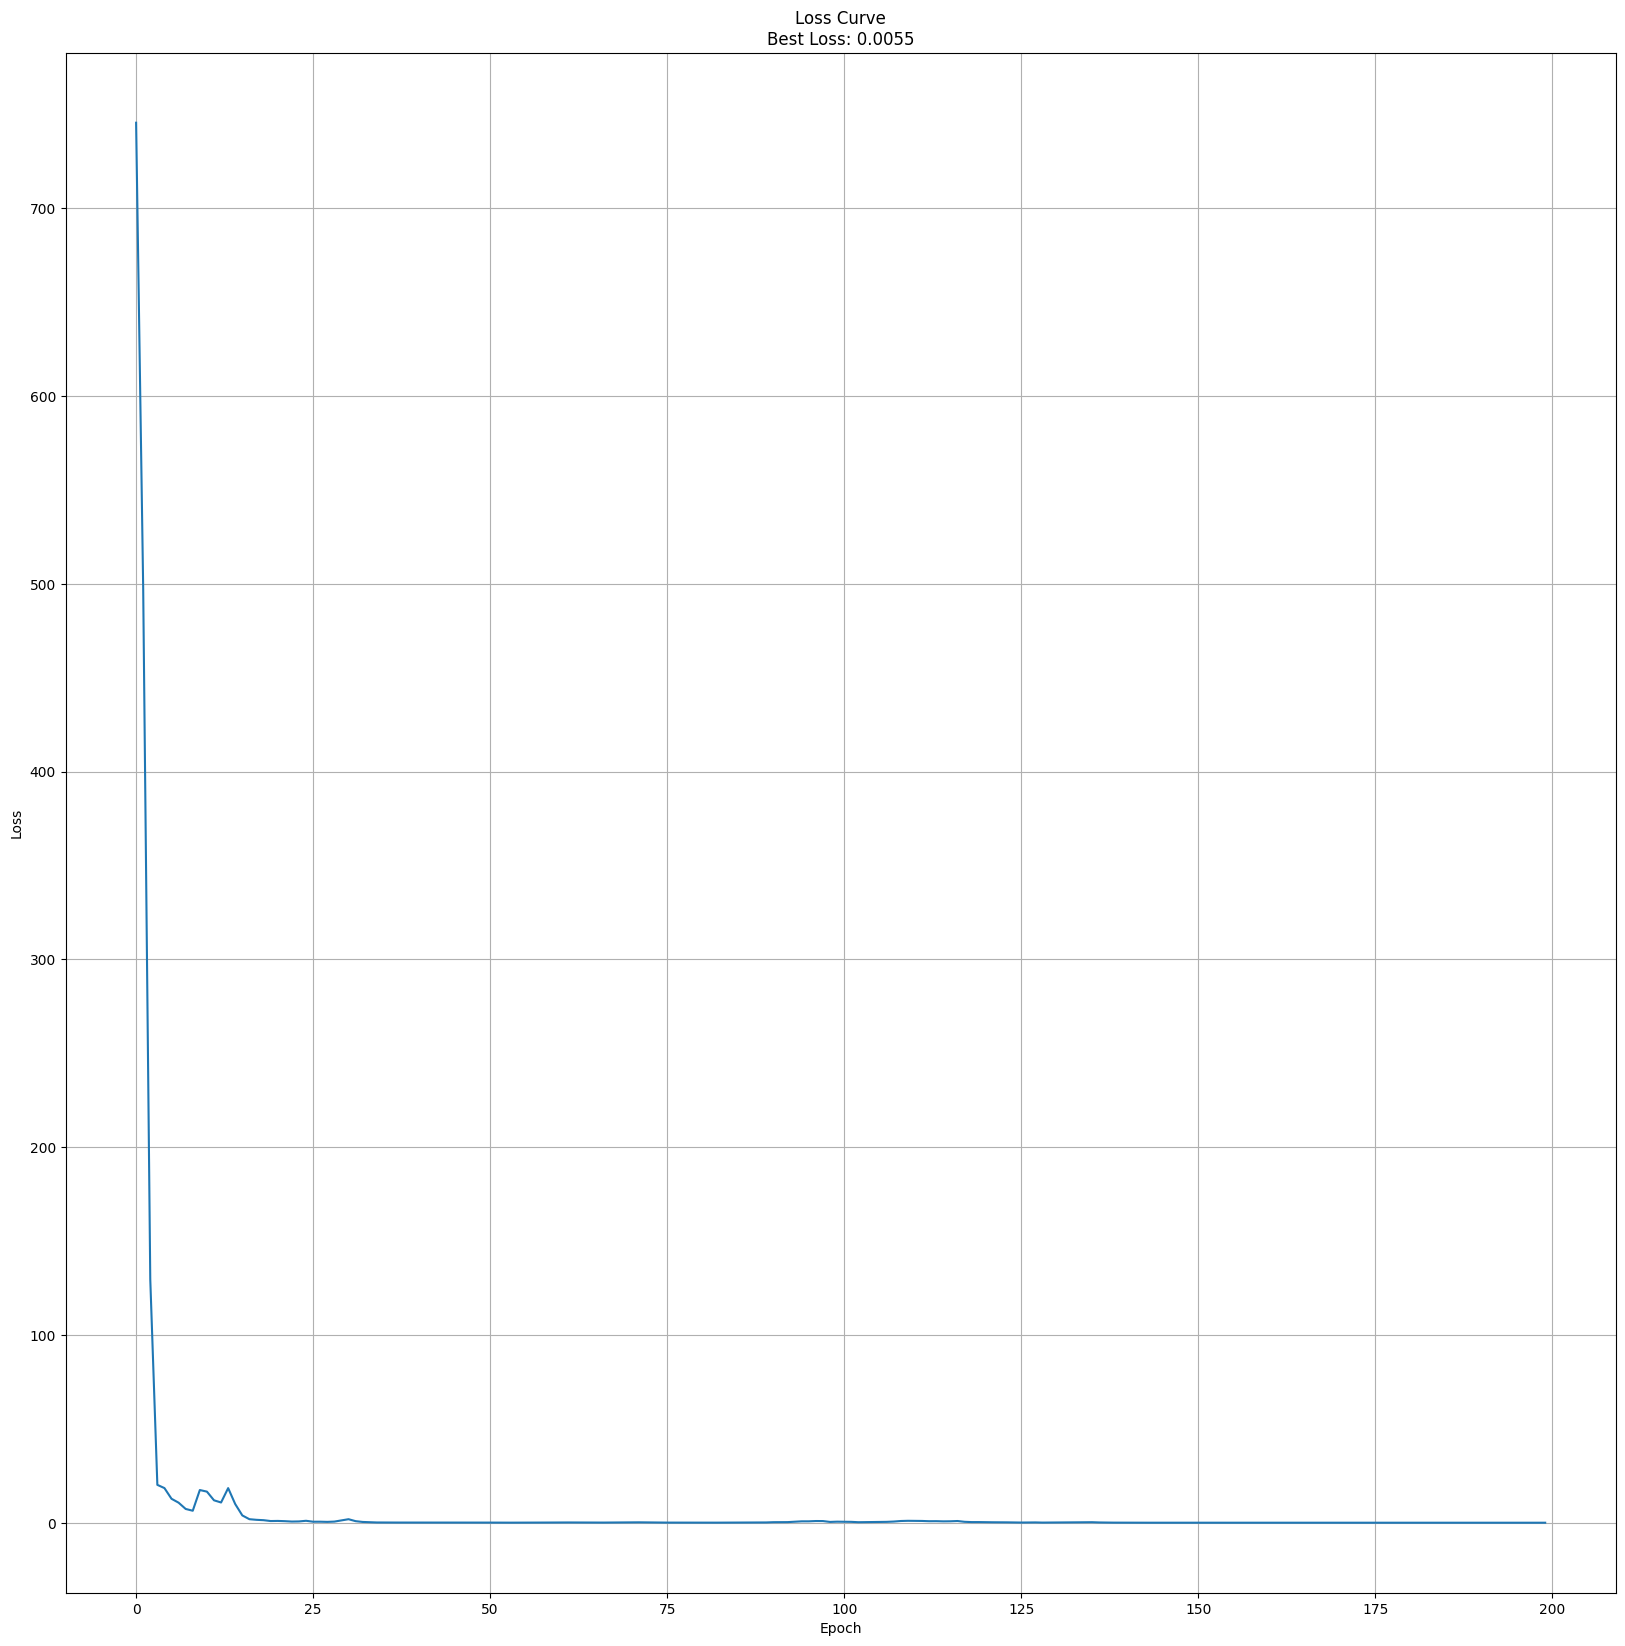

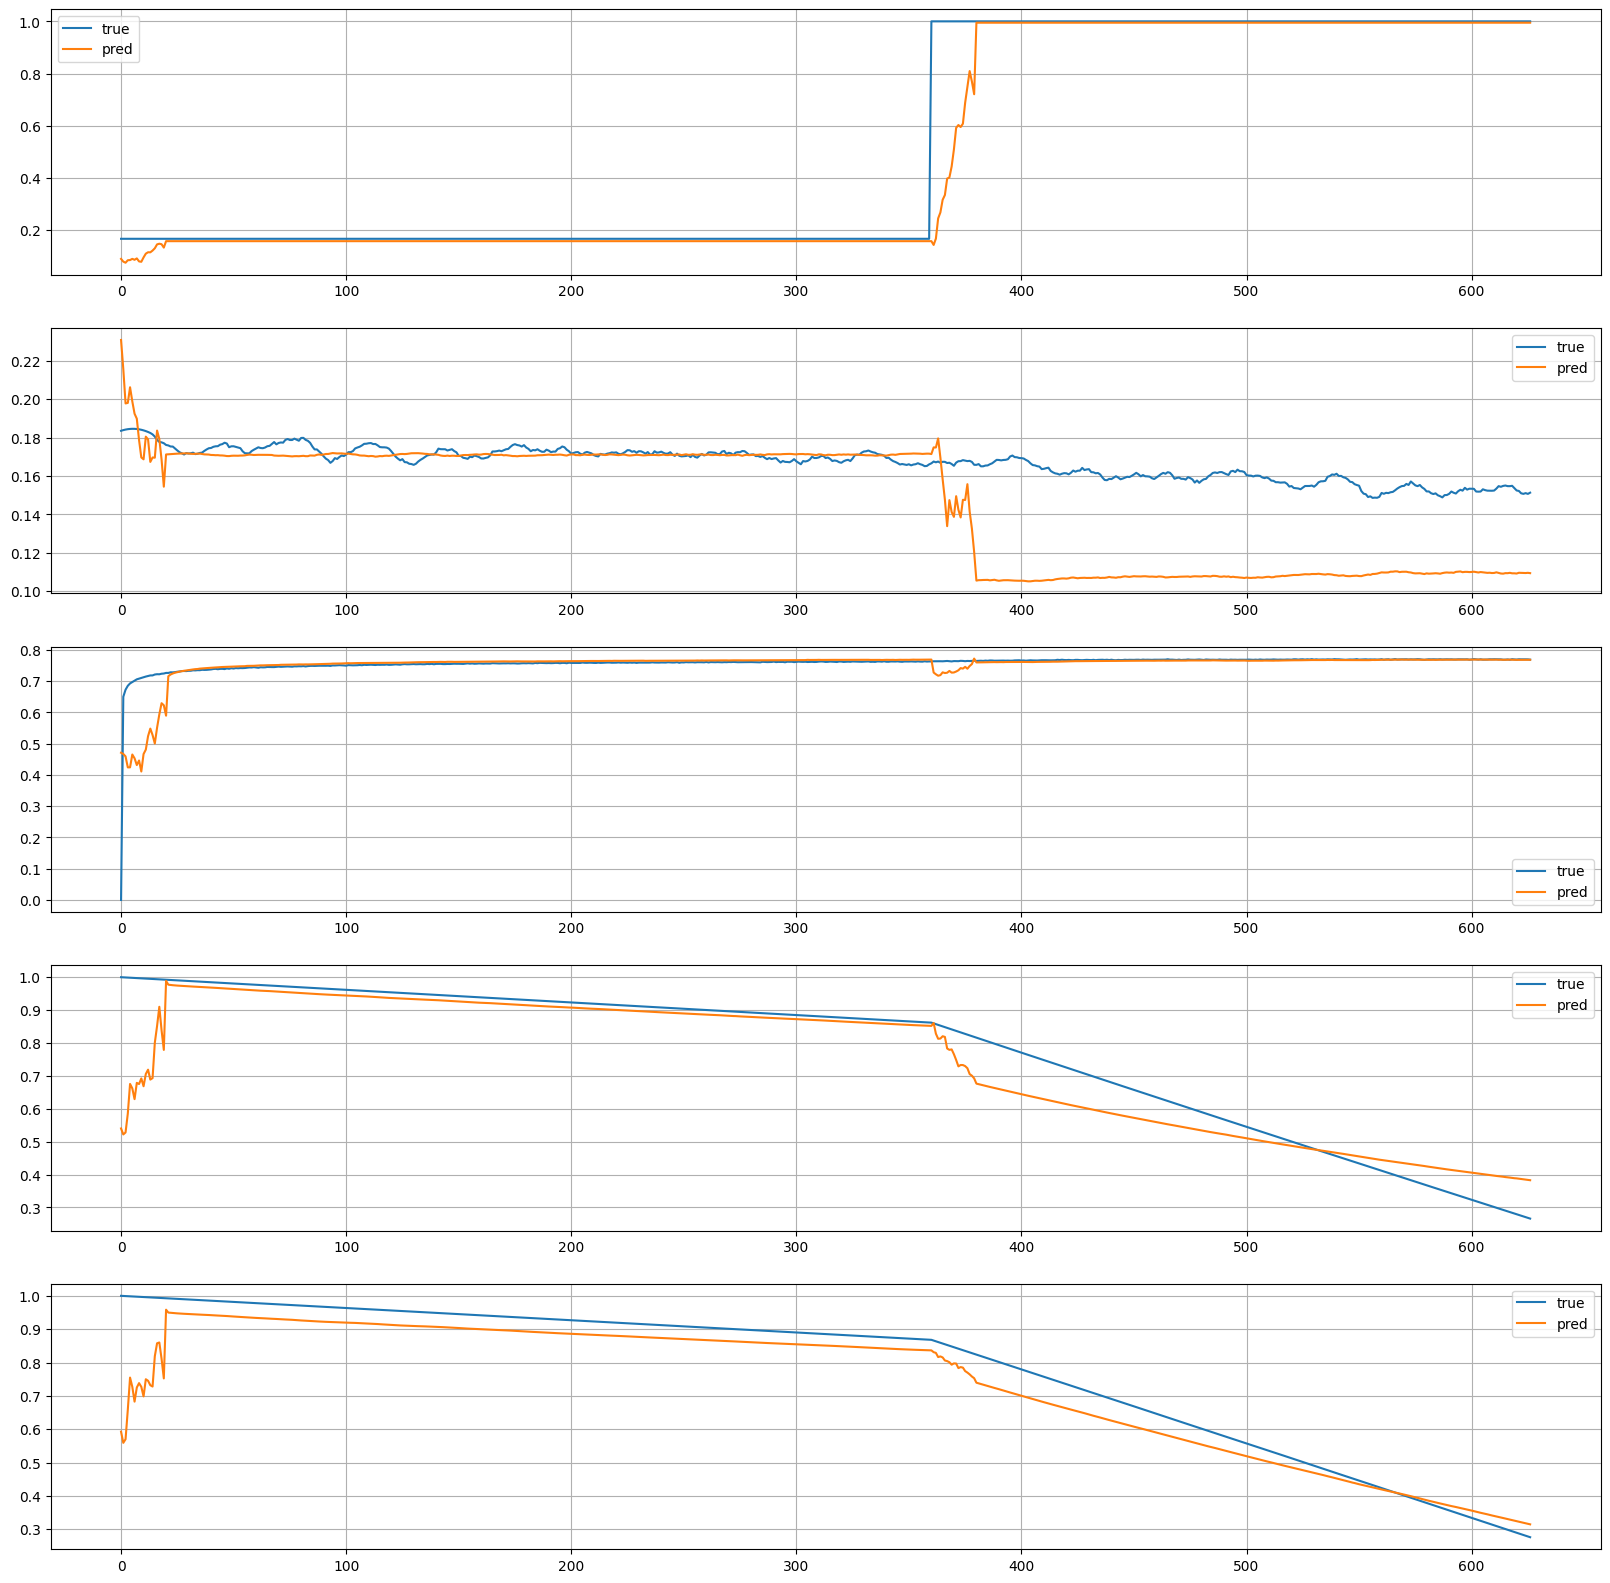

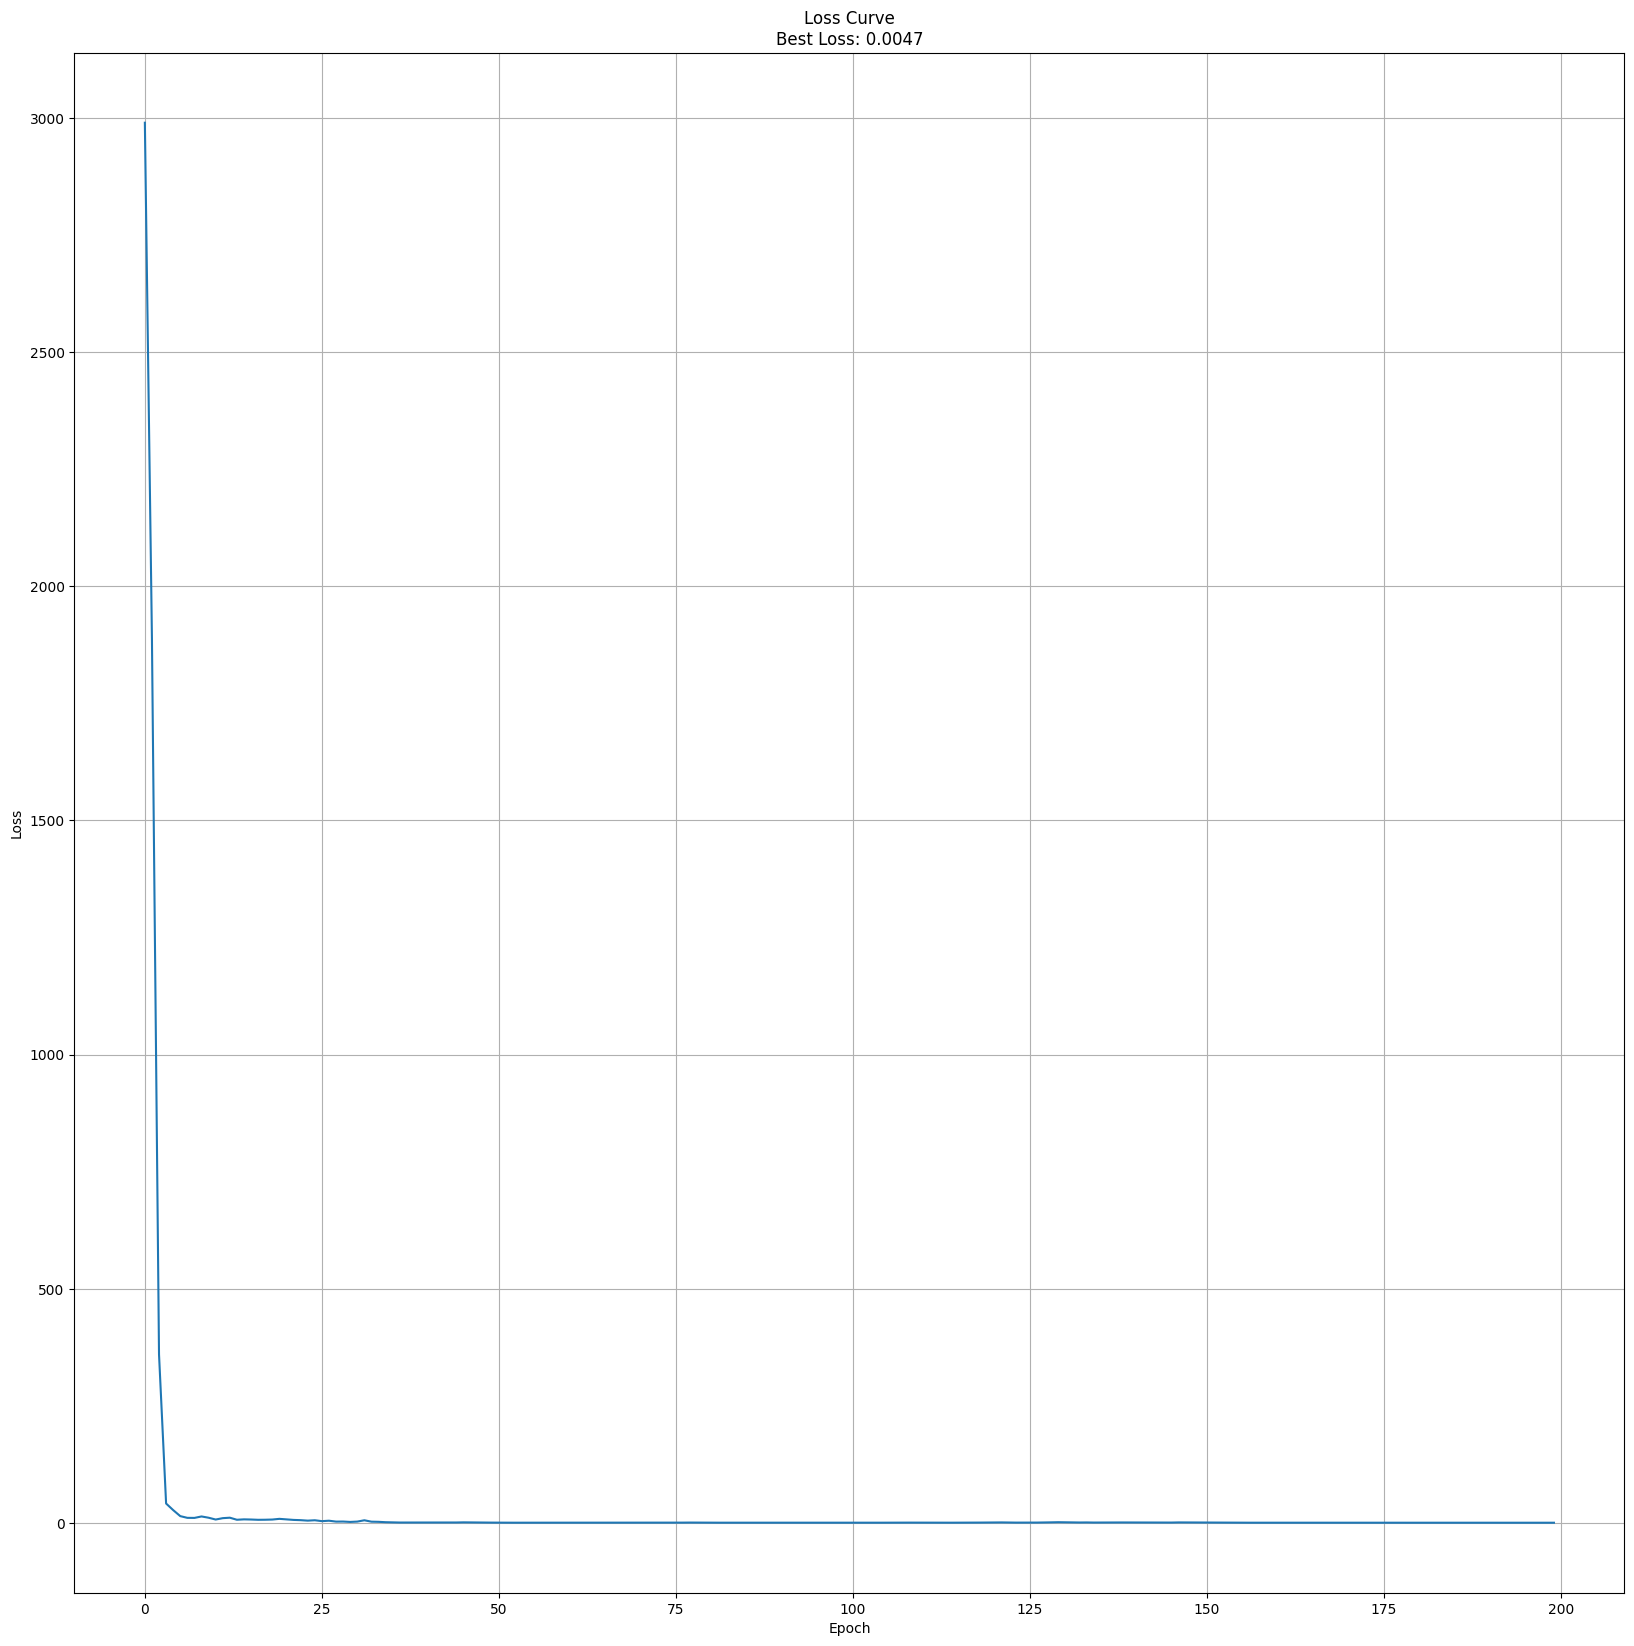

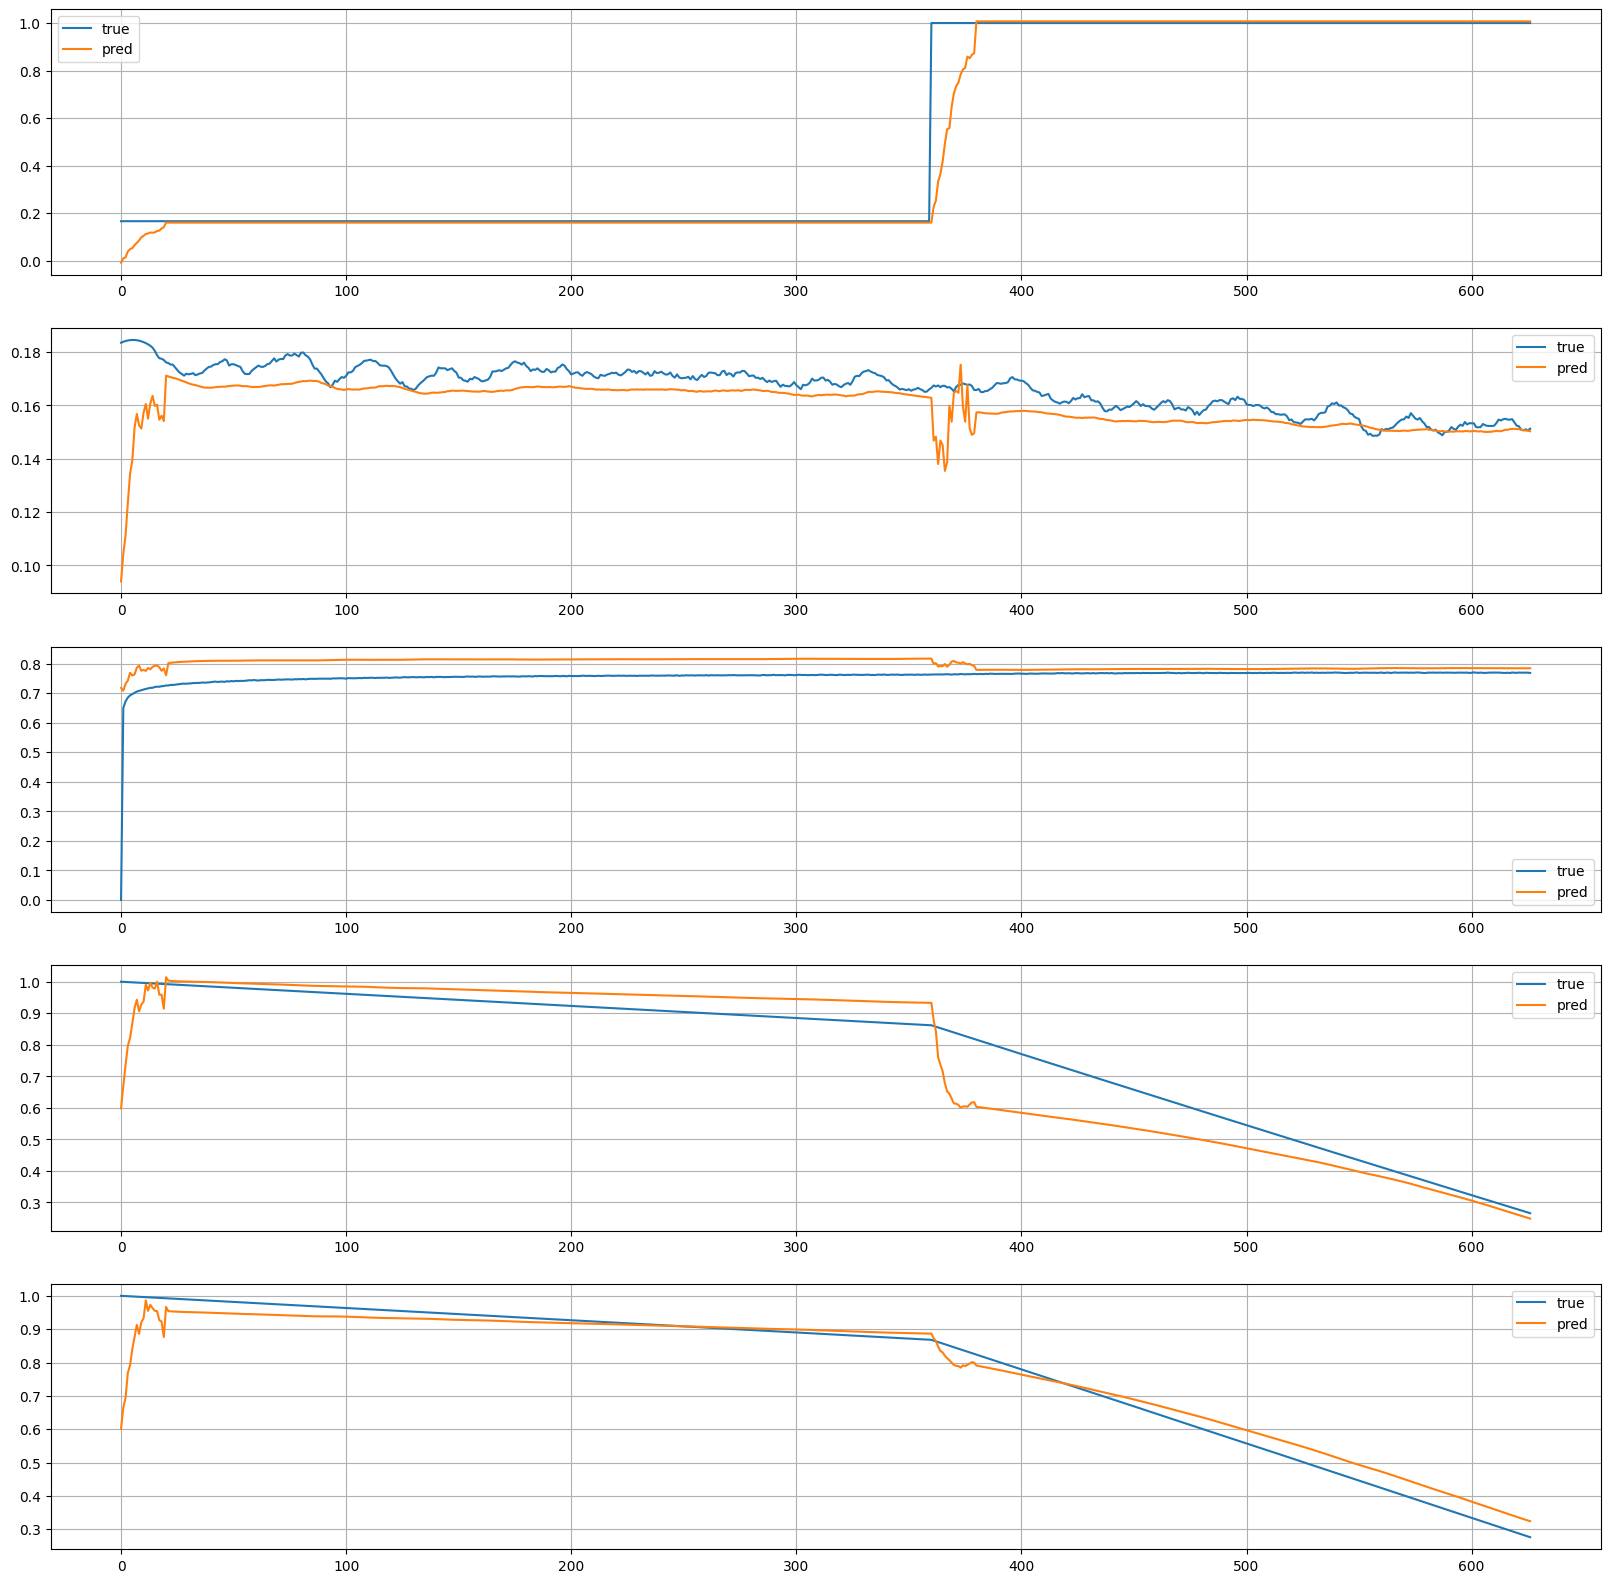

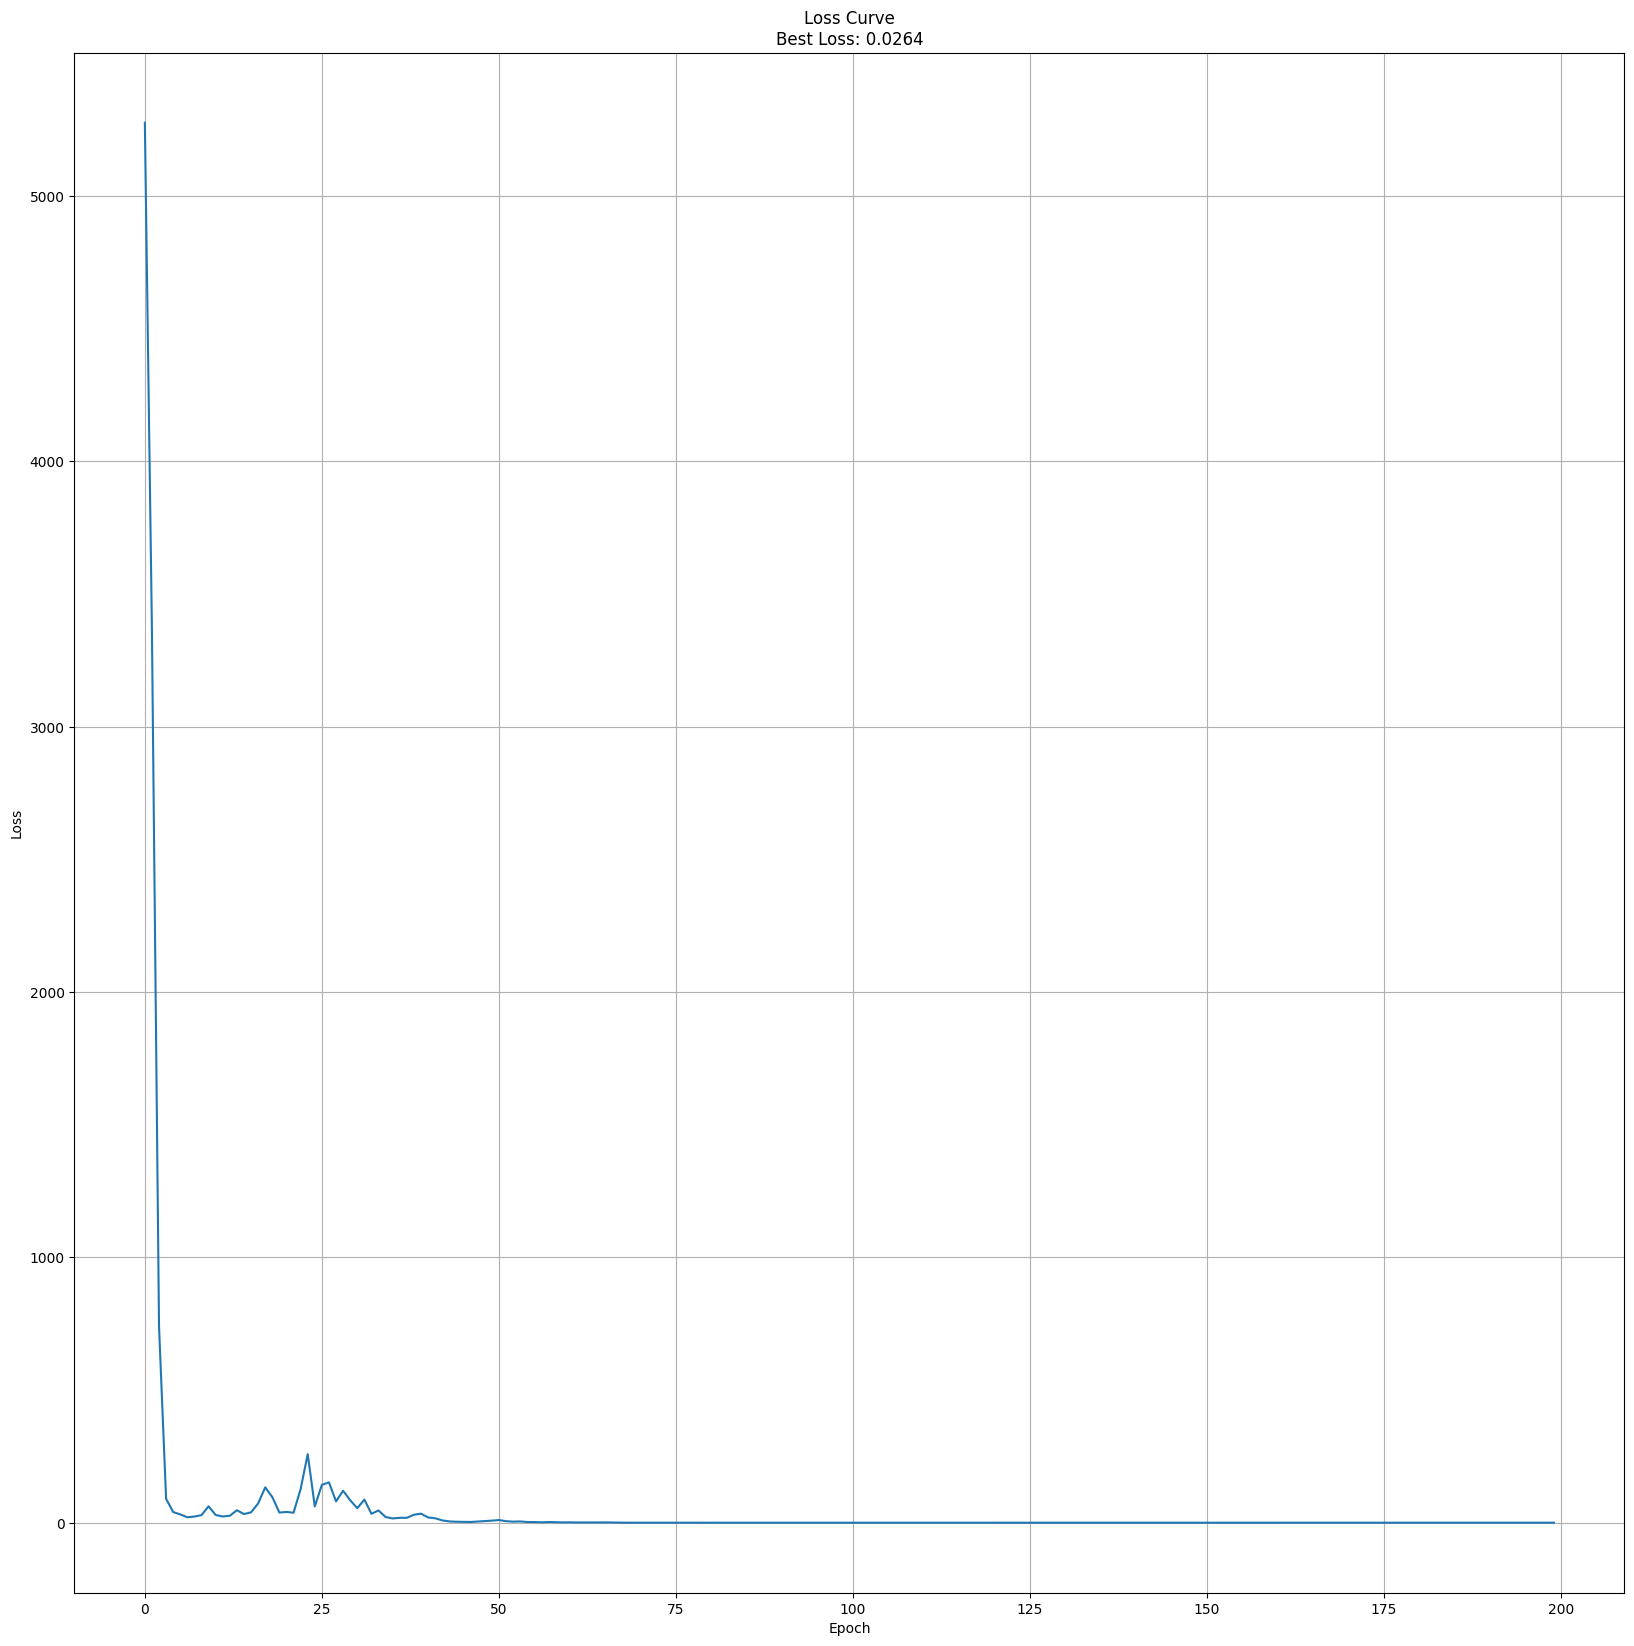

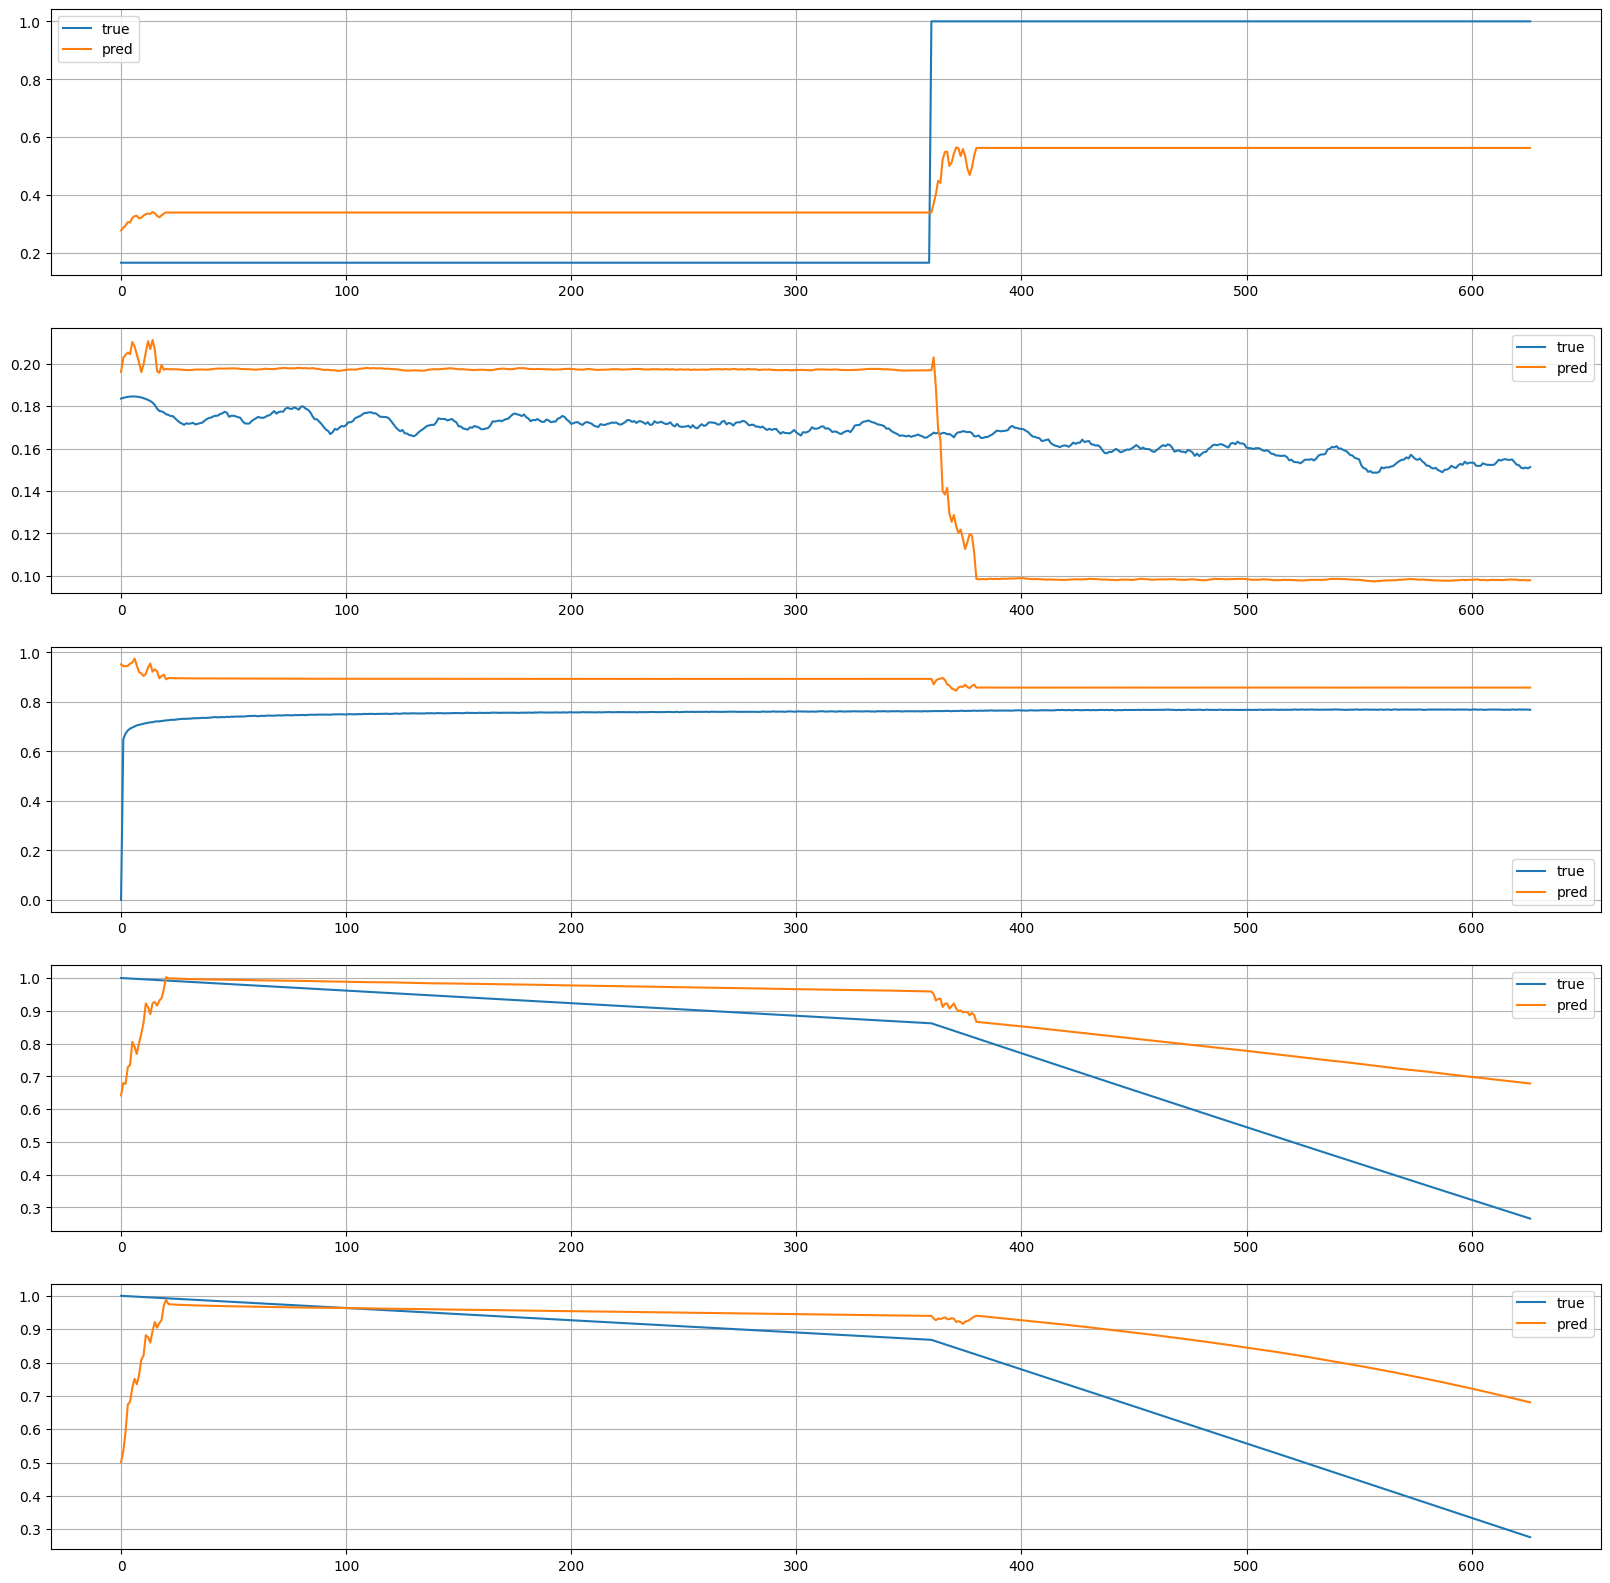

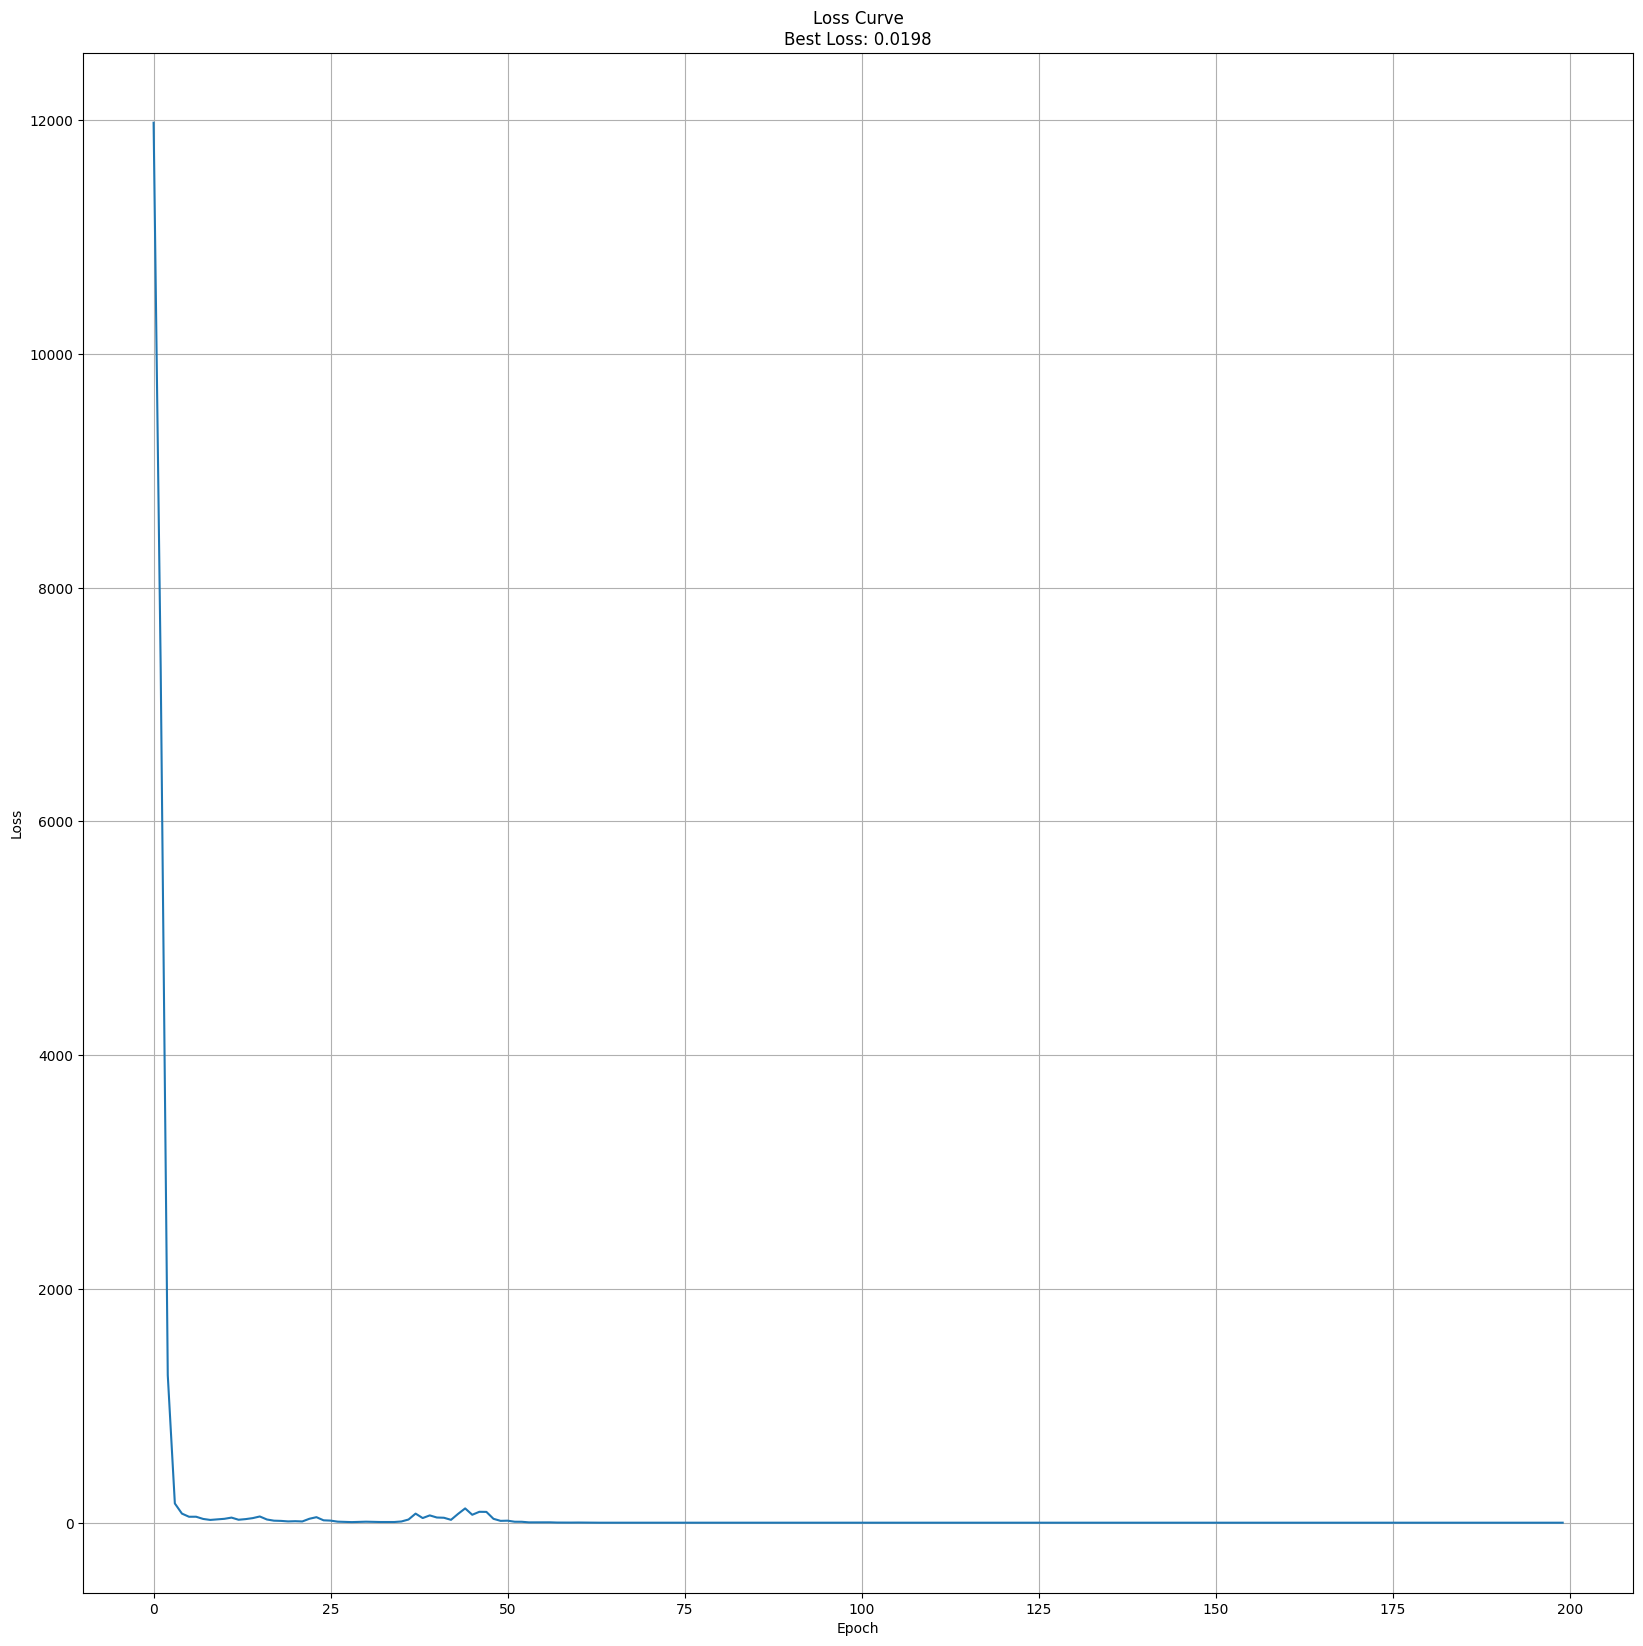

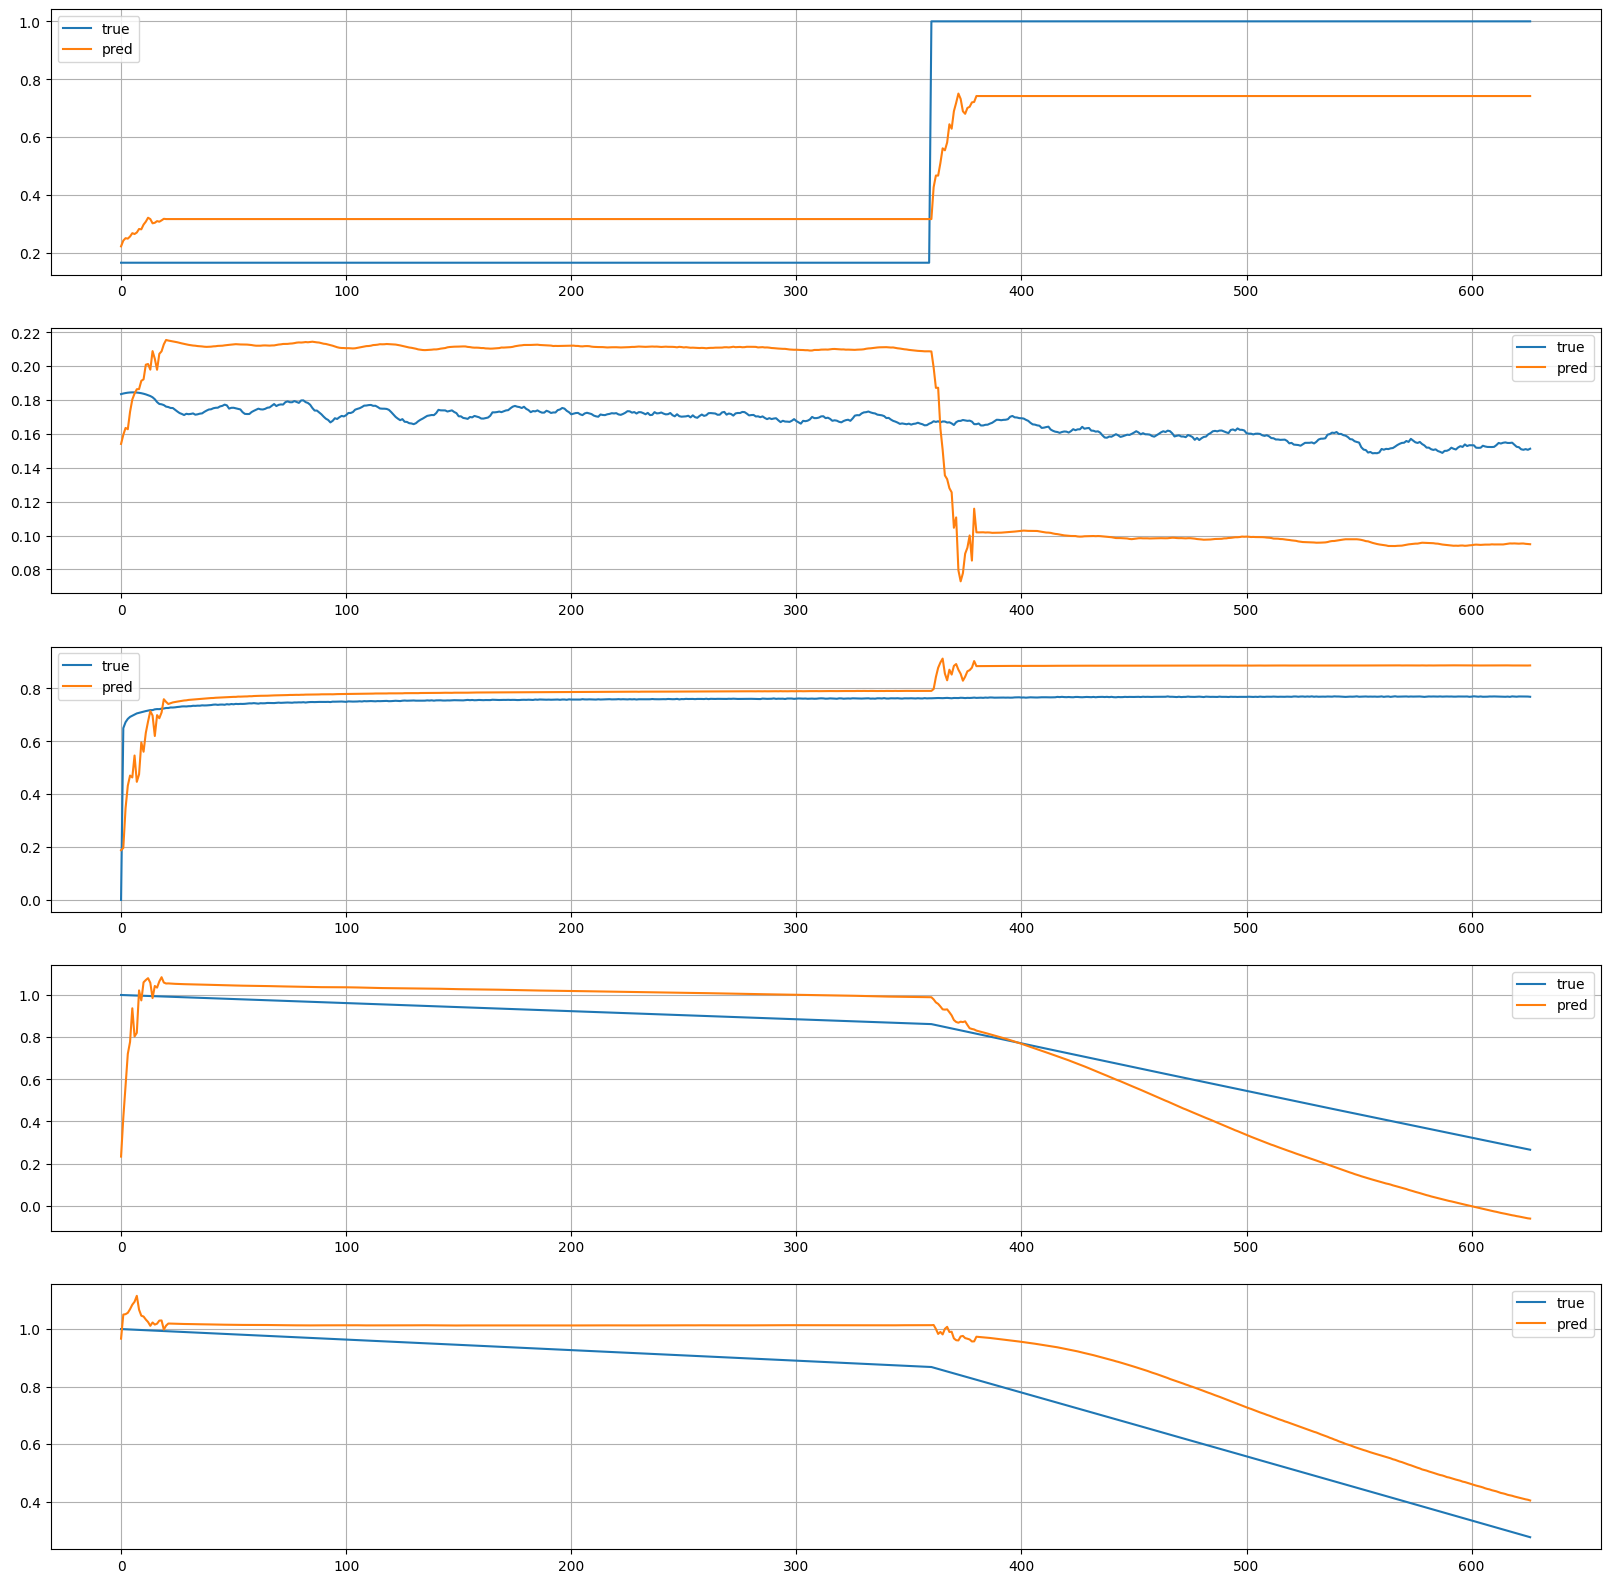

In [1058]:
for params in mpg.grid:
    savedir = f'neuro/models/d{d}_l{l}_timedelta_loss_ksmoothed'
    d = params['d_model']
    l = params['n_layers']
    mmb = MyMamba(MambaConfig(d_model=d, n_layers=l))
    hist = mmb.fit(prepared_data, epochs=200, batch_size=256, savedir=savedir)
    mmb.load_state_dict(torch.load(os.path.join(savedir, 'best.pt'), weights_only=True))
    mmb.test(scaled[0], contexts[0], savedir=savedir)

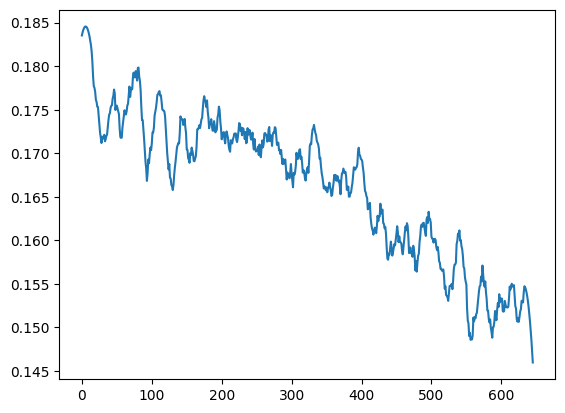

In [1057]:
plt.plot(scaled[0, :, 1])

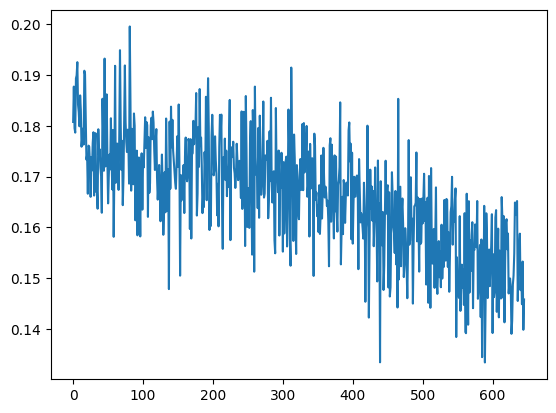

In [473]:
plt.plot(test_dataset.data[:, 0])

In [474]:
test_dataset[0]

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.18075754,
         0.18772321, 0.17952671, 0.17866127, 0.18933252, 0.1899267 ,
         0.19253217],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.64965878, 0.67220401, 0.68469367, 0.69230238, 0.69678368,
         0.70144968],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.9996158 , 0.99922895, 0.99884385, 0.99845743, 0.99807103,
         0.99768534],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.99963681, 0.99928059, 0.99891693, 0.9985472 , 0.99818758,
         0.99782252]]),
 array([[0.19253217, 0.18415798, 0.18271002, 0.1799055 , 0.18598783,
         0.18